# Aging clock

In [1]:
import pandas as pd
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
matplotlib.style.use('ggplot')
%matplotlib inline
import seaborn as sns

In [2]:
np.random.seed(42)

## 1. Download data

In [4]:
data_scaled = pd.read_csv("data/Aging_data_scaled_combined.csv",index_col=0)
# data_scaled.shape

(2476, 27190)

In [5]:
# data_normalized = pd.read_csv("data/Aging_data_normal_combined.csv",index_col=0)
# data_normalized.shape

(2476, 27190)

In [6]:
data_normalized.head()

,100008567,100009600,100012,100017,100019,100034251,100034360,100034675,100034739,100034748,...,677551,677567,677568,100034684,Age_rel_m,Age_m,GEO,Sex,Tissue,Species
GSM68912,0.548211,0.150726,-1.108670,0.798744,-0.750727,1.267601,-1.369341,-0.417527,-0.801124,0.169121,...,NaN,NaN,NaN,NaN,0.458333,22.0,GSE3150,Male,Liver,Mouse
GSM68913,0.462486,-0.446981,-0.703356,0.770389,-0.170851,1.086352,-1.801290,0.053909,-1.161547,0.206611,...,NaN,NaN,NaN,NaN,0.458333,22.0,GSE3150,Male,Liver,Mouse
GSM68914,0.342468,-0.579934,-1.121886,1.083372,-0.447764,1.006426,-1.064066,0.395615,-0.498110,-0.062172,...,NaN,NaN,NaN,NaN,0.458333,22.0,GSE3150,Male,Liver,Mouse
GSM68915,0.239494,0.731471,-1.181794,0.790239,-0.106510,1.198413,-2.055062,-0.296998,-1.164902,-0.138861,...,NaN,NaN,NaN,NaN,0.458333,22.0,GSE3150,Male,Liver,Mouse
GSM68916,-0.249189,-0.922208,-0.776602,0.792110,-0.073505,1.290214,-1.397185,-0.342347,-0.436252,0.464191,...,NaN,NaN,NaN,NaN,0.458333,22.0,GSE3150,Male,Liver,Mouse


## 2. Aging clock based on Elastic Net

In [7]:
def get_train_and_test_data(data,temp_tissue="All",temp_species="All",
                             categorical_cols=['Sex'],non_numeric_cols=['Sex','GEO','Species','Tissue'],
                           random_state=0,corr_threshold=0,na_percentage_thresh = 0,test_size=0.2):
    
    #Select tissue and species
    if (temp_tissue!="All"):
        data = data.loc[(data["Tissue"]==temp_tissue)]
    if (temp_species!="All"):
        if (temp_species=="Rodents"):
            data = data.loc[(data["Species"]!="Human")]
        else:
            data = data.loc[(data["Species"]==temp_species)]

    #Specify X and y
    X = data.drop(["Age_m","Age_rel_m"],1)
    y = data["Age_m"]
    y_rel = data["Age_rel_m"]
    X = X.iloc[:,list(X.apply(lambda x: np.sum(x.isna())<=(X.shape[0]*na_percentage_thresh),axis=0))]
    
    from sklearn.feature_extraction import DictVectorizer as DV
    encoder_cat = DV(sparse = False)
    X_cat = encoder_cat.fit_transform(X[categorical_cols].T.to_dict().values())
    X_numbers = X[set(X.columns.values.tolist())-set(non_numeric_cols)]
    
    #Split into training and test sets
    from sklearn import model_selection    
    train_inds, test_inds = next(model_selection.ShuffleSplit(test_size=test_size, n_splits=2, random_state = random_state).split(X))

    X_cat_train = X_cat[train_inds]
    X_cat_test = X_cat[test_inds]
    X_numbers = X_numbers.apply(lambda x: x.fillna(value=x.mean(skipna=True)),axis=0)

    X_train = X_numbers.iloc[train_inds]
    y_train = y[train_inds]
    y_rel_train = y_rel[train_inds]
    
    X_test = X_numbers.iloc[test_inds]
    X_test_non_numeric = X.loc[:,non_numeric_cols].iloc[test_inds]

    y_test = y[test_inds]
    y_rel_test = y_rel[test_inds]

    print(X_train.shape)
    print(X_test.shape)
    print(X_test.shape[0]/(X.shape[0])*100)
    
    #Correlation filtering
    corrs = X_train.apply(lambda x: np.corrcoef(x,y_train)[0,1],axis=0)
    sign_genes = corrs.iloc[np.where(np.abs(corrs)>corr_threshold)]
    sign_genes = sign_genes.index
    print(len(sign_genes))
    
    if (X_cat.shape[1]>0):
        X_train_filtered = np.hstack((np.array(X_train[sign_genes]),X_cat_train))
        X_test_filtered = np.hstack((np.array(X_test[sign_genes]),X_cat_test))
    else:
        X_train_filtered = X_train[sign_genes]
        X_test_filtered = X_test[sign_genes]
        
    groups = X["GEO"][train_inds]

    return (X_train_filtered, y_train, y_rel_train,
            X_test_filtered, y_test, y_rel_test, groups, X_test_non_numeric)

In [8]:
def run_ML_model_LOGO_group(X_train,y_train,X_test,y_test,groups,param_grid,model_type="EN",
                           scoring="neg_mean_absolute_error",refit=False,random_state=0):
    import warnings

    def fxn():
        warnings.warn("deprecated", DeprecationWarning)

    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        from sklearn import linear_model,ensemble
        from sklearn.model_selection import GridSearchCV
        from sklearn import metrics
        from sklearn.model_selection import GroupKFold, LeaveOneGroupOut
        logo = LeaveOneGroupOut()
    
        if (model_type=="EN"):
            estimator = linear_model.ElasticNet(random_state=random_state)
        elif (model_type=="RF"):
            estimator = ensemble.RandomForestRegressor()
        else:
            return
        
        if (type(scoring)==dict):
            if (refit==False):
                refit = list(scoring.keys())[0]
            grid_model = GridSearchCV(estimator, param_grid, scoring = scoring,refit=refit,
                                      cv = logo.split(X_train,y_train,groups),
                                      n_jobs=-1)
        else:
            grid_model = GridSearchCV(estimator, param_grid, scoring = scoring,
                                      cv = logo.split(X_train,y_train,groups),
                                      n_jobs=-1)

        grid_model.fit(X_train,y_train)
        grid_model.best_estimator_.feature_names = list(X_train.columns.values)
    
        print("Best parameters:")
        print(grid_model.best_params_)
        print("Best average cross-validation score:")
        print(grid_model.best_score_)

#        print("Alpha: ")
#        print(grid_model.alpha_)
#        print("l1 ratio: ")
#        print(grid_model.l1_ratio_)
        test_predictions = grid_model.predict(X_test)
        train_predictions = grid_model.predict(X_train)
    print("MAE: ")
    print(metrics.mean_absolute_error(y_train,train_predictions))
    print(metrics.mean_absolute_error(y_test,test_predictions))
    print("R2: ")
    print(metrics.r2_score(y_train,train_predictions))
    print(metrics.r2_score(y_test,test_predictions))
    print("Explained variance: ")
    print(metrics.explained_variance_score(y_train,train_predictions))
    print(metrics.explained_variance_score(y_test,test_predictions))
    
    return grid_model

In [9]:
def draw_quality_plot(predicted_y_train,real_y_train,
                      predicted_y_test,real_y_test,
                      predicted_log_y_train,real_log_y_train,
                      predicted_log_y_test,real_log_y_test,
                      title1="Aging clock",title2="Aging clock (log scale)",
                      filename="temp.pdf"):
    plt.figure(figsize=(16,8))

    sns.set(font_scale=1)
    sns.set_style("whitegrid")
    plt.rcParams["axes.labelsize"] = 16
    plt.rcParams["axes.titlesize"] = 20

    plt.subplot(1,2,1)
    plt.grid(False)
    plt.axline((0,0),(1,1),linewidth=0.5,color='black')
    sns.scatterplot(x=predicted_y_train,y=real_y_train, 
            alpha=0.8, color = 'red')
    sns.scatterplot(x=predicted_y_test,y=real_y_test, 
            alpha=0.8, color = 'blue')
    plt.legend(labels=['','Training set', 'Test set'],prop={'size': 16})
    plt.title(title1)
    plt.xlabel("Predicted relative age")
    plt.ylabel("Real relative age")
    

    plt.subplot(1,2,2)
    plt.grid(False)
    plt.axline((0,0),(1,1),linewidth=0.5,color='black')
    sns.scatterplot(x=predicted_log_y_train,y=real_log_y_train, 
            alpha=0.8, color = 'red')
    sns.scatterplot(x=predicted_log_y_test,y=real_log_y_test, 
            alpha=0.8, color = 'blue')
    plt.legend(labels=['','Training set', 'Test set'],prop={'size': 16})
    plt.title(title2)
    plt.xlabel("Predicted relative age (log)")
    plt.ylabel("Real relative age (log)")
    
    plt.savefig(filename, bbox_inches='tight')

## Specific clocks

## Mouse Liver

In [22]:
temp_tissue = "Liver"
temp_species = "Mouse"

In [54]:
(X_norm_train, y_train, y_rel_train,
X_norm_test, y_test, y_rel_test, groups,
X_test_nonnumeric) = get_train_and_test_data(data_normalized,temp_tissue,temp_species,
                                                                  categorical_cols=[],random_state=6,corr_threshold=0,
                                                                  na_percentage_thresh=0.2)

(X_scaled_train, y_train, y_rel_train,
X_scaled_test, y_test, y_rel_test, groups,
X_test_nonnumeric) = get_train_and_test_data(data_scaled,temp_tissue,temp_species,
                                                                  categorical_cols=[],random_state=6,corr_threshold=0,
                                                                    na_percentage_thresh=0.2)

(82, 9793)
(21, 9793)
20.388349514563107
9793
(82, 9793)
(21, 9793)
20.388349514563107
9793


#### Run elastic net model

In [12]:
param_grid = {'alpha': np.logspace(-4,3,8),
             'l1_ratio': np.linspace(0,1,6)}
param_grid = {'alpha': np.logspace(-2,1,4),
             'l1_ratio': np.linspace(0,1,6)}

In [13]:
multi_scoring = {"MAE": "neg_mean_absolute_error",
                "R2": "r2",
               "MSE": "neg_mean_squared_error",
                "EV": "explained_variance"}

Normalized data

In [138]:
%%time
grid_model_norm_liver_mouse = run_ML_model_LOGO_group(X_norm_train,y_rel_train,
                                                X_norm_test,y_rel_test,
                                               groups,param_grid,model_type="EN",
                                                      scoring=multi_scoring,refit="MAE")

Best parameters:
{'alpha': 0.01, 'l1_ratio': 1.0}
Best average cross-validation score:
-0.11765655450708386
MAE: 
0.06367107889845203
0.079596556907505
R2: 
0.8222204051179011
0.5921840942790677
Wall time: 6.14 s


In [139]:
np.max(grid_model_norm_liver_mouse.cv_results_['mean_test_R2'])

0.43886289092987996

In [79]:
%%time
grid_model_norm_log_liver_mouse = run_ML_model_LOGO_group(X_norm_train,np.log10(y_rel_train*100+1),
                                                    X_norm_test,np.log10(y_rel_test*100+1),
                                               groups,param_grid,model_type="EN",
                                                          scoring=multi_scoring,refit="MAE")

Best parameters:
{'alpha': 0.01, 'l1_ratio': 0.2}
Best average cross-validation score:
-0.1991189523015526
MAE: 
0.02616535244516926
0.09485964782968581
R2: 
0.9908380988409502
0.8378780731557367
Wall time: 7.31 s


In [80]:
np.max(grid_model_norm_log_liver_mouse.cv_results_['mean_test_R2'])

0.5039605101953615

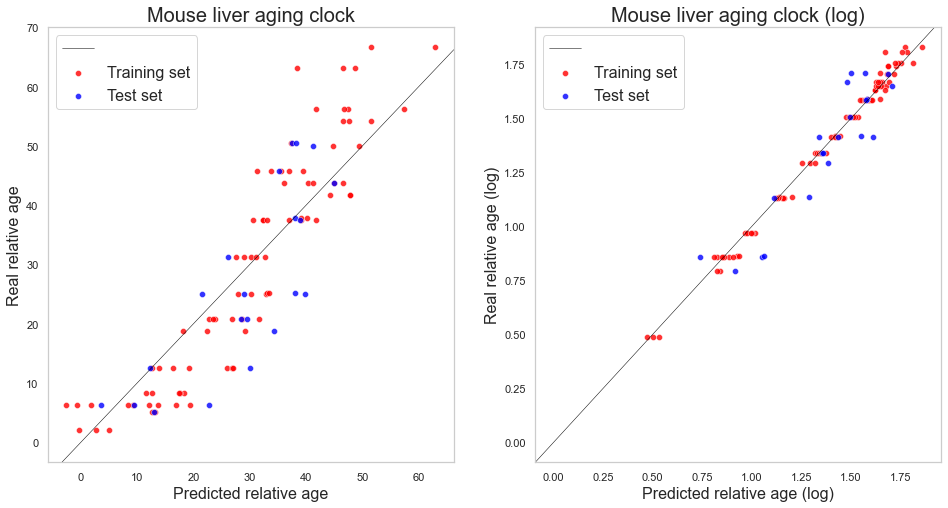

In [81]:
draw_quality_plot(grid_model_norm_liver_mouse.predict(X_norm_train)*100,y_rel_train*100,
                 grid_model_norm_liver_mouse.predict(X_norm_test)*100,y_rel_test*100,
                 grid_model_norm_log_liver_mouse.predict(X_norm_train),np.log10(y_rel_train*100+1),
                 grid_model_norm_log_liver_mouse.predict(X_norm_test),np.log10(y_rel_test*100+1),
                 title1='Mouse liver aging clock',
                 title2='Mouse liver aging clock (log)')

R2 = 59% and 84%

Scaled data

In [142]:
grid_model_scale_liver_mouse = run_ML_model_LOGO_group(X_scaled_train,y_rel_train,
                                                 X_scaled_test,y_rel_test,
                                               groups,param_grid,model_type="EN",
                                                       scoring='neg_mean_absolute_error')

Best parameters:
{'alpha': 0.01, 'l1_ratio': 1.0}
Best average cross-validation score:
-0.11263611150205599
MAE: 
0.06370709936716346
0.07568419451895532
R2: 
0.8283183720373577
0.6440687558790855


In [143]:
grid_model_scale_log_liver_mouse = run_ML_model_LOGO_group(X_scaled_train,np.log10(y_rel_train*100+1),
                                                    X_scaled_test,np.log10(y_rel_test*100+1),
                                               groups,param_grid,model_type="EN",
                                                           scoring='neg_mean_absolute_error')

Best parameters:
{'alpha': 0.1, 'l1_ratio': 0.2}
Best average cross-validation score:
-0.21416585904552332
MAE: 
0.09854707427956709
0.1312617045726152
R2: 
0.8853148405312522
0.7312327218398444


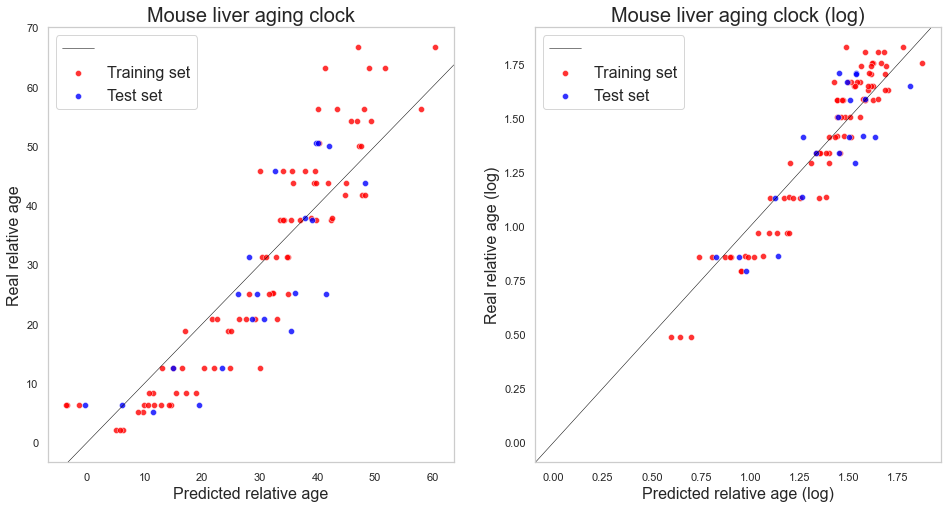

In [133]:
draw_quality_plot(grid_model_scale_liver_mouse.predict(X_scaled_train)*100,y_rel_train*100,
                 grid_model_scale_liver_mouse.predict(X_scaled_test)*100,y_rel_test*100,
                 grid_model_scale_log_liver_mouse.predict(X_scaled_train),np.log10(y_rel_train*100+1),
                 grid_model_scale_log_liver_mouse.predict(X_scaled_test),np.log10(y_rel_test*100+1),
                 title1='Mouse liver aging clock',
                 title2='Mouse liver aging clock (log)')

R2 = 64.4% and 73%, MAE = 0.13 (~35% error)

## Mouse Brain

In [1369]:
temp_tissue = "Brain"
temp_species = "Mouse"

In [1372]:
(X_norm_train, y_train, y_rel_train,
X_norm_test, y_test, y_rel_test, groups) = get_train_and_test_data(data_normalized,temp_tissue,temp_species,
                                                                  categorical_cols=[],random_state=6,corr_threshold=0,
                                                                  na_percentage_thresh=0.05)

(X_scaled_train, y_train, y_rel_train,
X_scaled_test, y_test, y_rel_test, groups) = get_train_and_test_data(data_scaled,temp_tissue,temp_species,
                                                                  categorical_cols=[],random_state=6,corr_threshold=0,
                                                                    na_percentage_thresh=0.05)

(63, 11628)
(16, 11628)
20.253164556962027
11628
(63, 11628)
(16, 11628)
20.253164556962027
11628


#### Run elastic net model

In [1373]:
param_grid = {'alpha': np.logspace(-4,3,8),
             'l1_ratio': np.linspace(0,1,6)}

Normalized data

In [1374]:
%%time
grid_model_norm_brain_mouse = run_ML_model_LOGO_group(X_norm_train,y_rel_train,
                                                X_norm_test,y_rel_test,
                                               groups,param_grid,model_type="EN",
                                                      scoring='neg_mean_absolute_error')

Alpha: 
0.1
l1 ratio: 
0.2
MAE: 
0.0908816728375838
0.1124174841627405
R2: 
0.644176970206676
0.4879943154700881
Wall time: 18.5 s


In [1375]:
%%time
grid_model_norm_log_brain_mouse = run_ML_model_LOGO_group(X_norm_train,np.log10(y_rel_train*100+1),
                                                    X_norm_test,np.log10(y_rel_test*100+1),
                                               groups,param_grid,model_type="EN",
                                                          scoring='neg_mean_absolute_error')

Alpha: 
0.1
l1 ratio: 
0.4
MAE: 
0.1899253495729199
0.18777215676834913
R2: 
0.5044368875851644
0.34341349595132575
Wall time: 17.9 s


Text(0.5, 1.0, 'EN multi-species brain_mouse, log(relative age)')

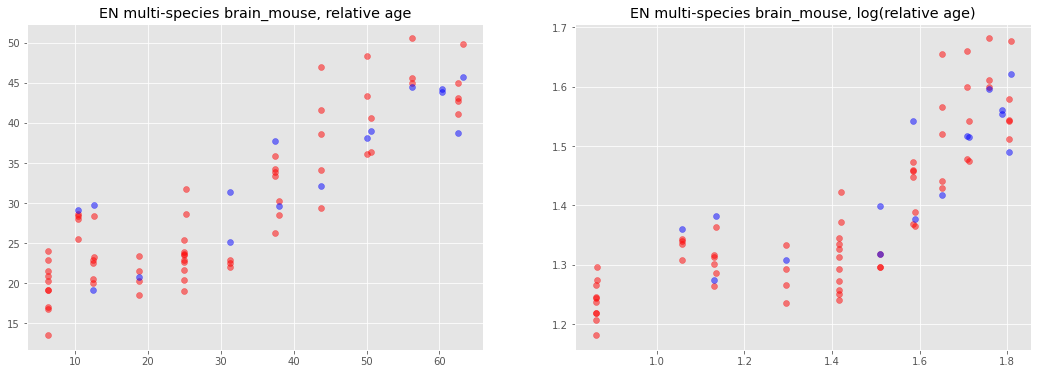

In [1376]:
plt.figure(figsize=(18, 6))

plt.subplot(1,2,1)
plt.grid(True)
plt.scatter(y_rel_train*100, grid_model_norm_brain_mouse.predict(X_norm_train)*100, alpha=0.5, color = 'red')
plt.scatter(y_rel_test*100, grid_model_norm_brain_mouse.predict(X_norm_test)*100, alpha=0.5, color = 'blue')
plt.title('EN brain mouse, relative age')

plt.subplot(1,2,2)
plt.grid(True)
plt.scatter(np.log10(y_rel_train*100+1), 
            grid_model_norm_log_brain_mouse.predict(X_norm_train), alpha=0.5, color = 'red')
plt.scatter(np.log10(y_rel_test*100+1), 
            grid_model_norm_log_brain_mouse.predict(X_norm_test), alpha=0.5, color = 'blue')
plt.title('EN brain mouse, log(relative age)')

Very bad: R2 = 48% and 34%

Scaled data

In [1377]:
grid_model_scale_brain_mouse = run_ML_model_LOGO_group(X_scaled_train,y_rel_train,
                                                 X_scaled_test,y_rel_test,
                                               groups,param_grid,model_type="EN",
                                                       scoring='neg_mean_absolute_error')

Alpha: 
0.0001
l1 ratio: 
0.6000000000000001
MAE: 
0.000991576128852528
0.06578451113573355
R2: 
0.999938776729966
0.8021310805749826


In [1378]:
grid_model_scale_log_brain_mouse = run_ML_model_LOGO_group(X_scaled_train,np.log10(y_rel_train*100+1),
                                                    X_scaled_test,np.log10(y_rel_test*100+1),
                                               groups,param_grid,model_type="EN",
                                                           scoring='neg_mean_absolute_error')

Alpha: 
0.001
l1 ratio: 
0.6000000000000001
MAE: 
0.00960563683613694
0.09096550659435933
R2: 
0.9984292224314399
0.7423948361260708


Text(0.5, 1.0, 'EN multi-species brain_mouse, log(relative age)')

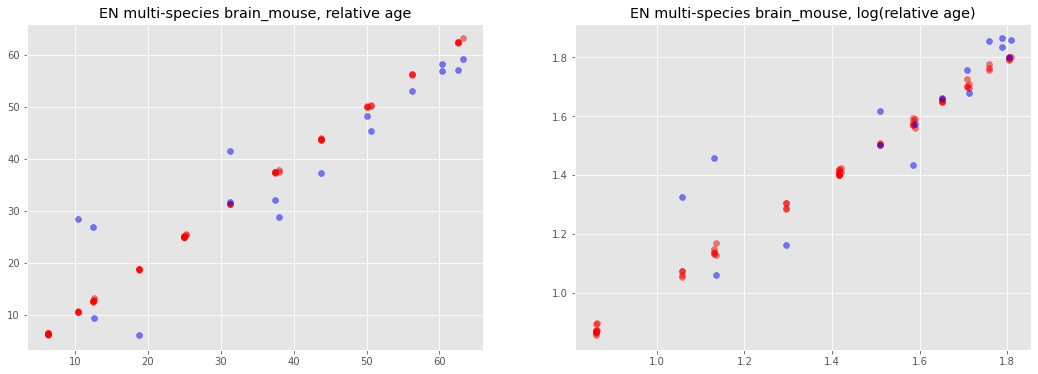

In [1379]:
plt.figure(figsize=(18, 6))

plt.subplot(1,2,1)
plt.grid(True)
plt.scatter(y_rel_train*100, grid_model_scale_brain_mouse.predict(X_scaled_train)*100,
            alpha=0.5, color = 'red')
plt.scatter(y_rel_test*100, grid_model_scale_brain_mouse.predict(X_scaled_test)*100,
            alpha=0.5, color = 'blue')
plt.title('EN brain mouse, relative age')

plt.subplot(1,2,2)
plt.grid(True)
plt.scatter(np.log10(y_rel_train*100+1), 
            grid_model_scale_log_brain_mouse.predict(X_scaled_train), alpha=0.5, color = 'red')
plt.scatter(np.log10(y_rel_test*100+1), 
            grid_model_scale_log_brain_mouse.predict(X_scaled_test), alpha=0.5, color = 'blue')
plt.title('EN brain mouse, log(relative age)')

R2 = 80% and 74%, MAE = 0.09 (~25% error)

## Mouse Kidney

In [1436]:
temp_tissue = "Kidney"
temp_species = "Mouse"

In [1437]:
(X_norm_train, y_train, y_rel_train,
X_norm_test, y_test, y_rel_test, groups) = get_train_and_test_data(data_normalized,temp_tissue,temp_species,
                                                                  categorical_cols=[],random_state=6,corr_threshold=0,
                                                                  na_percentage_thresh=0.15)

(X_scaled_train, y_train, y_rel_train,
X_scaled_test, y_test, y_rel_test, groups) = get_train_and_test_data(data_scaled,temp_tissue,temp_species,
                                                                  categorical_cols=[],random_state=6,corr_threshold=0,
                                                                    na_percentage_thresh=0.15)

(66, 11106)
(17, 11106)
20.481927710843372
11106
(66, 11106)
(17, 11106)
20.481927710843372
11106


#### Run elastic net model

In [1439]:
param_grid = {'alpha': np.logspace(-4,3,6),
             'l1_ratio': np.linspace(0,1,6)}

Normalized data

In [1389]:
%%time
grid_model_norm_kidney_mouse = run_ML_model_LOGO_group(X_norm_train,y_rel_train,
                                                X_norm_test,y_rel_test,
                                               groups,param_grid,model_type="EN",
                                                       scoring='neg_mean_absolute_error')

Alpha: 
0.1
l1 ratio: 
0.2
MAE: 
0.08811017710087911
0.06058794289045794
R2: 
0.6328766378277488
0.7108747328696868
Wall time: 18.3 s


In [1390]:
%%time
grid_model_norm_log_kidney_mouse = run_ML_model_LOGO_group(X_norm_train,np.log10(y_rel_train*100+1),
                                                    X_norm_test,np.log10(y_rel_test*100+1),
                                               groups,param_grid,model_type="EN",
                                                           scoring='neg_mean_absolute_error')

Alpha: 
0.1
l1 ratio: 
0.2
MAE: 
0.12197658461307079
0.09794077763742903
R2: 
0.7269487006042991
0.8062141510237453
Wall time: 18.6 s


Text(0.5, 1.0, 'EN multi-species kidney_mouse, log(relative age)')

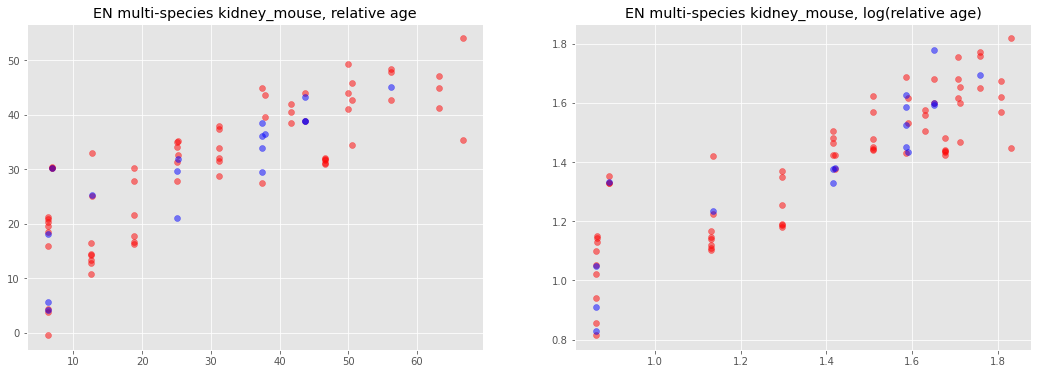

In [1391]:
plt.figure(figsize=(18, 6))

plt.subplot(1,2,1)
plt.grid(True)
plt.scatter(y_rel_train*100, grid_model_norm_kidney_mouse.predict(X_norm_train)*100, alpha=0.5, color = 'red')
plt.scatter(y_rel_test*100, grid_model_norm_kidney_mouse.predict(X_norm_test)*100, alpha=0.5, color = 'blue')
plt.title('EN kidney mouse, relative age')

plt.subplot(1,2,2)
plt.grid(True)
plt.scatter(np.log10(y_rel_train*100+1), 
            grid_model_norm_log_kidney_mouse.predict(X_norm_train), alpha=0.5, color = 'red')
plt.scatter(np.log10(y_rel_test*100+1), 
            grid_model_norm_log_kidney_mouse.predict(X_norm_test), alpha=0.5, color = 'blue')
plt.title('EN kidney mouse, log(relative age)')

Very bad: R2 = 72% and 81%

Scaled data

In [1440]:
grid_model_scale_kidney_mouse = run_ML_model_LOGO_group(X_scaled_train,y_rel_train,
                                                 X_scaled_test,y_rel_test,
                                               groups,param_grid,model_type="EN",
                                                        scoring='neg_mean_absolute_error')

Alpha: 
0.0630957344480193
l1 ratio: 
0.2
MAE: 
0.07404539851134884
0.05704288773222068
R2: 
0.7299626579224545
0.7630256940232263


In [1441]:
grid_model_scale_log_kidney_mouse = run_ML_model_LOGO_group(X_scaled_train,np.log10(y_rel_train*100+1),
                                                    X_scaled_test,np.log10(y_rel_test*100+1),
                                               groups,param_grid,model_type="EN",
                                                            scoring='neg_mean_absolute_error')

Alpha: 
0.0630957344480193
l1 ratio: 
0.2
MAE: 
0.09822787917239678
0.10094578706782001
R2: 
0.83176831569361
0.8392444321254948


Text(0.5, 1.0, 'EN kidney mouse, log(relative age)')

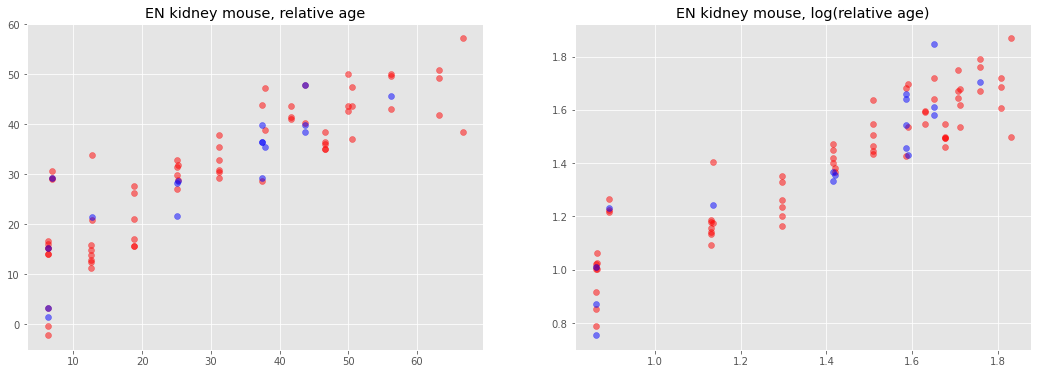

In [1442]:
plt.figure(figsize=(18, 6))

plt.subplot(1,2,1)
plt.grid(True)
plt.scatter(y_rel_train*100, grid_model_scale_kidney_mouse.predict(X_scaled_train)*100,
            alpha=0.5, color = 'red')
plt.scatter(y_rel_test*100, grid_model_scale_kidney_mouse.predict(X_scaled_test)*100,
            alpha=0.5, color = 'blue')
plt.title('EN kidney mouse, relative age')

plt.subplot(1,2,2)
plt.grid(True)
plt.scatter(np.log10(y_rel_train*100+1), 
            grid_model_scale_log_kidney_mouse.predict(X_scaled_train), alpha=0.5, color = 'red')
plt.scatter(np.log10(y_rel_test*100+1), 
            grid_model_scale_log_kidney_mouse.predict(X_scaled_test), alpha=0.5, color = 'blue')
plt.title('EN kidney mouse, log(relative age)')

R2 = 76% and 84%, MAE = 0.1 (~30% error)

## Multi-species tissue clocks

## Liver

In [39]:
temp_tissue = "Liver"
temp_species = "All"

In [40]:
(X_norm_train, y_train, y_rel_train,
X_norm_test, y_test, y_rel_test, groups,
X_test_nonnumeric) = get_train_and_test_data(data_normalized,temp_tissue,temp_species,
                                                                  categorical_cols=[],random_state=6,corr_threshold=0,
                                                                  na_percentage_thresh=0.25)

(X_scaled_train, y_train, y_rel_train,
X_scaled_test, y_test, y_rel_test, groups,
X_test_nonnumeric) = get_train_and_test_data(data_scaled,temp_tissue,temp_species,
                                                                  categorical_cols=[],random_state=6,corr_threshold=0,
                                                                    na_percentage_thresh=0.25)

(168, 9206)
(43, 9206)
20.379146919431278
9206
(168, 9206)
(43, 9206)
20.379146919431278
9206


#### Run elastic net model

In [41]:
param_grid = {'alpha': np.logspace(-5,3,6),
             'l1_ratio': np.linspace(0,1,6)}
param_grid = {'alpha': np.logspace(-3,2,5),
             'l1_ratio': np.linspace(0,1,6)}

Normalized data

In [42]:
%%time
grid_model_norm_liver = run_ML_model_LOGO_group(X_norm_train,y_rel_train,
                                                X_norm_test,y_rel_test,
                                               groups,param_grid,model_type="EN",scoring='neg_mean_absolute_error')

Best parameters:
{'alpha': 0.01, 'l1_ratio': 0.0}
Best average cross-validation score:
{'alpha': 0.01, 'l1_ratio': 0.0}
MAE: 
0.0008596703784004018
0.06122103481393142
R2: 
0.9999528925391163
0.816828068260321
Wall time: 43.2 s


In [110]:
%%time
grid_model_norm_log_liver = run_ML_model_LOGO_group(X_norm_train,np.log10(y_rel_train*100+1),
                                                    X_norm_test,np.log10(y_rel_test*100+1),
                                               groups,param_grid,model_type="EN",scoring='neg_mean_absolute_error')

Alpha: 
0.001
l1 ratio: 
0.0
MAE: 
0.00013620332297689102
0.09977750755225286
R2: 
0.9999997048949126
0.9119176058981413
Wall time: 38.9 s


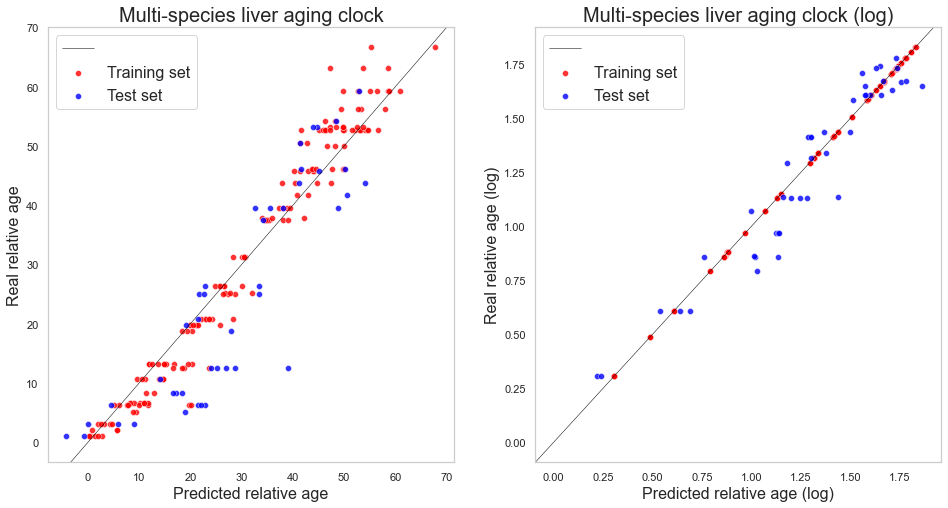

In [112]:
draw_quality_plot(grid_model_norm_liver.predict(X_norm_train)*100,y_rel_train*100,
                 grid_model_norm_liver.predict(X_norm_test)*100,y_rel_test*100,
                 grid_model_norm_log_liver.predict(X_norm_train),np.log10(y_rel_train*100+1),
                 grid_model_norm_log_liver.predict(X_norm_test),np.log10(y_rel_test*100+1),
                 title1='Multi-species liver aging clock',
                 title2='Multi-species liver aging clock (log)')

R2 = 73% and 91%

Scaled data

In [113]:
%%time
grid_model_scale_liver = run_ML_model_LOGO_group(X_scaled_train,y_rel_train,
                                                 X_scaled_test,y_rel_test,
                                               groups,param_grid,model_type="EN",scoring='neg_mean_absolute_error')

Alpha: 
0.1
l1 ratio: 
0.0
MAE: 
0.006655531984429018
0.06026790773510303
R2: 
0.9976694330595153
0.8188344883428867


In [114]:
%%time
grid_model_scale_log_liver = run_ML_model_LOGO_group(X_scaled_train,np.log10(y_rel_train*100+1),
                                                    X_scaled_test,np.log10(y_rel_test*100+1),
                                               groups,param_grid,model_type="EN",scoring='neg_mean_absolute_error')

Alpha: 
0.1
l1 ratio: 
0.0
MAE: 
0.010597907452390958
0.08909280468197653
R2: 
0.9985762372720643
0.9242012992425259


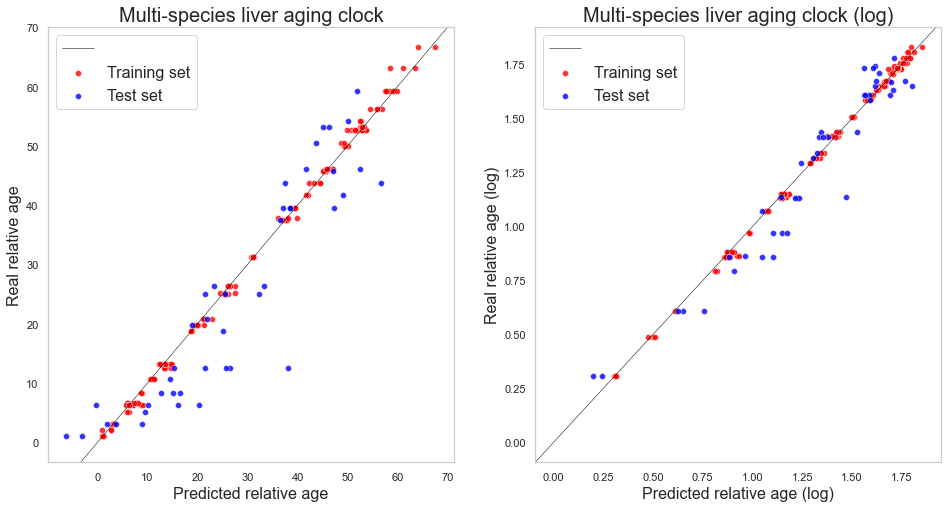

In [115]:
draw_quality_plot(grid_model_scale_liver.predict(X_scaled_train)*100,y_rel_train*100,
                 grid_model_scale_liver.predict(X_scaled_test)*100,y_rel_test*100,
                 grid_model_scale_log_liver.predict(X_scaled_train),np.log10(y_rel_train*100+1),
                 grid_model_scale_log_liver.predict(X_scaled_test),np.log10(y_rel_test*100+1),
                 title1='Multi-species liver aging clock',
                 title2='Multi-species liver aging clock (log)')

R2 = 82% and 92.6%, MAE = 0.087 (~25% error)

## Brain

In [1202]:
temp_tissue = "Brain"
temp_species = "All"

In [1203]:
(X_norm_train, y_train, y_rel_train,
X_norm_test, y_test, y_rel_test, groups) = get_train_and_test_data(data_normalized,temp_tissue,temp_species,
                                                                  categorical_cols=[],random_state=6,corr_threshold=0,
                                                                  na_percentage_thresh=0.05)

(X_scaled_train, y_train, y_rel_train,
X_scaled_test, y_test, y_rel_test, groups) = get_train_and_test_data(data_scaled,temp_tissue,temp_species,
                                                                  categorical_cols=[],random_state=6,corr_threshold=0,
                                                                    na_percentage_thresh=0.05)

(952, 9284)
(238, 9284)
20.0
9284
(952, 9284)
(238, 9284)
20.0
9284


#### Run elastic net model

In [1204]:
param_grid = {'alpha': np.logspace(-5,3,6),
             'l1_ratio': np.linspace(0,1,6)}

Normalized data

In [1207]:
%%time
grid_model_norm_brain = run_ML_model_LOGO_group(X_norm_train,y_rel_train,
                                                X_norm_test,y_rel_test,
                                               groups,param_grid,model_type="EN",scoring='neg_mean_absolute_error')

Alpha: 
0.6309573444801942
l1 ratio: 
0.0
MAE: 
0.05139308214289362
0.08238448108699153
R2: 
0.901714693344675
0.7459023555278295
Wall time: 6min 6s


In [1208]:
%%time
grid_model_norm_log_brain = run_ML_model_LOGO_group(X_norm_train,np.log10(y_rel_train*100+1),
                                                    X_norm_test,np.log10(y_rel_test*100+1),
                                               groups,param_grid,model_type="EN",scoring='neg_mean_absolute_error')

Alpha: 
1e-05
l1 ratio: 
0.0
MAE: 
1.1997573574560566e-05
0.11382546499887691
R2: 
0.9999999968588068
0.7614511425923532
Wall time: 6min 34s


Text(0.5, 1.0, 'EN multi-species brain, log(relative age)')

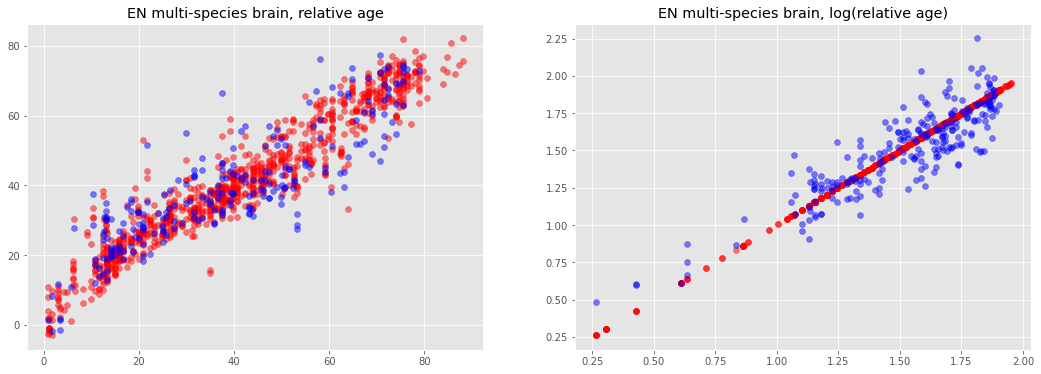

In [1209]:
plt.figure(figsize=(18, 6))

plt.subplot(1,2,1)
plt.grid(True)
plt.scatter(y_rel_train*100, grid_model_norm_brain.predict(X_norm_train)*100, alpha=0.5, color = 'red')
plt.scatter(y_rel_test*100, grid_model_norm_brain.predict(X_norm_test)*100, alpha=0.5, color = 'blue')
plt.title('EN multi-species brain, relative age')

plt.subplot(1,2,2)
plt.grid(True)
plt.scatter(np.log10(y_rel_train*100+1), 
            grid_model_norm_log_brain.predict(X_norm_train), alpha=0.5, color = 'red')
plt.scatter(np.log10(y_rel_test*100+1), 
            grid_model_norm_log_brain.predict(X_norm_test), alpha=0.5, color = 'blue')
plt.title('EN multi-species brain, log(relative age)')

R2 = 80.3% and 80.8%

Scaled data

In [1205]:
grid_model_scale_brain = run_ML_model_LOGO_group(X_scaled_train,y_rel_train,
                                                 X_scaled_test,y_rel_test,
                                               groups,param_grid,model_type="EN",scoring='neg_mean_absolute_error')

Alpha: 
0.00039810717055349735
l1 ratio: 
0.4
MAE: 
0.019229062473978056
0.05745569583356288
R2: 
0.9863210265138068
0.8614963767974015


In [1206]:
grid_model_scale_log_brain = run_ML_model_LOGO_group(X_scaled_train,np.log10(y_rel_train*100+1),
                                                    X_scaled_test,np.log10(y_rel_test*100+1),
                                               groups,param_grid,model_type="EN",scoring='neg_mean_absolute_error')

Alpha: 
0.00039810717055349735
l1 ratio: 
0.4
MAE: 
0.01950921278814235
0.07371058569242463
R2: 
0.9931682805537215
0.8896834132494477


Text(0.5, 1.0, 'EN multi-species brain, log(relative age)')

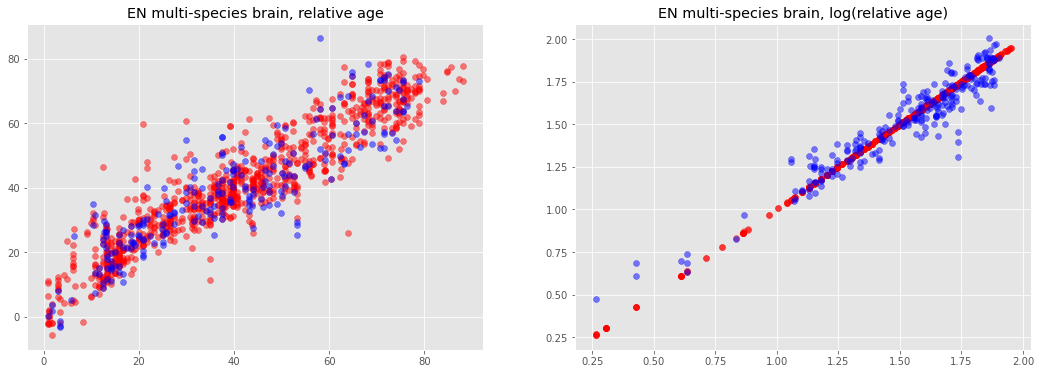

In [1187]:
plt.figure(figsize=(18, 6))

plt.subplot(1,2,1)
plt.grid(True)
plt.scatter(y_rel_train*100, grid_model_scale_brain.predict(X_scaled_train)*100,
            alpha=0.5, color = 'red')
plt.scatter(y_rel_test*100, grid_model_scale_brain.predict(X_scaled_test)*100,
            alpha=0.5, color = 'blue')
plt.title('EN multi-species brain, relative age')

plt.subplot(1,2,2)
plt.grid(True)
plt.scatter(np.log10(y_rel_train*100+1), 
            grid_model_scale_log_brain.predict(X_scaled_train), alpha=0.5, color = 'red')
plt.scatter(np.log10(y_rel_test*100+1), 
            grid_model_scale_log_brain.predict(X_scaled_test), alpha=0.5, color = 'blue')
plt.title('EN multi-species brain, log(relative age)')

R2 = 79% and 90.5%, MAE = 0.068 (~17% error)

## Muscle

In [1210]:
temp_tissue = "Muscle"
temp_species = "All"

In [1235]:
(X_norm_train, y_train, y_rel_train,
X_norm_test, y_test, y_rel_test, groups) = get_train_and_test_data(data_normalized,temp_tissue,temp_species,
                                                                  categorical_cols=[],random_state=2,corr_threshold=0,
                                                                  na_percentage_thresh=0.1)

(X_scaled_train, y_train, y_rel_train,
X_scaled_test, y_test, y_rel_test, groups) = get_train_and_test_data(data_scaled,temp_tissue,temp_species,
                                                                  categorical_cols=[],random_state=2,corr_threshold=0,
                                                                    na_percentage_thresh=0.1)

(133, 5283)
(34, 5283)
20.35928143712575
5283
(133, 5283)
(34, 5283)
20.35928143712575
5283


#### Run elastic net model

In [1236]:
param_grid = {'alpha': np.logspace(-5,3,9),
             'l1_ratio': np.linspace(0,1,6)}

Normalized data

In [1241]:
%%time
grid_model_norm_muscle = run_ML_model_LOGO_group(X_norm_train,y_rel_train,
                                                X_norm_test,y_rel_test,
                                               groups,param_grid,model_type="EN",scoring='neg_mean_absolute_error')

Alpha: 
0.001
l1 ratio: 
0.4
MAE: 
0.009208130517181673
0.09909120853845993
R2: 
0.9960030808469446
0.7015487084087675
Wall time: 21.4 s


In [1242]:
%%time
grid_model_norm_log_muscle = run_ML_model_LOGO_group(X_norm_train,np.log10(y_rel_train*100+1),
                                                    X_norm_test,np.log10(y_rel_test*100+1),
                                               groups,param_grid,model_type="EN",scoring='neg_mean_absolute_error')

Alpha: 
1e-05
l1 ratio: 
0.0
MAE: 
3.32814956381123e-06
0.1930450537531481
R2: 
0.99999999979588
0.7238031267429579
Wall time: 20 s


Text(0.5, 1.0, 'EN multi-species muscle, log(relative age)')

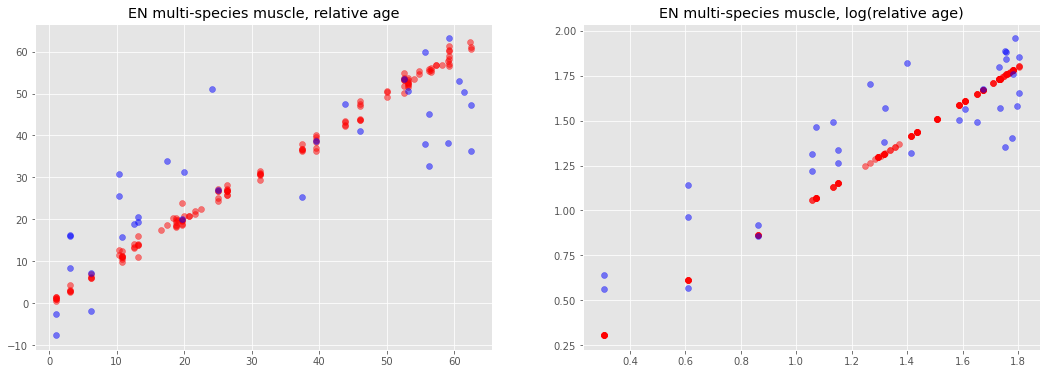

In [1243]:
plt.figure(figsize=(18, 6))

plt.subplot(1,2,1)
plt.grid(True)
plt.scatter(y_rel_train*100, grid_model_norm_muscle.predict(X_norm_train)*100, alpha=0.5, color = 'red')
plt.scatter(y_rel_test*100, grid_model_norm_muscle.predict(X_norm_test)*100, alpha=0.5, color = 'blue')
plt.title('EN multi-species muscle, relative age')

plt.subplot(1,2,2)
plt.grid(True)
plt.scatter(np.log10(y_rel_train*100+1), 
            grid_model_norm_log_muscle.predict(X_norm_train), alpha=0.5, color = 'red')
plt.scatter(np.log10(y_rel_test*100+1), 
            grid_model_norm_log_muscle.predict(X_norm_test), alpha=0.5, color = 'blue')
plt.title('EN multi-species muscle, log(relative age)')

R2 = 70% and 72%

Scaled data

In [1237]:
grid_model_scale_muscle = run_ML_model_LOGO_group(X_scaled_train,y_rel_train,
                                                 X_scaled_test,y_rel_test,
                                               groups,param_grid,model_type="EN",scoring='neg_mean_absolute_error')

Alpha: 
0.01
l1 ratio: 
0.6000000000000001
MAE: 
0.05465704681449398
0.09510694260192692
R2: 
0.8641858090434779
0.7364357971883237


In [1238]:
grid_model_scale_log_muscle = run_ML_model_LOGO_group(X_scaled_train,np.log10(y_rel_train*100+1),
                                                    X_scaled_test,np.log10(y_rel_test*100+1),
                                               groups,param_grid,model_type="EN",scoring='neg_mean_absolute_error')

Alpha: 
0.1
l1 ratio: 
0.0
MAE: 
0.010653535239854376
0.13133611856389282
R2: 
0.9986011770686061
0.8919368623607862


Text(0.5, 1.0, 'EN multi-species muscle, log(relative age)')

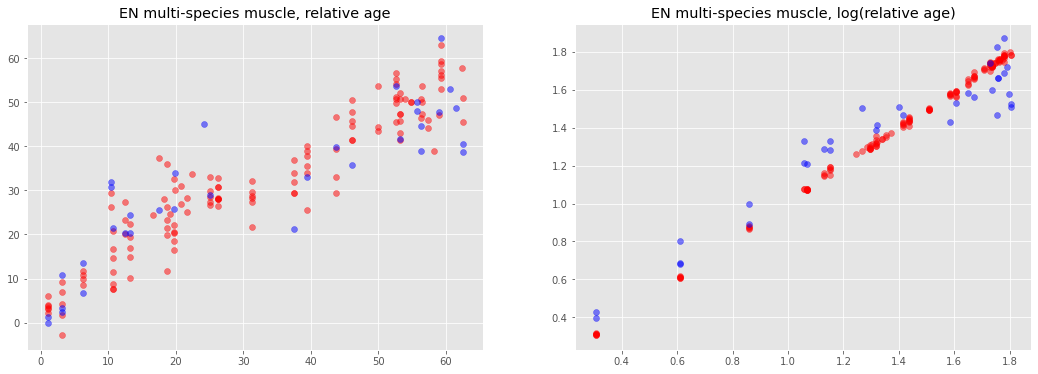

In [1240]:
plt.figure(figsize=(18, 6))

plt.subplot(1,2,1)
plt.grid(True)
plt.scatter(y_rel_train*100, grid_model_scale_muscle.predict(X_scaled_train)*100,
            alpha=0.5, color = 'red')
plt.scatter(y_rel_test*100, grid_model_scale_muscle.predict(X_scaled_test)*100,
            alpha=0.5, color = 'blue')
plt.title('EN multi-species muscle, relative age')

plt.subplot(1,2,2)
plt.grid(True)
plt.scatter(np.log10(y_rel_train*100+1), 
            grid_model_scale_log_muscle.predict(X_scaled_train), alpha=0.5, color = 'red')
plt.scatter(np.log10(y_rel_test*100+1), 
            grid_model_scale_log_muscle.predict(X_scaled_test), alpha=0.5, color = 'blue')
plt.title('EN multi-species muscle, log(relative age)')

R2 = 74% and 89%, MAE = 0.13 (~35% error)

## Multi-tissue species clocks

## Mouse

In [116]:
temp_tissue = "All"
temp_species = "Mouse"

In [117]:
(X_norm_train, y_train, y_rel_train,
X_norm_test, y_test, y_rel_test, groups,
X_test_nonnumeric) = get_train_and_test_data(data_normalized,temp_tissue,temp_species,
                                                                  categorical_cols=[],random_state=6,corr_threshold=0,
                                                                  na_percentage_thresh=0.25)

(X_scaled_train, y_train, y_rel_train,
X_scaled_test, y_test, y_rel_test, groups,
X_test_nonnumeric) = get_train_and_test_data(data_scaled,temp_tissue,temp_species,
                                                                  categorical_cols=[],random_state=6,corr_threshold=0,
                                                                    na_percentage_thresh=0.25)

(780, 9563)
(196, 9563)
20.081967213114755
9563
(780, 9563)
(196, 9563)
20.081967213114755
9563


#### Run elastic net model

In [118]:
param_grid = {'alpha': np.logspace(-2,1,4),
             'l1_ratio': np.linspace(0,1,6)}

Normalized data

In [119]:
%%time
grid_model_norm_mouse = run_ML_model_LOGO_group(X_norm_train,y_rel_train,
                                                X_norm_test,y_rel_test,
                                               groups,param_grid,model_type="EN",scoring='neg_mean_absolute_error')

Alpha: 
10.0
l1 ratio: 
0.0
MAE: 
0.11471717566818268
0.11339060451973793
R2: 
0.36994982568301904
0.26768940750745884
Wall time: 1min 40s


In [120]:
%%time
grid_model_norm_log_mouse = run_ML_model_LOGO_group(X_norm_train,np.log10(y_rel_train*100+1),
                                                    X_norm_test,np.log10(y_rel_test*100+1),
                                               groups,param_grid,model_type="EN",scoring='neg_mean_absolute_error')

Alpha: 
0.01
l1 ratio: 
0.2
MAE: 
0.08875030778792509
0.11467001653157938
R2: 
0.8493784873610966
0.7463661106052711
Wall time: 1min 47s


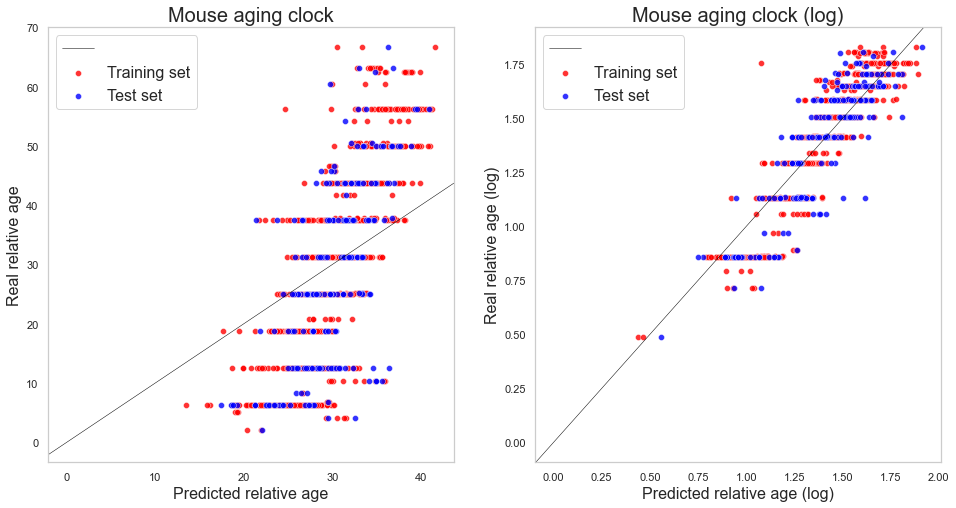

In [121]:
draw_quality_plot(grid_model_norm_mouse.predict(X_norm_train)*100,y_rel_train*100,
                 grid_model_norm_mouse.predict(X_norm_test)*100,y_rel_test*100,
                 grid_model_norm_log_mouse.predict(X_norm_train),np.log10(y_rel_train*100+1),
                 grid_model_norm_log_mouse.predict(X_norm_test),np.log10(y_rel_test*100+1),
                 title1='Mouse aging clock',
                 title2='Mouse aging clock (log)')

R2 = 27% and 75%

In [122]:
%%time
grid_model_scale_mouse = run_ML_model_LOGO_group(X_scaled_train,y_rel_train,
                                                 X_scaled_test,y_rel_test,
                                               groups,param_grid,model_type="EN",scoring='neg_mean_absolute_error')

Alpha: 
10.0
l1 ratio: 
0.0
MAE: 
0.1153078456846986
0.11353103824436606
R2: 
0.36400575926459044
0.26703593673087955


In [123]:
%%time
grid_model_scale_log_mouse = run_ML_model_LOGO_group(X_scaled_train,np.log10(y_rel_train*100+1),
                                                    X_scaled_test,np.log10(y_rel_test*100+1),
                                               groups,param_grid,model_type="EN",scoring='neg_mean_absolute_error')

Alpha: 
0.01
l1 ratio: 
0.2
MAE: 
0.09196348403828578
0.1103904720882533
R2: 
0.8418962361804216
0.766067200047594


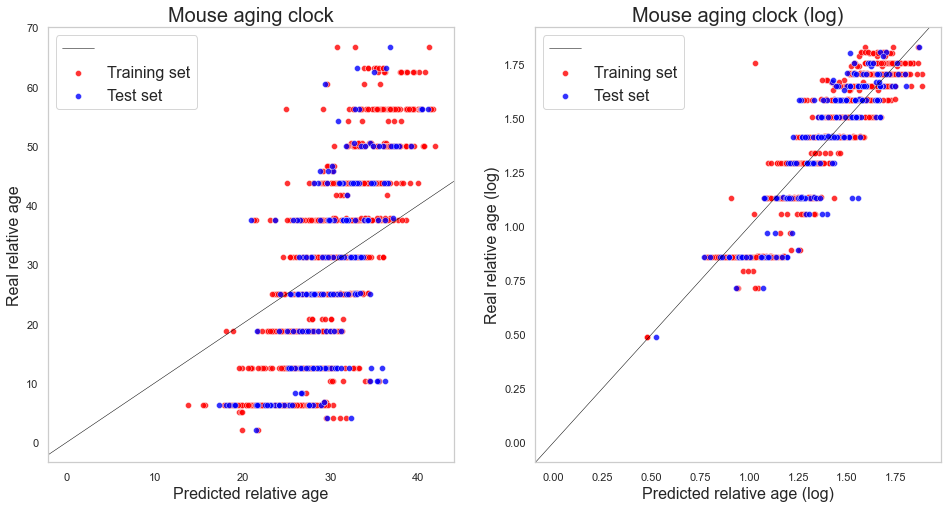

In [124]:
draw_quality_plot(grid_model_scale_mouse.predict(X_scaled_train)*100,y_rel_train*100,
                 grid_model_scale_mouse.predict(X_scaled_test)*100,y_rel_test*100,
                 grid_model_scale_log_mouse.predict(X_scaled_train),np.log10(y_rel_train*100+1),
                 grid_model_scale_log_mouse.predict(X_scaled_test),np.log10(y_rel_test*100+1),
                 title1='Mouse aging clock',
                 title2='Mouse aging clock (log)')

R2 = 26.7% and 76.6%, MAE = 0.11 (~25% error)

## Rat

In [1281]:
temp_tissue = "All"
temp_species = "Rat"

In [1303]:
(X_norm_train, y_train, y_rel_train,
X_norm_test, y_test, y_rel_test, groups) = get_train_and_test_data(data_normalized,temp_tissue,temp_species,
                                                                  categorical_cols=[],random_state=6,corr_threshold=0,
                                                                  na_percentage_thresh=0.05)

(X_scaled_train, y_train, y_rel_train,
X_scaled_test, y_test, y_rel_test, groups) = get_train_and_test_data(data_scaled,temp_tissue,temp_species,
                                                                  categorical_cols=[],random_state=6,corr_threshold=0,
                                                                    na_percentage_thresh=0.05)

(362, 7493)
(91, 7493)
20.08830022075055
7493
(362, 7493)
(91, 7493)
20.08830022075055
7493


#### Run elastic net model

In [1304]:
param_grid = {'alpha': np.logspace(-5,3,6),
             'l1_ratio': np.linspace(0,1,6)}

Normalized data

In [1306]:
%%time
grid_model_norm_rat = run_ML_model_LOGO_group(X_norm_train,y_rel_train,
                                                X_norm_test,y_rel_test,
                                               groups,param_grid,model_type="EN",scoring='neg_mean_absolute_error')

Alpha: 
0.6309573444801942
l1 ratio: 
0.0
MAE: 
0.054302615112162465
0.09275972272548734
R2: 
0.8797957511751519
0.6940115322159943
Wall time: 39.3 s


In [1305]:
%%time
grid_model_norm_log_rat = run_ML_model_LOGO_group(X_norm_train,np.log10(y_rel_train*100+1),
                                                    X_norm_test,np.log10(y_rel_test*100+1),
                                               groups,param_grid,model_type="EN",scoring='neg_mean_absolute_error')

Alpha: 
0.01584893192461114
l1 ratio: 
0.0
MAE: 
0.008688987883309072
0.12592011859256852
R2: 
0.9990556505202124
0.879533480541317
Wall time: 39.9 s


Text(0.5, 1.0, 'EN multi-tissue rat, log(relative age)')

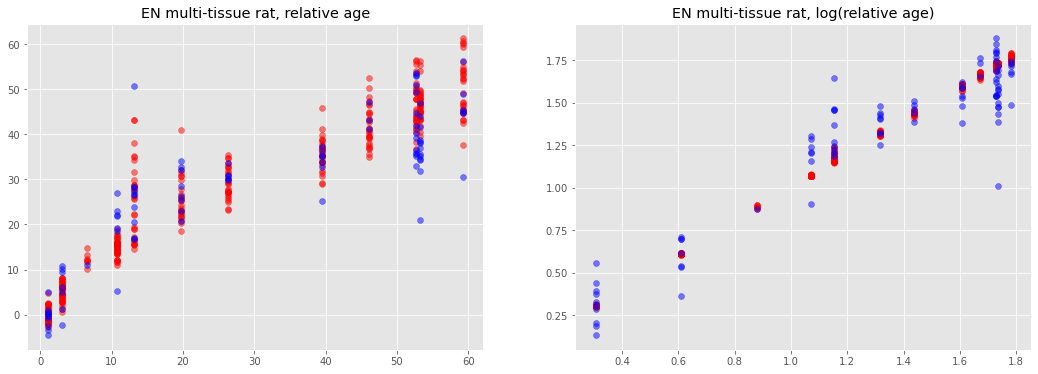

In [1307]:
plt.figure(figsize=(18, 6))

plt.subplot(1,2,1)
plt.grid(True)
plt.scatter(y_rel_train*100, grid_model_norm_rat.predict(X_norm_train)*100, alpha=0.5, color = 'red')
plt.scatter(y_rel_test*100, grid_model_norm_rat.predict(X_norm_test)*100, alpha=0.5, color = 'blue')
plt.title('EN multi-tissue rat, relative age')

plt.subplot(1,2,2)
plt.grid(True)
plt.scatter(np.log10(y_rel_train*100+1), 
            grid_model_norm_log_rat.predict(X_norm_train), alpha=0.5, color = 'red')
plt.scatter(np.log10(y_rel_test*100+1), 
            grid_model_norm_log_rat.predict(X_norm_test), alpha=0.5, color = 'blue')
plt.title('EN multi-tissue rat, log(relative age)')

R2 = 69.4% and 88%

Scaled data

In [1308]:
grid_model_scale_rat = run_ML_model_LOGO_group(X_scaled_train,y_rel_train,
                                                 X_scaled_test,y_rel_test,
                                               groups,param_grid,model_type="EN",scoring='neg_mean_absolute_error')

Alpha: 
0.6309573444801942
l1 ratio: 
0.0
MAE: 
0.053601466985390665
0.09235386560802705
R2: 
0.8823563149083083
0.6944522840455192


In [1309]:
grid_model_scale_log_rat = run_ML_model_LOGO_group(X_scaled_train,np.log10(y_rel_train*100+1),
                                                    X_scaled_test,np.log10(y_rel_test*100+1),
                                               groups,param_grid,model_type="EN",scoring='neg_mean_absolute_error')

Alpha: 
0.00039810717055349735
l1 ratio: 
0.0
MAE: 
0.0003068521816752797
0.14606802483095466
R2: 
0.9999987300086789
0.8410671748157099


Text(0.5, 1.0, 'EN multi-tissue rat, log(relative age)')

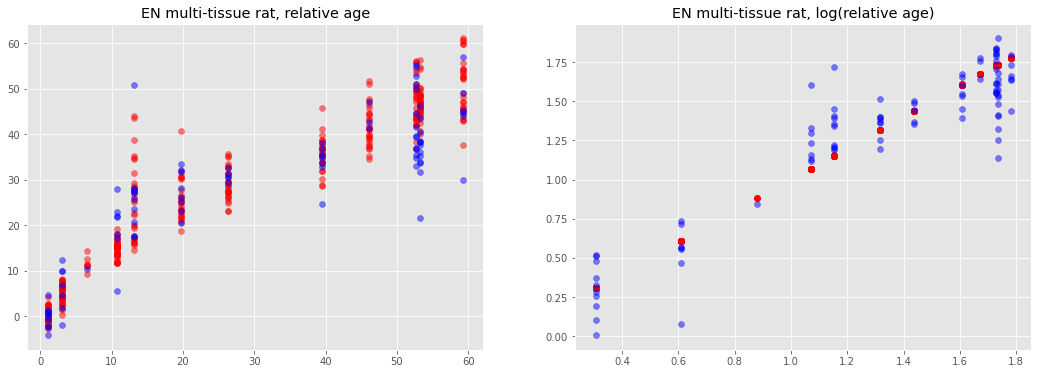

In [1310]:
plt.figure(figsize=(18, 6))

plt.subplot(1,2,1)
plt.grid(True)
plt.scatter(y_rel_train*100, grid_model_scale_rat.predict(X_scaled_train)*100,
            alpha=0.5, color = 'red')
plt.scatter(y_rel_test*100, grid_model_scale_rat.predict(X_scaled_test)*100,
            alpha=0.5, color = 'blue')
plt.title('EN multi-tissue rat, relative age')

plt.subplot(1,2,2)
plt.grid(True)
plt.scatter(np.log10(y_rel_train*100+1), 
            grid_model_scale_log_rat.predict(X_scaled_train), alpha=0.5, color = 'red')
plt.scatter(np.log10(y_rel_test*100+1), 
            grid_model_scale_log_rat.predict(X_scaled_test), alpha=0.5, color = 'blue')
plt.title('EN multi-tissue rat, log(relative age)')

R2 = 69.4% and 84.1%, MAE = 0.146 (~35% error)

## Rodents

In [36]:
temp_tissue = "All"
temp_species = "Rodents"

In [37]:
(X_norm_train, y_train, y_rel_train,
X_norm_test, y_test, y_rel_test, groups,
X_test_nonnumeric) = get_train_and_test_data(data_normalized,temp_tissue,temp_species,
                                                                  categorical_cols=[],random_state=6,corr_threshold=0,
                                                                  na_percentage_thresh=0.3,test_size=0.15)

(X_scaled_train, y_train, y_rel_train,
X_scaled_test, y_test, y_rel_test, groups,
X_test_nonnumeric) = get_train_and_test_data(data_scaled,temp_tissue,temp_species,
                                                                  categorical_cols=[],random_state=6,corr_threshold=0,
                                                                    na_percentage_thresh=0.3,test_size=0.15)

(1214, 9135)
(215, 9135)
15.04548635409377
9135
(1214, 9135)
(215, 9135)
15.04548635409377
9135


#### Run elastic net model

In [38]:
param_grid = {'alpha': np.logspace(-3,1,5),
             'l1_ratio': np.linspace(0,1,6)}
param_grid = {'alpha': np.logspace(-2,0,5),
             'l1_ratio': np.linspace(0,0.4,3)}

Normalized data

In [85]:
%%time
grid_model_norm_rodents = run_ML_model_LOGO_group(X_norm_train,y_rel_train,
                                                X_norm_test,y_rel_test,
                                               groups,param_grid,model_type="EN",scoring='neg_mean_absolute_error')

Alpha: 
0.01
l1 ratio: 
0.4
MAE: 
0.09343116453726752
0.10152465091942156
R2: 
0.6171723253224728
0.49174391637658643
Wall time: 3min 23s


In [86]:
%%time
grid_model_norm_log_rodents = run_ML_model_LOGO_group(X_norm_train,np.log10(y_rel_train*100+1),
                                                    X_norm_test,np.log10(y_rel_test*100+1),
                                               groups,param_grid,model_type="EN",scoring='neg_mean_absolute_error')

Alpha: 
0.01
l1 ratio: 
0.2
MAE: 
0.10277817752280972
0.1309536645149927
R2: 
0.8776350290269093
0.7658230920203326
Wall time: 4min 3s


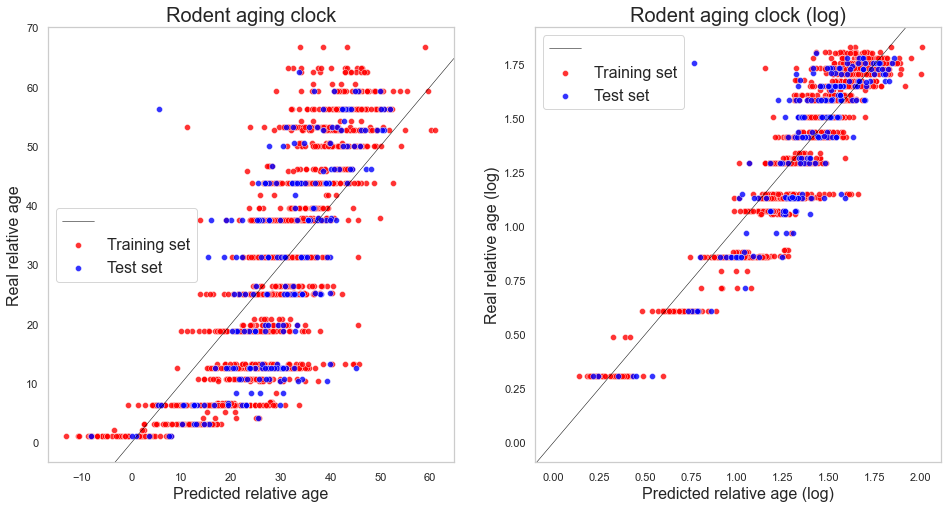

In [87]:
draw_quality_plot(grid_model_norm_rodents.predict(X_norm_train)*100,y_rel_train*100,
                 grid_model_norm_rodents.predict(X_norm_test)*100,y_rel_test*100,
                 grid_model_norm_log_rodents.predict(X_norm_train),np.log10(y_rel_train*100+1),
                 grid_model_norm_log_rodents.predict(X_norm_test),np.log10(y_rel_test*100+1),
                 title1='Rodent aging clock',
                 title2='Rodent aging clock (log)')

R2 = 49% and 77%

Scaled data

In [170]:
%%time
grid_model_scale_rodents = run_ML_model_LOGO_group(X_scaled_train,y_rel_train,
                                                 X_scaled_test,y_rel_test,
                                               groups,param_grid,model_type="EN",scoring='neg_mean_absolute_error')

Alpha: 
0.01
l1 ratio: 
0.4
MAE: 
0.09327509495796969
0.10027413031449654
R2: 
0.6181070240989979
0.508168397636654
Wall time: 3min 24s


In [169]:
%%time
grid_model_scale_log_rodents = run_ML_model_LOGO_group(X_scaled_train,np.log10(y_rel_train*100+1),
                                                    X_scaled_test,np.log10(y_rel_test*100+1),
                                               groups,param_grid,model_type="EN",scoring='neg_mean_absolute_error')

Alpha: 
0.01
l1 ratio: 
0.2
MAE: 
0.10442174848065236
0.1315514238526029
R2: 
0.8750686789096223
0.7656699125111557
Wall time: 3min 36s


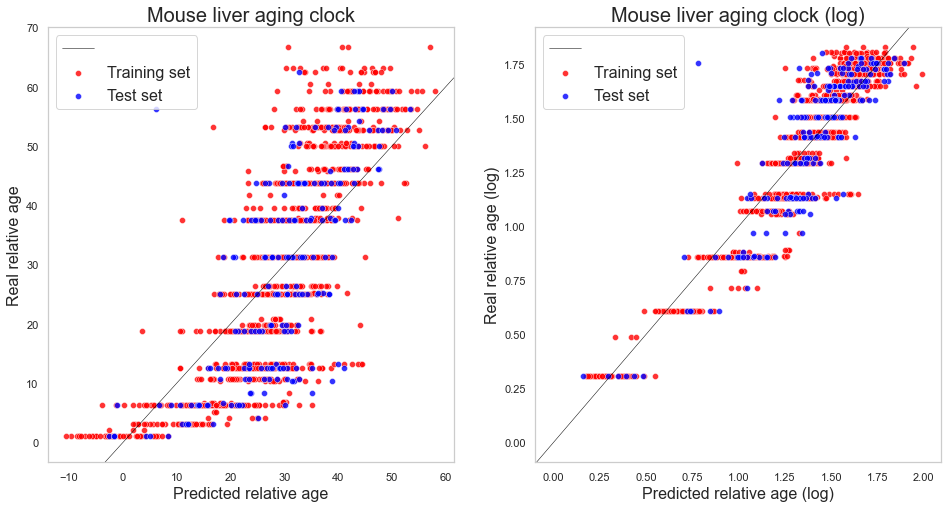

In [171]:
draw_quality_plot(grid_model_scale_rodents.predict(X_scaled_train)*100,y_rel_train*100,
                 grid_model_scale_rodents.predict(X_scaled_test)*100,y_rel_test*100,
                 grid_model_scale_log_rodents.predict(X_scaled_train),np.log10(y_rel_train*100+1),
                 grid_model_scale_log_rodents.predict(X_scaled_test),np.log10(y_rel_test*100+1),
                 title1='Mouse liver aging clock',
                 title2='Mouse liver aging clock (log)')

R2 = 51% and 77%, MAE = 0.13 (~35% error)

## Human

In [1311]:
temp_tissue = "All"
temp_species = "Human"

In [1314]:
(X_norm_train, y_train, y_rel_train,
X_norm_test, y_test, y_rel_test, groups) = get_train_and_test_data(data_normalized,temp_tissue,temp_species,
                                                                  categorical_cols=[],random_state=6,corr_threshold=0,
                                                                  na_percentage_thresh=0.05)

(X_scaled_train, y_train, y_rel_train,
X_scaled_test, y_test, y_rel_test, groups) = get_train_and_test_data(data_scaled,temp_tissue,temp_species,
                                                                  categorical_cols=[],random_state=6,corr_threshold=0,
                                                                    na_percentage_thresh=0.05)

(837, 10548)
(210, 10548)
20.057306590257877
10548
(837, 10548)
(210, 10548)
20.057306590257877
10548


#### Run elastic net model

In [1315]:
param_grid = {'alpha': np.logspace(-5,3,6),
             'l1_ratio': np.linspace(0,1,6)}

Normalized data

In [1316]:
%%time
grid_model_norm_human = run_ML_model_LOGO_group(X_norm_train,y_rel_train,
                                                X_norm_test,y_rel_test,
                                               groups,param_grid,model_type="EN",scoring='neg_mean_absolute_error')

Alpha: 
0.6309573444801942
l1 ratio: 
0.0
MAE: 
0.037805271140523705
0.07734884397624676
R2: 
0.9450844270763412
0.7831873067064781
Wall time: 3min 21s


In [1317]:
%%time
grid_model_norm_log_human = run_ML_model_LOGO_group(X_norm_train,np.log10(y_rel_train*100+1),
                                                    X_norm_test,np.log10(y_rel_test*100+1),
                                               groups,param_grid,model_type="EN",scoring='neg_mean_absolute_error')

Alpha: 
0.6309573444801942
l1 ratio: 
0.0
MAE: 
0.04609293755319954
0.08378155592286816
R2: 
0.9463829487375178
0.8262505087036061
Wall time: 3min 31s


Text(0.5, 1.0, 'EN multi-tissue human, log(relative age)')

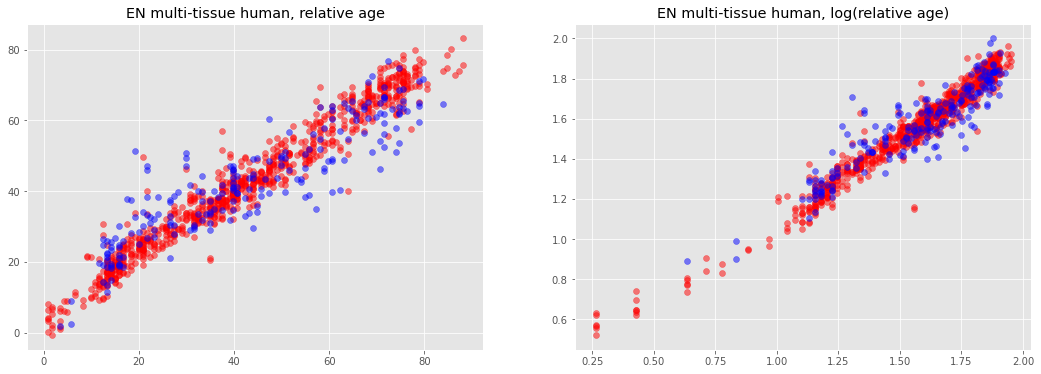

In [1318]:
plt.figure(figsize=(18, 6))

plt.subplot(1,2,1)
plt.grid(True)
plt.scatter(y_rel_train*100, grid_model_norm_human.predict(X_norm_train)*100, alpha=0.5, color = 'red')
plt.scatter(y_rel_test*100, grid_model_norm_human.predict(X_norm_test)*100, alpha=0.5, color = 'blue')
plt.title('EN multi-tissue human, relative age')

plt.subplot(1,2,2)
plt.grid(True)
plt.scatter(np.log10(y_rel_train*100+1), 
            grid_model_norm_log_human.predict(X_norm_train), alpha=0.5, color = 'red')
plt.scatter(np.log10(y_rel_test*100+1), 
            grid_model_norm_log_human.predict(X_norm_test), alpha=0.5, color = 'blue')
plt.title('EN multi-tissue human, log(relative age)')

R2 = 78.3% and 82.6%

Scaled data

In [1319]:
grid_model_scale_human = run_ML_model_LOGO_group(X_scaled_train,y_rel_train,
                                                 X_scaled_test,y_rel_test,
                                               groups,param_grid,model_type="EN",scoring='neg_mean_absolute_error')

Alpha: 
0.6309573444801942
l1 ratio: 
0.0
MAE: 
0.049175917464577085
0.0713726974226595
R2: 
0.9102548722977037
0.8129886534827628


In [1320]:
grid_model_scale_log_human = run_ML_model_LOGO_group(X_scaled_train,np.log10(y_rel_train*100+1),
                                                    X_scaled_test,np.log10(y_rel_test*100+1),
                                               groups,param_grid,model_type="EN",scoring='neg_mean_absolute_error')

Alpha: 
0.6309573444801942
l1 ratio: 
0.0
MAE: 
0.05792288088316584
0.07315851052743863
R2: 
0.9168607643282278
0.8597025304721201


Text(0.5, 1.0, 'EN multi-tissue human, log(relative age)')

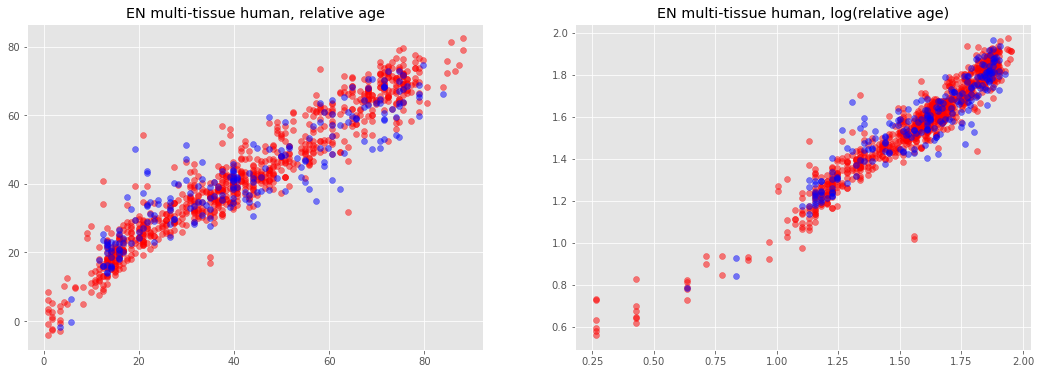

In [1321]:
plt.figure(figsize=(18, 6))

plt.subplot(1,2,1)
plt.grid(True)
plt.scatter(y_rel_train*100, grid_model_scale_human.predict(X_scaled_train)*100,
            alpha=0.5, color = 'red')
plt.scatter(y_rel_test*100, grid_model_scale_human.predict(X_scaled_test)*100,
            alpha=0.5, color = 'blue')
plt.title('EN multi-tissue human, relative age')

plt.subplot(1,2,2)
plt.grid(True)
plt.scatter(np.log10(y_rel_train*100+1), 
            grid_model_scale_log_human.predict(X_scaled_train), alpha=0.5, color = 'red')
plt.scatter(np.log10(y_rel_test*100+1), 
            grid_model_scale_log_human.predict(X_scaled_test), alpha=0.5, color = 'blue')
plt.title('EN multi-tissue human, log(relative age)')

R2 = 81.3% and 86%, MAE = 0.073 (~25% error)

## Multi-tissue multi-species model

In [7]:
temp_tissue = "All"
temp_species = "All"

In [8]:
(X_norm_train, y_train, y_rel_train,
X_norm_test, y_test, y_rel_test, groups,
X_test_data) = get_train_and_test_data(data_normalized,temp_tissue,temp_species,
                                                                  categorical_cols=[],random_state=6,corr_threshold=0,
                                                                  na_percentage_thresh=0.25)

(X_scaled_train, y_train, y_rel_train,
X_scaled_test, y_test, y_rel_test, groups,
X_test_data) = get_train_and_test_data(data_scaled,temp_tissue,temp_species,
                                                                  categorical_cols=[],random_state=6,corr_threshold=0,
                                                                    na_percentage_thresh=0.25)

(1980, 9969)
(496, 9969)
20.032310177705977
9969
(1980, 9969)
(496, 9969)
20.032310177705977
9969


In [9]:
X_test_data.head()

,Sex,GEO,Species,Tissue
SRR8467783,Male,PRJNA516151,Rat,Liver
GSM883195,Male,GSE36192,Human,Brain
GSM1328529,Male,GSE53960,Rat,Brain
GSM882708,Female,GSE36192,Human,Brain
GSM882618,Male,GSE36192,Human,Brain


#### Run elastic net model

In [10]:
param_grid = {'alpha': np.logspace(-2,2,5),
             'l1_ratio': np.linspace(0,1,6)}
param_grid = {'alpha': np.logspace(-1,0,2),
             'l1_ratio': np.linspace(0,0,1)}

Normalized data

In [11]:
%%time
grid_model_norm = run_ML_model_LOGO_group(X_norm_train,y_rel_train,
                                                X_norm_test,y_rel_test,
                                               groups,param_grid,model_type="EN",scoring='neg_mean_absolute_error')

Alpha: 
1.0
l1 ratio: 
0.0
MAE: 
0.079203671187765
0.09861911426534455
R2: 
0.7786289941239841
0.6610375629403287
Wall time: 2min 54s


In [12]:
%%time
grid_model_norm_log = run_ML_model_LOGO_group(X_norm_train,np.log10(y_rel_train*100+1),
                                                    X_norm_test,np.log10(y_rel_test*100+1),
                                               groups,param_grid,model_type="EN",scoring='neg_mean_absolute_error')

Alpha: 
0.1
l1 ratio: 
0.0
MAE: 
0.051773258033457226
0.11244492543088135
R2: 
0.9584579182300573
0.7863028803618719
Wall time: 2min 54s


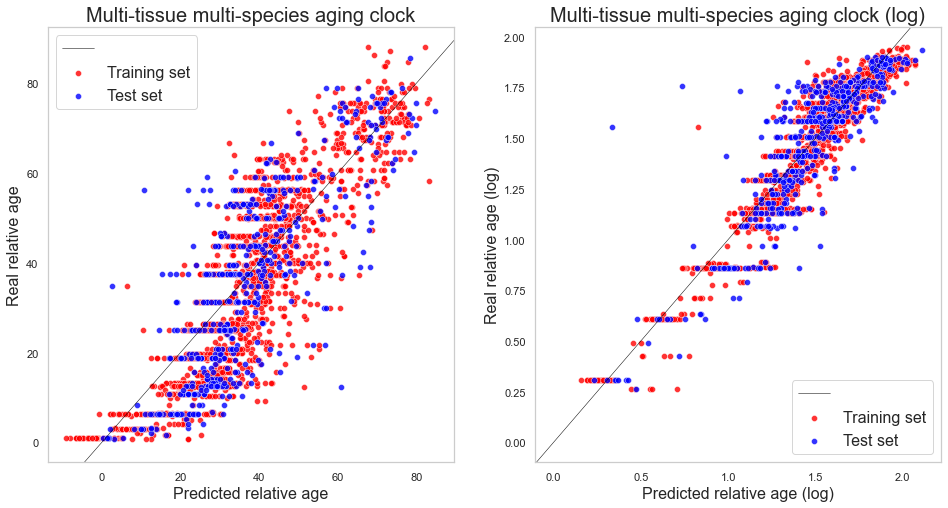

In [45]:
draw_quality_plot(grid_model_norm.predict(X_scaled_train)*100,y_rel_train*100,
                 grid_model_norm.predict(X_scaled_test)*100,y_rel_test*100,
                 grid_model_norm_log.predict(X_scaled_train),np.log10(y_rel_train*100+1),
                 grid_model_norm_log.predict(X_scaled_test),np.log10(y_rel_test*100+1),
                 title1='Multi-tissue multi-species aging clock',
                 title2='Multi-tissue multi-species aging clock (log)')

R2 = 66% and 78.7%

Scaled data

In [14]:
grid_model_scale = run_ML_model_LOGO_group(X_scaled_train,y_rel_train,
                                                 X_scaled_test,y_rel_test,
                                               groups,param_grid,model_type="EN",scoring='neg_mean_absolute_error')

Alpha: 
1.0
l1 ratio: 
0.0
MAE: 
0.0804282361791895
0.09746399215147418
R2: 
0.771901118808034
0.6693885809648796


In [15]:
grid_model_scale_log = run_ML_model_LOGO_group(X_scaled_train,np.log10(y_rel_train*100+1),
                                                    X_scaled_test,np.log10(y_rel_test*100+1),
                                               groups,param_grid,model_type="EN",scoring='neg_mean_absolute_error')

Alpha: 
0.1
l1 ratio: 
0.0
MAE: 
0.05449211198595587
0.10455109928504626
R2: 
0.9548413286744553
0.8021999207149005


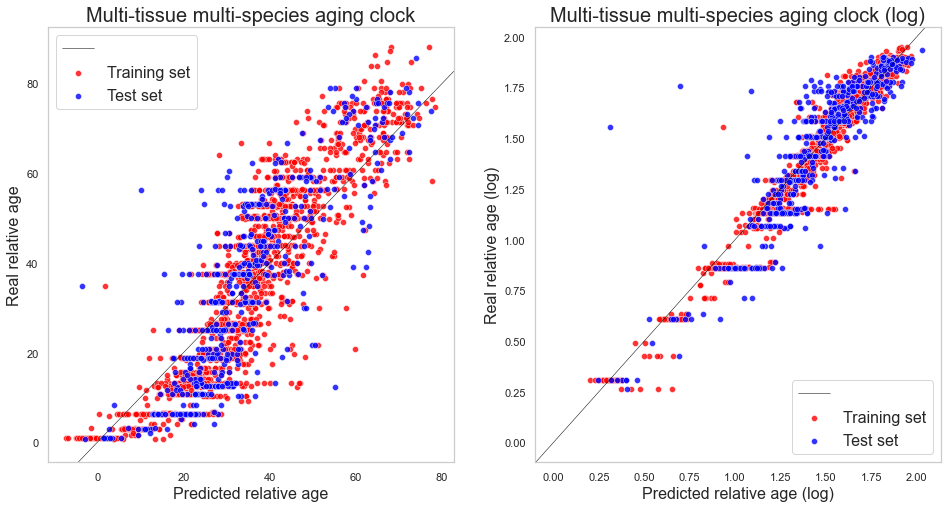

In [44]:
draw_quality_plot(grid_model_scale.predict(X_scaled_train)*100,y_rel_train*100,
                 grid_model_scale.predict(X_scaled_test)*100,y_rel_test*100,
                 grid_model_scale_log.predict(X_scaled_train),np.log10(y_rel_train*100+1),
                 grid_model_scale_log.predict(X_scaled_test),np.log10(y_rel_test*100+1),
                 title1='Multi-tissue multi-species aging clock',
                 title2='Multi-tissue multi-species aging clock (log)')

R2 = 67% and 80%, MAE = 0.1 (~30% error)

### Distribution of tissues and species based on quality (level of MAE)

In [10]:
def draw_quality_boxplot(error_table,chosen_factor,palette=False,filename="temp.pdf",legend_size=18):
    plt.figure(figsize=(10,5))

    sns.set(font_scale=2)
    sns.set_style("whitegrid")
    plt.rcParams["axes.labelsize"] = 20
    plt.rcParams["axes.titlesize"] = 24

    temp = error_table
    plt.grid(True)
    my_pal = palette
    temp['Factor'] = temp[chosen_factor]
    if palette!=False:
        ax = sns.boxplot(x="Model", y="Error", hue="Factor",data=temp,
                 palette=my_pal,linewidth=1.5,width=0.5,saturation=0.5)
    else:
        ax = sns.boxplot(x="Model", y="Error", hue="Factor",data=temp,
                 linewidth=1.5,width=0.5,saturation=0.5)
        
    ax.legend(prop={'size': legend_size})

    # Add transparency to colors
    for patch in ax.artists:
        r, g, b, a = patch.get_facecolor()
        patch.set_facecolor((r, g, b, .9))
        
    plt.title('Quality of age prediction')
    plt.xlabel("Model")
    plt.ylabel("Mean Absolute Error")
    
    plt.savefig(filename, bbox_inches='tight')

In [17]:
X_test_data.head()

,Sex,GEO,Species,Tissue
SRR8467783,Male,PRJNA516151,Rat,Liver
GSM883195,Male,GSE36192,Human,Brain
GSM1328529,Male,GSE53960,Rat,Brain
GSM882708,Female,GSE36192,Human,Brain
GSM882618,Male,GSE36192,Human,Brain


In [79]:
X_test_data.loc[X_test_data['Sex']=="NoSex",:]

,Sex,GEO,Species,Tissue
GSM1630468,NoSex,GSE66715,Rat,Liver
GSM1630467,NoSex,GSE66715,Rat,Liver
GSM1630461,NoSex,GSE66715,Rat,Brain


In [81]:
data_type = "Linear"
error_dataframe_linear = pd.DataFrame(data={'Model':list(np.repeat(data_type,X_test_data.shape[0])),
                                            'Error': np.abs(grid_model_scale.predict(X_scaled_test)*100-(y_rel_test*100)),
                                            'Sex': list(X_test_data['Sex']),
                                            'Species': list(X_test_data['Species']),
                                            'Tissue': list(X_test_data['Tissue']),
                                            'GEO': list(X_test_data['GEO'])})

data_type = "Log"
error_dataframe_log = pd.DataFrame(data={'Model':list(np.repeat(data_type,X_test_data.shape[0])),
                                            'Error': 100*np.abs(grid_model_scale_log.predict(X_scaled_test)-(np.log10(y_rel_test*100+1))),
                                            'Sex': list(X_test_data['Sex']),
                                            'Species': list(X_test_data['Species']),
                                            'Tissue': list(X_test_data['Tissue']),
                                            'GEO': list(X_test_data['GEO'])})
error_dataframe = error_dataframe_linear.append(error_dataframe_log)

In [82]:
my_pal = {'Human': 'blue',
          'Mouse' : 'red',
          'Rat' : 'green',
          'Brain': 'blue',
          'Liver': 'red',
          'Kidney': 'green',
          'Male': 'blue',
          'Female': 'pink',
         'NoSex':'grey'}

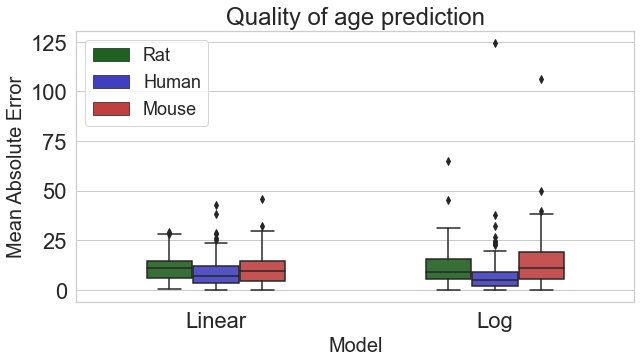

In [83]:
draw_quality_boxplot(error_dataframe,'Species',my_pal,"Temp.pdf")

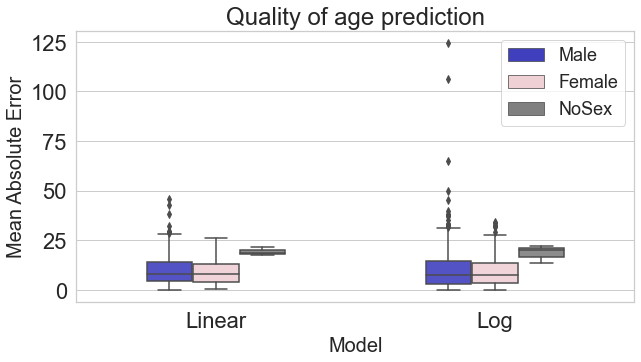

In [84]:
draw_quality_boxplot(error_dataframe,'Sex',my_pal,"Temp.pdf")

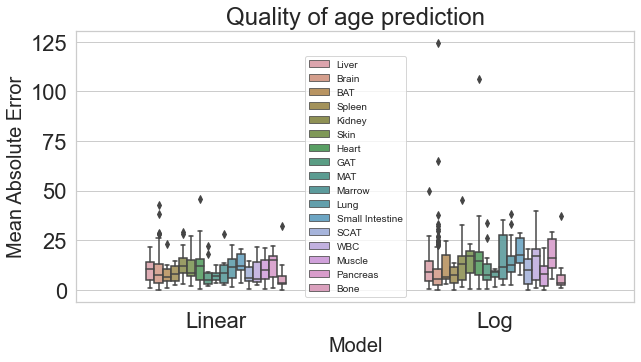

In [85]:
draw_quality_boxplot(error_dataframe,'Tissue',False,"Temp.pdf",legend_size=10)

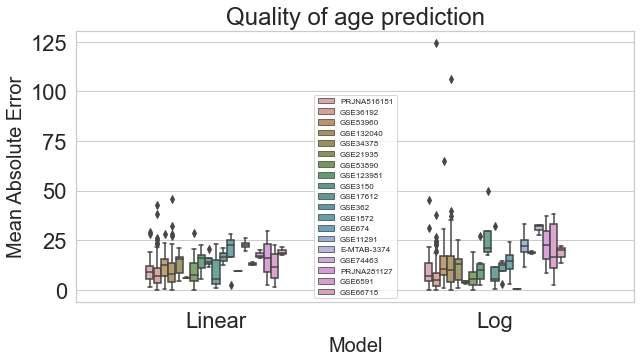

In [89]:
draw_quality_boxplot(error_dataframe,'GEO',False,"Temp.pdf",legend_size=8)

## 3. Get final models

In [7]:
def get_train_data(data,temp_tissue="All",temp_species="All",
                             categorical_cols=['Sex'],non_numeric_cols=['Sex','GEO','Species','Tissue'],
                           random_state=0,corr_threshold=0,na_percentage_thresh = 0):
    
    #Select tissue and species
    if (temp_tissue!="All"):
        data = data.loc[(data["Tissue"]==temp_tissue)]
    if (temp_species!="All"):
        if (temp_species=="Rodents"):
            data = data.loc[(data["Species"]!="Human")]
        else:
            data = data.loc[(data["Species"]==temp_species)]    

    #Specify X and y
    X = data.drop(["Age_m","Age_rel_m"],1)
    y = data["Age_m"]
    y_rel = data["Age_rel_m"]
    X = X.iloc[:,list(X.apply(lambda x: np.sum(x.isna())<=(X.shape[0]*na_percentage_thresh),axis=0))]
    
    from sklearn.feature_extraction import DictVectorizer as DV
    encoder_cat = DV(sparse = False)
    X_cat = encoder_cat.fit_transform(X[categorical_cols].T.to_dict().values())
    X_numbers = X[set(X.columns.values.tolist())-set(non_numeric_cols)]
    
    #Merge training data
    X_cat_train = X_cat
    X_numbers = X_numbers.apply(lambda x: x.fillna(value=x.mean(skipna=True)),axis=0)
    X_train = X_numbers
    y_train = y
    y_rel_train = y_rel
    print(X_train.shape)
    
    #Correlation filtering
    corrs = X_train.apply(lambda x: np.corrcoef(x,y_train)[0,1],axis=0)
    sign_genes = corrs.iloc[np.where(np.abs(corrs)>corr_threshold)]
    sign_genes = sign_genes.index
    print(len(sign_genes))
    
    if (X_cat.shape[1]>0):
        X_train_filtered = np.hstack((np.array(X_train[sign_genes]),X_cat_train))
    else:
        X_train_filtered= X_train[sign_genes]
        
    groups = X["GEO"]

    return (X_train_filtered, y_train, y_rel_train,
            groups)

In [20]:
def run_final_ML_model(X_train,y_train,X_test,y_test,groups,param_grid,model_type="EN",
                           scoring="neg_mean_absolute_error",refit=False,random_state=0):
    import warnings

    def fxn():
        warnings.warn("deprecated", DeprecationWarning)

    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        from sklearn import linear_model, ensemble
        from sklearn.model_selection import GridSearchCV
        from sklearn import metrics
        from sklearn.model_selection import GroupKFold, LeaveOneGroupOut
    
        if (model_type=="EN"):
            estimator = linear_model.ElasticNet(random_state=random_state)
        elif (model_type=="RF"):
            estimator = ensemble.RandomForestRegressor()
        else:
            return
        
        if (type(scoring)==dict):
            if (refit==False):
                refit = list(scoring.keys())[0]
            grid_model = GridSearchCV(estimator, param_grid, scoring = scoring,refit=refit,
                                      cv = logo.split(X_train,y_train,groups),
                                      n_jobs=-1)
        else:
            grid_model = GridSearchCV(estimator, param_grid, scoring = scoring,
                                      cv = logo.split(X_train,y_train,groups),
                                      n_jobs=-1)

        grid_model.fit(X_train,y_train)
        grid_model.best_estimator_.feature_names = list(X_train.columns.values)
    
        print("Best parameters:")
        print(grid_model.best_params_)
        
        test_predictions = grid_model.predict(X_test)
        train_predictions = grid_model.predict(X_train)
    print("MAE training: ")
    print(metrics.mean_absolute_error(y_train,train_predictions))
    
    print("R2 training: ")
    print(metrics.r2_score(y_train,train_predictions))
    
    return grid_model

In [9]:
import os
os.chdir('C:\\Users\\Александр\\Documents\\Science\\PhD\\analysis\\Comparison of signatures\\Aging signature\\Aging clock\\Final EN models')

In [38]:
param_grid = {'alpha': np.logspace(-3,0,10),
             'l1_ratio': np.linspace(0,1,6)}

In [283]:
param_grid

{'alpha': array([0.001     , 0.00215443, 0.00464159, 0.01      , 0.02154435,
        0.04641589, 0.1       , 0.21544347, 0.46415888, 1.        ]),
 'l1_ratio': array([0. , 0.2, 0.4, 0.6, 0.8, 1. ])}

In [270]:
multi_scoring = {"MAE": "neg_mean_absolute_error",
                "R2": "r2",
               "MSE": "neg_mean_squared_error",
                "EV": "explained_variance"}

### Mouse clocks

Liver

In [271]:
temp_tissue = "Liver"
temp_species = "Mouse"

In [272]:
(X_norm_train, y_train, y_rel_train,groups) = get_train_data(data_normalized,temp_tissue,temp_species,
                                                                  categorical_cols=[],random_state=5,corr_threshold=0,
                                                                  na_percentage_thresh=0.2)

(X_scaled_train, y_train, y_rel_train, groups) = get_train_data(data_scaled,temp_tissue,temp_species,
                                                                  categorical_cols=[],random_state=5,corr_threshold=0,
                                                                  na_percentage_thresh=0.2)

(103, 9793)
9793
(103, 9793)
9793


In [276]:
%%time
grid_model_final_mouse_liver_norm = run_final_ML_model(X_norm_train,y_rel_train,
                                                 X_norm_train,y_rel_train,
                                               groups,param_grid,model_type="EN",scoring=multi_scoring,refit="MAE")
print("MAE CV:")
print((-1)*grid_model_final_mouse_liver_norm.cv_results_['mean_test_MAE'][grid_model_final_mouse_liver_norm.best_index_])
print("R2 CV:")
print(grid_model_final_mouse_liver_norm.cv_results_['mean_test_R2'][grid_model_final_mouse_liver_norm.best_index_])
print("EV CV:")
print(grid_model_final_mouse_liver_norm.cv_results_['mean_test_EV'][grid_model_final_mouse_liver_norm.best_index_])

Best parameters:
{'alpha': 0.01, 'l1_ratio': 0.2}
MAE training: 
0.028364961985190982
R2 training: 
0.9547738736562061
MAE CV:
0.11269906155054428
R2 CV:
0.37692812076727156
EV CV:
0.4355789723797242
Wall time: 26.6 s


In [277]:
%%time
grid_model_final_mouse_liver_norm_log = run_final_ML_model(X_norm_train,np.log10(y_rel_train*100+1),
                                                    X_norm_train,np.log10(y_rel_train*100+1),
                                               groups,param_grid,model_type="EN",scoring=multi_scoring,refit="MAE")
print("MAE CV:")
print((-1)*grid_model_final_mouse_liver_norm_log.cv_results_['mean_test_MAE'][grid_model_final_mouse_liver_norm_log.best_index_])
print("R2 CV:")
print(grid_model_final_mouse_liver_norm_log.cv_results_['mean_test_R2'][grid_model_final_mouse_liver_norm_log.best_index_])
print("EV CV:")
print(grid_model_final_mouse_liver_norm_log.cv_results_['mean_test_EV'][grid_model_final_mouse_liver_norm_log.best_index_])

Best parameters:
{'alpha': 0.0021544346900318843, 'l1_ratio': 0.2}
MAE training: 
0.008303697114203624
R2 training: 
0.9988219585235453
MAE CV:
0.1987767049243678
R2 CV:
0.49392087871648754
EV CV:
0.6469602696065493
Wall time: 29.6 s


In [280]:
%%time
grid_model_final_mouse_liver_scale = run_final_ML_model(X_scaled_train,y_rel_train,
                                                 X_scaled_train,y_rel_train,
                                               groups,param_grid,model_type="EN",scoring=multi_scoring,refit="MAE")
print("MAE CV:")
print((-1)*grid_model_final_mouse_liver_scale.cv_results_['mean_test_MAE'][grid_model_final_mouse_liver_scale.best_index_])
print("R2 CV:")
print(grid_model_final_mouse_liver_scale.cv_results_['mean_test_R2'][grid_model_final_mouse_liver_scale.best_index_])
print("EV CV:")
print(grid_model_final_mouse_liver_scale.cv_results_['mean_test_EV'][grid_model_final_mouse_liver_scale.best_index_])
print("Max EV CV:")
print(np.max(grid_model_final_mouse_liver_scale.cv_results_['mean_test_EV']))

Best parameters:
{'alpha': 0.046415888336127774, 'l1_ratio': 0.2}
MAE training: 
0.06380272572465971
R2 training: 
0.8129968550963904
MAE CV:
0.10628187737668222
R2 CV:
0.5294607818526104
EV CV:
0.5456545315149988
Max EV CV:
0.5494042768539403
Wall time: 25 s


In [281]:
%%time
grid_model_final_mouse_liver_scale_log = run_final_ML_model(X_scaled_train,np.log10(y_rel_train*100+1),
                                                    X_scaled_train,np.log10(y_rel_train*100+1),
                                               groups,param_grid,model_type="EN",scoring=multi_scoring,refit="MAE")
print("MAE CV:")
print((-1)*grid_model_final_mouse_liver_scale_log.cv_results_['mean_test_MAE'][grid_model_final_mouse_liver_scale_log.best_index_])
print("R2 CV:")
print(grid_model_final_mouse_liver_scale_log.cv_results_['mean_test_R2'][grid_model_final_mouse_liver_scale_log.best_index_])
print("EV CV:")
print(grid_model_final_mouse_liver_scale_log.cv_results_['mean_test_EV'][grid_model_final_mouse_liver_scale_log.best_index_])
print("Max EV CV:")
print(np.max(grid_model_final_mouse_liver_scale_log.cv_results_['mean_test_EV']))

Best parameters:
{'alpha': 0.021544346900318832, 'l1_ratio': 0.2}
MAE training: 
0.05042972797008911
R2 training: 
0.9664284933589404
MAE CV:
0.19774252696984754
R2 CV:
0.4802544013489357
EV CV:
0.660288282889883
Max EV CV:
0.6763106522398818
Wall time: 29.5 s


Save models

In [282]:
import joblib

In [284]:
joblib.dump(grid_model_final_mouse_liver_norm.best_estimator_, 'Aging_mouse_liver_norm.pkl')
joblib.dump(grid_model_final_mouse_liver_norm_log.best_estimator_, 'Aging_mouse_liver_log_norm.pkl')
joblib.dump(grid_model_final_mouse_liver_scale.best_estimator_, 'Aging_mouse_liver_scaled.pkl')
joblib.dump(grid_model_final_mouse_liver_scale_log.best_estimator_, 'Aging_mouse_liver_log_scaled.pkl')

['Aging_mouse_liver_log_scaled.pkl']

Brain

In [285]:
temp_tissue = "Brain"
temp_species = "Mouse"

In [286]:
(X_norm_train, y_train, y_rel_train,groups) = get_train_data(data_normalized,temp_tissue,temp_species,
                                                                  categorical_cols=[],random_state=5,corr_threshold=0,
                                                                  na_percentage_thresh=0.05)

(X_scaled_train, y_train, y_rel_train, groups) = get_train_data(data_scaled,temp_tissue,temp_species,
                                                                  categorical_cols=[],random_state=5,corr_threshold=0,
                                                                  na_percentage_thresh=0.05)

(79, 11628)
11628
(79, 11628)
11628


In [294]:
%%time
grid_model_final_mouse_brain_norm = run_final_ML_model(X_norm_train,y_rel_train,
                                                 X_norm_train,y_rel_train,
                                               groups,param_grid,model_type="EN",scoring=multi_scoring,refit="MAE")
print("MAE CV:")
print((-1)*grid_model_final_mouse_brain_norm.cv_results_['mean_test_MAE'][grid_model_final_mouse_brain_norm.best_index_])
print("R2 CV:")
print(grid_model_final_mouse_brain_norm.cv_results_['mean_test_R2'][grid_model_final_mouse_brain_norm.best_index_])
print("EV CV:")
print(grid_model_final_mouse_brain_norm.cv_results_['mean_test_EV'][grid_model_final_mouse_brain_norm.best_index_])
print("Max EV CV:")
print(np.max(grid_model_final_mouse_brain_norm.cv_results_['mean_test_EV']))

Best parameters:
{'alpha': 0.001, 'l1_ratio': 1.0}
MAE training: 
0.013437280479753571
R2 training: 
0.9908568236582218
MAE CV:
0.1011834882760136
R2 CV:
0.5379209111974144
EV CV:
0.6538547453599589
Max EV CV:
0.7408544158710428
Wall time: 19.2 s


In [293]:
%%time
grid_model_final_mouse_brain_norm_log = run_final_ML_model(X_norm_train,np.log10(y_rel_train*100+1),
                                                    X_norm_train,np.log10(y_rel_train*100+1),
                                               groups,param_grid,model_type="EN",scoring=multi_scoring,refit="MAE")
print("MAE CV:")
print((-1)*grid_model_final_mouse_brain_norm_log.cv_results_['mean_test_MAE'][grid_model_final_mouse_brain_norm_log.best_index_])
print("R2 CV:")
print(grid_model_final_mouse_brain_norm_log.cv_results_['mean_test_R2'][grid_model_final_mouse_brain_norm_log.best_index_])
print("EV CV:")
print(grid_model_final_mouse_brain_norm_log.cv_results_['mean_test_EV'][grid_model_final_mouse_brain_norm_log.best_index_])
print("Max EV CV:")
print(np.max(grid_model_final_mouse_brain_norm_log.cv_results_['mean_test_EV']))

Best parameters:
{'alpha': 0.001, 'l1_ratio': 0.4}
MAE training: 
0.00636683837576819
R2 training: 
0.9991783999684521
MAE CV:
0.17699923456904576
R2 CV:
0.4673216822217468
EV CV:
0.6353192668389096
Max EV CV:
0.6980424222239665
Wall time: 21.9 s


In [354]:
EV_max_index = np.argmax(grid_model_final_mouse_brain_norm_log.cv_results_['mean_test_EV'])
EV_param_grid = grid_model_final_mouse_brain_norm_log.cv_results_['params'][EV_max_index]
EV_param_grid = {x: [EV_param_grid[x]] for x in EV_param_grid}
print(EV_param_grid)
grid_model_final_mouse_brain_norm_log_EV = run_final_ML_model(X_norm_train,np.log10(y_rel_train*100+1),
                                                    X_norm_train,np.log10(y_rel_train*100+1),
                                               groups,EV_param_grid,scoring=multi_scoring,refit="MAE")
print("MAE CV:")
print((-1)*grid_model_final_mouse_brain_norm_log_EV.cv_results_['mean_test_MAE'][grid_model_final_mouse_brain_norm_log_EV.best_index_])
print("R2 CV:")
print(grid_model_final_mouse_brain_norm_log_EV.cv_results_['mean_test_R2'][grid_model_final_mouse_brain_norm_log_EV.best_index_])
print("EV CV:")
print(grid_model_final_mouse_brain_norm_log_EV.cv_results_['mean_test_EV'][grid_model_final_mouse_brain_norm_log_EV.best_index_])
print("Max EV CV:")
print(np.max(grid_model_final_mouse_brain_norm_log_EV.cv_results_['mean_test_EV']))

Best parameters:
{'alpha': 0.001, 'l1_ratio': 0.2}
MAE training: 
0.0064258510111108455
R2 training: 
0.999569717572542
MAE CV:
0.2589466519560413
R2 CV:
-0.22245312232975334
EV CV:
0.6890840189952345
Max EV CV:
0.6890840189952345


In [289]:
%%time
grid_model_final_mouse_brain_scale = run_final_ML_model(X_scaled_train,y_rel_train,
                                                 X_scaled_train,y_rel_train,
                                               groups,param_grid,model_type="EN",scoring=multi_scoring,refit="MAE")
print("MAE CV:")
print((-1)*grid_model_final_mouse_brain_scale.cv_results_['mean_test_MAE'][grid_model_final_mouse_brain_scale.best_index_])
print("R2 CV:")
print(grid_model_final_mouse_brain_scale.cv_results_['mean_test_R2'][grid_model_final_mouse_brain_scale.best_index_])
print("EV CV:")
print(grid_model_final_mouse_brain_scale.cv_results_['mean_test_EV'][grid_model_final_mouse_brain_scale.best_index_])
print("Max EV CV:")
print(np.max(grid_model_final_mouse_brain_scale.cv_results_['mean_test_EV']))

Best parameters:
{'alpha': 0.001, 'l1_ratio': 0.8}
MAE training: 
0.012965924804943792
R2 training: 
0.9920945423322839
MAE CV:
0.10185195145931214
R2 CV:
0.5909447017898988
EV CV:
0.7923585578377764
Max EV CV:
0.8119732316476195
Wall time: 18.8 s


In [290]:
%%time
grid_model_final_mouse_brain_scale_log = run_final_ML_model(X_scaled_train,np.log10(y_rel_train*100+1),
                                                    X_scaled_train,np.log10(y_rel_train*100+1),
                                               groups,param_grid,model_type="EN",scoring=multi_scoring,refit="MAE")
print("MAE CV:")
print((-1)*grid_model_final_mouse_brain_scale_log.cv_results_['mean_test_MAE'][grid_model_final_mouse_brain_scale_log.best_index_])
print("R2 CV:")
print(grid_model_final_mouse_brain_scale_log.cv_results_['mean_test_R2'][grid_model_final_mouse_brain_scale_log.best_index_])
print("EV CV:")
print(grid_model_final_mouse_brain_scale_log.cv_results_['mean_test_EV'][grid_model_final_mouse_brain_scale_log.best_index_])
print("Max EV CV:")
print(np.max(grid_model_final_mouse_brain_scale_log.cv_results_['mean_test_EV']))

Best parameters:
{'alpha': 0.004641588833612777, 'l1_ratio': 0.4}
MAE training: 
0.02945460085886315
R2 training: 
0.9856953580938526
MAE CV:
0.15055106750117817
R2 CV:
0.6266427051619897
EV CV:
0.7852802744970666
Max EV CV:
0.8121029852535964
Wall time: 21.8 s


Save models

In [295]:
import joblib

In [296]:
joblib.dump(grid_model_final_mouse_brain_norm.best_estimator_, 'Aging_mouse_brain_norm.pkl')
joblib.dump(grid_model_final_mouse_brain_norm_log.best_estimator_, 'Aging_mouse_brain_log_norm.pkl')
joblib.dump(grid_model_final_mouse_brain_scale.best_estimator_, 'Aging_mouse_brain_scaled.pkl')
joblib.dump(grid_model_final_mouse_brain_scale_log.best_estimator_, 'Aging_mouse_brain_log_scaled.pkl')

['Aging_mouse_brain_log_scaled.pkl']

Kidney

In [297]:
temp_tissue = "Kidney"
temp_species = "Mouse"

In [298]:
(X_norm_train, y_train, y_rel_train,groups) = get_train_data(data_normalized,temp_tissue,temp_species,
                                                                  categorical_cols=[],random_state=5,corr_threshold=0,
                                                                  na_percentage_thresh=0.15)

(X_scaled_train, y_train, y_rel_train, groups) = get_train_data(data_scaled,temp_tissue,temp_species,
                                                                  categorical_cols=[],random_state=5,corr_threshold=0,
                                                                  na_percentage_thresh=0.15)

(83, 11106)
11106
(83, 11106)
11106


In [299]:
%%time
grid_model_final_mouse_kidney_norm = run_final_ML_model(X_norm_train,y_rel_train,
                                                 X_norm_train,y_rel_train,
                                               groups,param_grid,model_type="EN",scoring=multi_scoring,refit="MAE")
print("MAE CV:")
print((-1)*grid_model_final_mouse_kidney_norm.cv_results_['mean_test_MAE'][grid_model_final_mouse_kidney_norm.best_index_])
print("R2 CV:")
print(grid_model_final_mouse_kidney_norm.cv_results_['mean_test_R2'][grid_model_final_mouse_kidney_norm.best_index_])
print("EV CV:")
print(grid_model_final_mouse_kidney_norm.cv_results_['mean_test_EV'][grid_model_final_mouse_kidney_norm.best_index_])
print("Max EV CV:")
print(np.max(grid_model_final_mouse_kidney_norm.cv_results_['mean_test_EV']))

Best parameters:
{'alpha': 0.046415888336127774, 'l1_ratio': 0.2}
MAE training: 
0.06985591627658251
R2 training: 
0.740555614034806
MAE CV:
0.12293537160939878
R2 CV:
0.43773755647454743
EV CV:
0.4935365291774905
Max EV CV:
0.4935365291774905
Wall time: 17.6 s


In [301]:
%%time
grid_model_final_mouse_kidney_norm_log = run_final_ML_model(X_norm_train,np.log10(y_rel_train*100+1),
                                                    X_norm_train,np.log10(y_rel_train*100+1),
                                               groups,param_grid,model_type="EN",scoring=multi_scoring,refit="MAE")
print("MAE CV:")
print((-1)*grid_model_final_mouse_kidney_norm_log.cv_results_['mean_test_MAE'][grid_model_final_mouse_kidney_norm_log.best_index_])
print("R2 CV:")
print(grid_model_final_mouse_kidney_norm_log.cv_results_['mean_test_R2'][grid_model_final_mouse_kidney_norm_log.best_index_])
print("EV CV:")
print(grid_model_final_mouse_kidney_norm_log.cv_results_['mean_test_EV'][grid_model_final_mouse_kidney_norm_log.best_index_])
print("Max EV CV:")
print(np.max(grid_model_final_mouse_kidney_norm_log.cv_results_['mean_test_EV']))

Best parameters:
{'alpha': 0.21544346900318823, 'l1_ratio': 0.2}
MAE training: 
0.1464651452935194
R2 training: 
0.6285832026792537
MAE CV:
0.24219828347239292
R2 CV:
0.3834264944497957
EV CV:
0.4895961567810353
Max EV CV:
0.566377894766116
Wall time: 19.5 s


In [302]:
%%time
grid_model_final_mouse_kidney_scale = run_final_ML_model(X_scaled_train,y_rel_train,
                                                 X_scaled_train,y_rel_train,
                                               groups,param_grid,model_type="EN",scoring=multi_scoring,refit="MAE")
print("MAE CV:")
print((-1)*grid_model_final_mouse_kidney_scale.cv_results_['mean_test_MAE'][grid_model_final_mouse_kidney_scale.best_index_])
print("R2 CV:")
print(grid_model_final_mouse_kidney_scale.cv_results_['mean_test_R2'][grid_model_final_mouse_kidney_scale.best_index_])
print("EV CV:")
print(grid_model_final_mouse_kidney_scale.cv_results_['mean_test_EV'][grid_model_final_mouse_kidney_scale.best_index_])
print("Max EV CV:")
print(np.max(grid_model_final_mouse_kidney_scale.cv_results_['mean_test_EV']))

Best parameters:
{'alpha': 0.046415888336127774, 'l1_ratio': 0.2}
MAE training: 
0.06709974192724563
R2 training: 
0.7627972729541607
MAE CV:
0.12829476406052148
R2 CV:
0.360568666455034
EV CV:
0.5213428224727947
Max EV CV:
0.5213428224727947
Wall time: 18.1 s


In [306]:
%%time
grid_model_final_mouse_kidney_scale_log = run_final_ML_model(X_scaled_train,np.log10(y_rel_train*100+1),
                                                    X_scaled_train,np.log10(y_rel_train*100+1),
                                               groups,param_grid,model_type="EN",scoring=multi_scoring,refit="MAE")
print("MAE CV:")
print((-1)*grid_model_final_mouse_kidney_scale_log.cv_results_['mean_test_MAE'][grid_model_final_mouse_kidney_scale_log.best_index_])
print("R2 CV:")
print(grid_model_final_mouse_kidney_scale_log.cv_results_['mean_test_R2'][grid_model_final_mouse_kidney_scale_log.best_index_])
print("EV CV:")
print(grid_model_final_mouse_kidney_scale_log.cv_results_['mean_test_EV'][grid_model_final_mouse_kidney_scale_log.best_index_])
print("Max EV CV:")
print(np.max(grid_model_final_mouse_kidney_scale_log.cv_results_['mean_test_EV']))

Best parameters:
{'alpha': 0.1, 'l1_ratio': 0.6000000000000001}
MAE training: 
0.15518515409113867
R2 training: 
0.61453719655489
MAE CV:
0.2473885426998954
R2 CV:
0.38456015361494583
EV CV:
0.478249409619922
Max EV CV:
0.6215701757375562
Wall time: 19.3 s


Save models

In [307]:
joblib.dump(grid_model_final_mouse_kidney_norm.best_estimator_, 'Aging_mouse_kidney_norm.pkl')
joblib.dump(grid_model_final_mouse_kidney_norm_log.best_estimator_, 'Aging_mouse_kidney_log_norm.pkl')
joblib.dump(grid_model_final_mouse_kidney_scale.best_estimator_, 'Aging_mouse_kidney_scaled.pkl')
joblib.dump(grid_model_final_mouse_kidney_scale_log.best_estimator_, 'Aging_mouse_kidney_log_scaled.pkl')

['Aging_mouse_kidney_log_scaled.pkl']

## Multi-species clocks

### Liver

In [308]:
temp_tissue = "Liver"
temp_species = "All"

In [309]:
(X_norm_train, y_train, y_rel_train,groups) = get_train_data(data_normalized,temp_tissue,temp_species,
                                                                  categorical_cols=[],random_state=5,corr_threshold=0,
                                                                  na_percentage_thresh=0.25)

(X_scaled_train, y_train, y_rel_train, groups) = get_train_data(data_scaled,temp_tissue,temp_species,
                                                                  categorical_cols=[],random_state=5,corr_threshold=0,
                                                                  na_percentage_thresh=0.25)

(211, 9206)
9206
(211, 9206)
9206


In [355]:
param_grid = {'alpha': np.logspace(-2,1,4),
             'l1_ratio': np.linspace(0,1,6)}
param_grid = {'alpha': np.logspace(-3,0,10),
             'l1_ratio': np.linspace(0,1,6)}

In [356]:
param_grid

{'alpha': array([0.001     , 0.00215443, 0.00464159, 0.01      , 0.02154435,
        0.04641589, 0.1       , 0.21544347, 0.46415888, 1.        ]),
 'l1_ratio': array([0. , 0.2, 0.4, 0.6, 0.8, 1. ])}

In [314]:
%%time
grid_model_final_liver_norm = run_final_ML_model(X_norm_train,y_rel_train,
                                                 X_norm_train,y_rel_train,
                                               groups,param_grid,model_type="EN",scoring=multi_scoring,refit="MAE")
print("MAE CV:")
print((-1)*grid_model_final_liver_norm.cv_results_['mean_test_MAE'][grid_model_final_liver_norm.best_index_])
print("R2 CV:")
print(grid_model_final_liver_norm.cv_results_['mean_test_R2'][grid_model_final_liver_norm.best_index_])
print("EV CV:")
print(grid_model_final_liver_norm.cv_results_['mean_test_EV'][grid_model_final_liver_norm.best_index_])
print("Max EV CV:")
print(np.max(grid_model_final_liver_norm.cv_results_['mean_test_EV']))

Best parameters:
{'alpha': 0.01, 'l1_ratio': 0.0}
MAE training: 
0.0009832211872869505
R2 training: 
0.9999319124819139
MAE CV:
0.0996166371480388
R2 CV:
0.5734968880890073
EV CV:
0.6546967689134049
Max EV CV:
0.670025706359195
Wall time: 1min 25s


In [315]:
%%time
grid_model_final_liver_norm_log = run_final_ML_model(X_norm_train,np.log10(y_rel_train*100+1),
                                                    X_norm_train,np.log10(y_rel_train*100+1),
                                               groups,param_grid,model_type="EN",scoring=multi_scoring,refit="MAE")
print("MAE CV:")
print((-1)*grid_model_final_liver_norm_log.cv_results_['mean_test_MAE'][grid_model_final_liver_norm_log.best_index_])
print("R2 CV:")
print(grid_model_final_liver_norm_log.cv_results_['mean_test_R2'][grid_model_final_liver_norm_log.best_index_])
print("EV CV:")
print(grid_model_final_liver_norm_log.cv_results_['mean_test_EV'][grid_model_final_liver_norm_log.best_index_])
print("Max EV CV:")
print(np.max(grid_model_final_liver_norm_log.cv_results_['mean_test_EV']))

Best parameters:
{'alpha': 0.01, 'l1_ratio': 0.0}
MAE training: 
0.0015554581248651324
R2 training: 
0.9999624201775814
MAE CV:
0.19859885134645183
R2 CV:
0.5336413795747519
EV CV:
0.6763959115396919
Max EV CV:
0.6890840189952345
Wall time: 1min 39s


In [316]:
%%time
grid_model_final_liver_scale = run_final_ML_model(X_scaled_train,y_rel_train,
                                                 X_scaled_train,y_rel_train,
                                               groups,param_grid,model_type="EN",scoring=multi_scoring,refit="MAE")
print("MAE CV:")
print((-1)*grid_model_final_liver_scale.cv_results_['mean_test_MAE'][grid_model_final_liver_scale.best_index_])
print("R2 CV:")
print(grid_model_final_liver_scale.cv_results_['mean_test_R2'][grid_model_final_liver_scale.best_index_])
print("EV CV:")
print(grid_model_final_liver_scale.cv_results_['mean_test_EV'][grid_model_final_liver_scale.best_index_])
print("Max EV CV:")
print(np.max(grid_model_final_liver_scale.cv_results_['mean_test_EV']))

Best parameters:
{'alpha': 0.01, 'l1_ratio': 0.0}
MAE training: 
0.0009622548673903045
R2 training: 
0.999944958428575
MAE CV:
0.09288190530684078
R2 CV:
0.6312208637270091
EV CV:
0.6930760465838166
Max EV CV:
0.7259881794762557
Wall time: 1min 30s


In [317]:
%%time
grid_model_final_liver_scale_log = run_final_ML_model(X_scaled_train,np.log10(y_rel_train*100+1),
                                                    X_scaled_train,np.log10(y_rel_train*100+1),
                                               groups,param_grid,model_type="EN",scoring=multi_scoring,refit="MAE")
print("MAE CV:")
print((-1)*grid_model_final_liver_scale_log.cv_results_['mean_test_MAE'][grid_model_final_liver_scale_log.best_index_])
print("R2 CV:")
print(grid_model_final_liver_scale_log.cv_results_['mean_test_R2'][grid_model_final_liver_scale_log.best_index_])
print("EV CV:")
print(grid_model_final_liver_scale_log.cv_results_['mean_test_EV'][grid_model_final_liver_scale_log.best_index_])
print("Max EV CV:")
print(np.max(grid_model_final_liver_scale_log.cv_results_['mean_test_EV']))

Best parameters:
{'alpha': 0.01, 'l1_ratio': 0.0}
MAE training: 
0.0015165334627183413
R2 training: 
0.9999707786309568
MAE CV:
0.19431987665084102
R2 CV:
0.561810240549965
EV CV:
0.7129336041111201
Max EV CV:
0.7818249576753403
Wall time: 1min 42s


Save models

In [357]:
import joblib

In [358]:
joblib.dump(grid_model_final_liver_norm.best_estimator_, 'Aging_liver_norm.pkl')
joblib.dump(grid_model_final_liver_norm_log.best_estimator_, 'Aging_liver_log_norm.pkl')
joblib.dump(grid_model_final_liver_scale.best_estimator_, 'Aging_liver_scaled.pkl')
joblib.dump(grid_model_final_liver_scale_log.best_estimator_, 'Aging_liver_log_scaled.pkl')

['Aging_liver_log_scaled.pkl']

### Brain

In [363]:
temp_tissue = "Brain"
temp_species = "All"

In [364]:
(X_norm_train, y_train, y_rel_train,groups) = get_train_data(data_normalized,temp_tissue,temp_species,
                                                                  categorical_cols=[],random_state=5,corr_threshold=0,
                                                                  na_percentage_thresh=0.05)

(X_scaled_train, y_train, y_rel_train, groups) = get_train_data(data_scaled,temp_tissue,temp_species,
                                                                  categorical_cols=[],random_state=5,corr_threshold=0,
                                                                  na_percentage_thresh=0.05)

(1190, 9284)
9284
(1190, 9284)
9284


In [365]:
param_grid = {'alpha': np.logspace(-2,1,4),
             'l1_ratio': np.linspace(0,1,6)}
param_grid = {'alpha': np.logspace(-3,0,10),
             'l1_ratio': np.linspace(0,1,6)}

In [366]:
param_grid

{'alpha': array([0.001     , 0.00215443, 0.00464159, 0.01      , 0.02154435,
        0.04641589, 0.1       , 0.21544347, 0.46415888, 1.        ]),
 'l1_ratio': array([0. , 0.2, 0.4, 0.6, 0.8, 1. ])}

In [367]:
%%time
grid_model_final_brain_norm = run_final_ML_model(X_norm_train,y_rel_train,
                                                 X_norm_train,y_rel_train,
                                               groups,param_grid,model_type="EN",scoring=multi_scoring,refit="MAE")
print("MAE CV:")
print((-1)*grid_model_final_brain_norm.cv_results_['mean_test_MAE'][grid_model_final_brain_norm.best_index_])
print("R2 CV:")
print(grid_model_final_brain_norm.cv_results_['mean_test_R2'][grid_model_final_brain_norm.best_index_])
print("EV CV:")
print(grid_model_final_brain_norm.cv_results_['mean_test_EV'][grid_model_final_brain_norm.best_index_])
print("Max EV CV:")
print(np.max(grid_model_final_brain_norm.cv_results_['mean_test_EV']))

Best parameters:
{'alpha': 0.0021544346900318843, 'l1_ratio': 0.8}
MAE training: 
0.06193776128640581
R2 training: 
0.8629824739865685
MAE CV:
0.13501819034958543
R2 CV:
0.30327243281350963
EV CV:
0.5534440064324387
Max EV CV:
0.6531366872656293
Wall time: 10min 40s


In [368]:
%%time
grid_model_final_brain_norm_log = run_final_ML_model(X_norm_train,np.log10(y_rel_train*100+1),
                                                    X_norm_train,np.log10(y_rel_train*100+1),
                                               groups,param_grid,model_type="EN",scoring=multi_scoring,refit="MAE")
print("MAE CV:")
print((-1)*grid_model_final_brain_norm_log.cv_results_['mean_test_MAE'][grid_model_final_brain_norm_log.best_index_])
print("R2 CV:")
print(grid_model_final_brain_norm_log.cv_results_['mean_test_R2'][grid_model_final_brain_norm_log.best_index_])
print("EV CV:")
print(grid_model_final_brain_norm_log.cv_results_['mean_test_EV'][grid_model_final_brain_norm_log.best_index_])
print("Max EV CV:")
print(np.max(grid_model_final_brain_norm_log.cv_results_['mean_test_EV']))

Best parameters:
{'alpha': 0.021544346900318832, 'l1_ratio': 0.0}
MAE training: 
0.012424803673538659
R2 training: 
0.9965234947369332
MAE CV:
0.19448423264211323
R2 CV:
0.30002160904076297
EV CV:
0.6477960159572111
Max EV CV:
0.6645446552956125
Wall time: 11min 18s


In [369]:
%%time
grid_model_final_brain_scale = run_final_ML_model(X_scaled_train,y_rel_train,
                                                 X_scaled_train,y_rel_train,
                                               groups,param_grid,model_type="EN",scoring=multi_scoring,refit="MAE")
print("MAE CV:")
print((-1)*grid_model_final_brain_scale.cv_results_['mean_test_MAE'][grid_model_final_brain_scale.best_index_])
print("R2 CV:")
print(grid_model_final_brain_scale.cv_results_['mean_test_R2'][grid_model_final_brain_scale.best_index_])
print("EV CV:")
print(grid_model_final_brain_scale.cv_results_['mean_test_EV'][grid_model_final_brain_scale.best_index_])
print("Max EV CV:")
print(np.max(grid_model_final_brain_scale.cv_results_['mean_test_EV']))

Best parameters:
{'alpha': 0.001, 'l1_ratio': 0.6000000000000001}
MAE training: 
0.0444278621395356
R2 training: 
0.9281877577281034
MAE CV:
0.12919064808510647
R2 CV:
0.3153334913978357
EV CV:
0.5724436898311654
Max EV CV:
0.6378863706297986
Wall time: 10min 32s


In [370]:
%%time
grid_model_final_brain_scale_log = run_final_ML_model(X_scaled_train,np.log10(y_rel_train*100+1),
                                                    X_scaled_train,np.log10(y_rel_train*100+1),
                                               groups,param_grid,model_type="EN",scoring=multi_scoring,refit="MAE")
print("MAE CV:")
print((-1)*grid_model_final_brain_scale_log.cv_results_['mean_test_MAE'][grid_model_final_brain_scale_log.best_index_])
print("R2 CV:")
print(grid_model_final_brain_scale_log.cv_results_['mean_test_R2'][grid_model_final_brain_scale_log.best_index_])
print("EV CV:")
print(grid_model_final_brain_scale_log.cv_results_['mean_test_EV'][grid_model_final_brain_scale_log.best_index_])
print("Max EV CV:")
print(np.max(grid_model_final_brain_scale_log.cv_results_['mean_test_EV']))

Best parameters:
{'alpha': 0.0021544346900318843, 'l1_ratio': 0.0}
MAE training: 
0.002473981331072018
R2 training: 
0.9998691306852259
MAE CV:
0.20233896096239332
R2 CV:
-0.013701458715668552
EV CV:
0.6221322260898522
Max EV CV:
0.636012634413104
Wall time: 12min 3s


Save models

In [371]:
import joblib

In [372]:
joblib.dump(grid_model_final_brain_norm.best_estimator_, 'Aging_brain_norm.pkl')
joblib.dump(grid_model_final_brain_norm_log.best_estimator_, 'Aging_brain_log_norm.pkl')
joblib.dump(grid_model_final_brain_scale.best_estimator_, 'Aging_brain_scaled.pkl')
joblib.dump(grid_model_final_brain_scale_log.best_estimator_, 'Aging_brain_log_scaled.pkl')

['Aging_brain_log_scaled.pkl']

### Muscle

In [373]:
temp_tissue = "Muscle"
temp_species = "All"

In [374]:
(X_norm_train, y_train, y_rel_train,groups) = get_train_data(data_normalized,temp_tissue,temp_species,
                                                                  categorical_cols=[],random_state=5,corr_threshold=0,
                                                                  na_percentage_thresh=0.15)

(X_scaled_train, y_train, y_rel_train, groups) = get_train_data(data_scaled,temp_tissue,temp_species,
                                                                  categorical_cols=[],random_state=5,corr_threshold=0,
                                                                  na_percentage_thresh=0.15)

(167, 5283)
5283
(167, 5283)
5283


In [375]:
param_grid = {'alpha': np.logspace(-2,1,4),
             'l1_ratio': np.linspace(0,1,6)}
param_grid = {'alpha': np.logspace(-3,0,10),
             'l1_ratio': np.linspace(0,1,6)}

In [376]:
param_grid

{'alpha': array([0.001     , 0.00215443, 0.00464159, 0.01      , 0.02154435,
        0.04641589, 0.1       , 0.21544347, 0.46415888, 1.        ]),
 'l1_ratio': array([0. , 0.2, 0.4, 0.6, 0.8, 1. ])}

In [377]:
%%time
grid_model_final_muscle_norm = run_final_ML_model(X_norm_train,y_rel_train,
                                                 X_norm_train,y_rel_train,
                                               groups,param_grid,model_type="EN",scoring=multi_scoring,refit="MAE")
print("MAE CV:")
print((-1)*grid_model_final_muscle_norm.cv_results_['mean_test_MAE'][grid_model_final_muscle_norm.best_index_])
print("R2 CV:")
print(grid_model_final_muscle_norm.cv_results_['mean_test_R2'][grid_model_final_muscle_norm.best_index_])
print("EV CV:")
print(grid_model_final_muscle_norm.cv_results_['mean_test_EV'][grid_model_final_muscle_norm.best_index_])
print("Max EV CV:")
print(np.max(grid_model_final_muscle_norm.cv_results_['mean_test_EV']))

Best parameters:
{'alpha': 0.004641588833612777, 'l1_ratio': 0.8}
MAE training: 
0.04524328090551552
R2 training: 
0.9124514408267078
MAE CV:
0.1145944757926643
R2 CV:
0.5103918240483795
EV CV:
0.5525942200129326
Max EV CV:
0.5602302022516831
Wall time: 25.4 s


In [378]:
%%time
grid_model_final_muscle_norm_log = run_final_ML_model(X_norm_train,np.log10(y_rel_train*100+1),
                                                    X_norm_train,np.log10(y_rel_train*100+1),
                                               groups,param_grid,model_type="EN",scoring=multi_scoring,refit="MAE")
print("MAE CV:")
print((-1)*grid_model_final_muscle_norm_log.cv_results_['mean_test_MAE'][grid_model_final_muscle_norm_log.best_index_])
print("R2 CV:")
print(grid_model_final_muscle_norm_log.cv_results_['mean_test_R2'][grid_model_final_muscle_norm_log.best_index_])
print("EV CV:")
print(grid_model_final_muscle_norm_log.cv_results_['mean_test_EV'][grid_model_final_muscle_norm_log.best_index_])
print("Max EV CV:")
print(np.max(grid_model_final_muscle_norm_log.cv_results_['mean_test_EV']))

Best parameters:
{'alpha': 0.004641588833612777, 'l1_ratio': 0.8}
MAE training: 
0.05413663831058647
R2 training: 
0.969597201130074
MAE CV:
0.20449856959994914
R2 CV:
0.3903453968736466
EV CV:
0.5724266101351315
Max EV CV:
0.5823691918597728
Wall time: 30.3 s


In [379]:
%%time
grid_model_final_muscle_scale = run_final_ML_model(X_scaled_train,y_rel_train,
                                                 X_scaled_train,y_rel_train,
                                               groups,param_grid,model_type="EN",scoring=multi_scoring,refit="MAE")
print("MAE CV:")
print((-1)*grid_model_final_muscle_scale.cv_results_['mean_test_MAE'][grid_model_final_muscle_scale.best_index_])
print("R2 CV:")
print(grid_model_final_muscle_scale.cv_results_['mean_test_R2'][grid_model_final_muscle_scale.best_index_])
print("EV CV:")
print(grid_model_final_muscle_scale.cv_results_['mean_test_EV'][grid_model_final_muscle_scale.best_index_])
print("Max EV CV:")
print(np.max(grid_model_final_muscle_scale.cv_results_['mean_test_EV']))

Best parameters:
{'alpha': 0.01, 'l1_ratio': 0.4}
MAE training: 
0.050003404589133674
R2 training: 
0.8907862862385146
MAE CV:
0.11315054813388527
R2 CV:
0.5274332511817793
EV CV:
0.5626032510770353
Max EV CV:
0.570276045620047
Wall time: 24.6 s


In [380]:
%%time
grid_model_final_muscle_scale_log = run_final_ML_model(X_scaled_train,np.log10(y_rel_train*100+1),
                                                    X_scaled_train,np.log10(y_rel_train*100+1),
                                               groups,param_grid,model_type="EN",scoring=multi_scoring,refit="MAE")
print("MAE CV:")
print((-1)*grid_model_final_muscle_scale_log.cv_results_['mean_test_MAE'][grid_model_final_muscle_scale_log.best_index_])
print("R2 CV:")
print(grid_model_final_muscle_scale_log.cv_results_['mean_test_R2'][grid_model_final_muscle_scale_log.best_index_])
print("EV CV:")
print(grid_model_final_muscle_scale_log.cv_results_['mean_test_EV'][grid_model_final_muscle_scale_log.best_index_])
print("Max EV CV:")
print(np.max(grid_model_final_muscle_scale_log.cv_results_['mean_test_EV']))

Best parameters:
{'alpha': 0.01, 'l1_ratio': 0.6000000000000001}
MAE training: 
0.07581501208494844
R2 training: 
0.9409394585631199
MAE CV:
0.20530220246754172
R2 CV:
0.3680035108700699
EV CV:
0.5837099209774873
Max EV CV:
0.5837099209774873
Wall time: 28.2 s


Save models

In [381]:
import joblib

In [382]:
joblib.dump(grid_model_final_muscle_norm.best_estimator_, 'Aging_muscle_norm.pkl')
joblib.dump(grid_model_final_muscle_norm_log.best_estimator_, 'Aging_muscle_log_norm.pkl')
joblib.dump(grid_model_final_muscle_scale.best_estimator_, 'Aging_muscle_scaled.pkl')
joblib.dump(grid_model_final_muscle_scale_log.best_estimator_, 'Aging_muscle_log_scaled.pkl')

['Aging_muscle_log_scaled.pkl']

## Multi-tissue clocks

In [383]:
param_grid = {'alpha': np.logspace(-3,0,10),
             'l1_ratio': np.linspace(0,1,6)}

### Mouse - normalized is better

In [384]:
temp_tissue = "All"
temp_species = "Mouse"

In [385]:
(X_norm_train, y_train, y_rel_train,groups) = get_train_data(data_normalized,temp_tissue,temp_species,
                                                                  categorical_cols=[],random_state=5,corr_threshold=0,
                                                                  na_percentage_thresh=0.25)

(X_scaled_train, y_train, y_rel_train, groups) = get_train_data(data_scaled,temp_tissue,temp_species,
                                                                  categorical_cols=[],random_state=5,corr_threshold=0,
                                                                  na_percentage_thresh=0.25)

(976, 9563)
9563
(976, 9563)
9563


In [386]:
param_grid = {'alpha': np.logspace(-2,1,4),
             'l1_ratio': np.linspace(0,1,6)}
param_grid = {'alpha': np.logspace(-3,0,10),
             'l1_ratio': np.linspace(0,1,6)}

In [387]:
param_grid

{'alpha': array([0.001     , 0.00215443, 0.00464159, 0.01      , 0.02154435,
        0.04641589, 0.1       , 0.21544347, 0.46415888, 1.        ]),
 'l1_ratio': array([0. , 0.2, 0.4, 0.6, 0.8, 1. ])}

In [388]:
%%time
grid_model_final_mouse_norm = run_final_ML_model(X_norm_train,y_rel_train,
                                                 X_norm_train,y_rel_train,
                                               groups,param_grid,model_type="EN",scoring=multi_scoring,refit="MAE")
print("MAE CV:")
print((-1)*grid_model_final_mouse_norm.cv_results_['mean_test_MAE'][grid_model_final_mouse_norm.best_index_])
print("R2 CV:")
print(grid_model_final_mouse_norm.cv_results_['mean_test_R2'][grid_model_final_mouse_norm.best_index_])
print("EV CV:")
print(grid_model_final_mouse_norm.cv_results_['mean_test_EV'][grid_model_final_mouse_norm.best_index_])
print("Max EV CV:")
print(np.max(grid_model_final_mouse_norm.cv_results_['mean_test_EV']))

Best parameters:
{'alpha': 0.004641588833612777, 'l1_ratio': 0.2}
MAE training: 
0.050738896066517256
R2 training: 
0.8449066504207079
MAE CV:
0.15325931384665592
R2 CV:
0.017286540777645996
EV CV:
0.22302854483031728
Max EV CV:
0.22302854483031728
Wall time: 6min 27s


In [389]:
%%time
grid_model_final_mouse_norm_log = run_final_ML_model(X_norm_train,np.log10(y_rel_train*100+1),
                                                    X_norm_train,np.log10(y_rel_train*100+1),
                                               groups,param_grid,model_type="EN",scoring=multi_scoring,refit="MAE")
print("MAE CV:")
print((-1)*grid_model_final_mouse_norm_log.cv_results_['mean_test_MAE'][grid_model_final_mouse_norm_log.best_index_])
print("R2 CV:")
print(grid_model_final_mouse_norm_log.cv_results_['mean_test_R2'][grid_model_final_mouse_norm_log.best_index_])
print("EV CV:")
print(grid_model_final_mouse_norm_log.cv_results_['mean_test_EV'][grid_model_final_mouse_norm_log.best_index_])
print("Max EV CV:")
print(np.max(grid_model_final_mouse_norm_log.cv_results_['mean_test_EV']))

Best parameters:
{'alpha': 0.004641588833612777, 'l1_ratio': 0.2}
MAE training: 
0.06562514082955745
R2 training: 
0.9165036180672459
MAE CV:
0.24385077604434688
R2 CV:
0.24128072437451997
EV CV:
0.3121373184492124
Max EV CV:
0.37758584851850596
Wall time: 7min 28s


In [390]:
%%time
grid_model_final_mouse_scale = run_final_ML_model(X_scaled_train,y_rel_train,
                                                 X_scaled_train,y_rel_train,
                                               groups,param_grid,model_type="EN",scoring=multi_scoring,refit="MAE")
print("MAE CV:")
print((-1)*grid_model_final_mouse_scale.cv_results_['mean_test_MAE'][grid_model_final_mouse_scale.best_index_])
print("R2 CV:")
print(grid_model_final_mouse_scale.cv_results_['mean_test_R2'][grid_model_final_mouse_scale.best_index_])
print("EV CV:")
print(grid_model_final_mouse_scale.cv_results_['mean_test_EV'][grid_model_final_mouse_scale.best_index_])
print("Max EV CV:")
print(np.max(grid_model_final_mouse_scale.cv_results_['mean_test_EV']))

Best parameters:
{'alpha': 0.004641588833612777, 'l1_ratio': 0.2}
MAE training: 
0.051482671507964935
R2 training: 
0.8411504316515357
MAE CV:
0.16603875031638604
R2 CV:
-0.2123336671715731
EV CV:
0.0929136606615203
Max EV CV:
0.2241271161941279
Wall time: 6min 37s


In [391]:
%%time
grid_model_final_mouse_scale_log = run_final_ML_model(X_scaled_train,np.log10(y_rel_train*100+1),
                                                    X_scaled_train,np.log10(y_rel_train*100+1),
                                               groups,param_grid,model_type="EN",scoring=multi_scoring,refit="MAE")
print("MAE CV:")
print((-1)*grid_model_final_mouse_scale_log.cv_results_['mean_test_MAE'][grid_model_final_mouse_scale_log.best_index_])
print("R2 CV:")
print(grid_model_final_mouse_scale_log.cv_results_['mean_test_R2'][grid_model_final_mouse_scale_log.best_index_])
print("EV CV:")
print(grid_model_final_mouse_scale_log.cv_results_['mean_test_EV'][grid_model_final_mouse_scale_log.best_index_])
print("Max EV CV:")
print(np.max(grid_model_final_mouse_scale_log.cv_results_['mean_test_EV']))

Best parameters:
{'alpha': 0.0021544346900318843, 'l1_ratio': 0.2}
MAE training: 
0.04205051015679678
R2 training: 
0.9644886622526787
MAE CV:
0.2561722770701062
R2 CV:
0.00036978826903472713
EV CV:
0.15639394526113112
Max EV CV:
0.3441883443187611
Wall time: 7min 32s


Save models

In [392]:
import joblib

In [393]:
joblib.dump(grid_model_final_mouse_norm.best_estimator_, 'Aging_mouse_norm.pkl')
joblib.dump(grid_model_final_mouse_norm_log.best_estimator_, 'Aging_mouse_log_norm.pkl')
joblib.dump(grid_model_final_mouse_scale.best_estimator_, 'Aging_mouse_scaled.pkl')
joblib.dump(grid_model_final_mouse_scale_log.best_estimator_, 'Aging_mouse_log_scaled.pkl')

['Aging_mouse_log_scaled.pkl']

### Rat - both are good

In [394]:
temp_tissue = "All"
temp_species = "Rat"

In [395]:
(X_norm_train, y_train, y_rel_train,groups) = get_train_data(data_normalized,temp_tissue,temp_species,
                                                                  categorical_cols=[],random_state=5,corr_threshold=0,
                                                                  na_percentage_thresh=0.05)

(X_scaled_train, y_train, y_rel_train, groups) = get_train_data(data_scaled,temp_tissue,temp_species,
                                                                  categorical_cols=[],random_state=5,corr_threshold=0,
                                                                  na_percentage_thresh=0.05)

(453, 7493)
7493
(453, 7493)
7493


In [396]:
param_grid = {'alpha': np.logspace(-2,1,4),
             'l1_ratio': np.linspace(0,1,6)}
param_grid = {'alpha': np.logspace(-3,0,10),
             'l1_ratio': np.linspace(0,1,6)}

In [397]:
param_grid

{'alpha': array([0.001     , 0.00215443, 0.00464159, 0.01      , 0.02154435,
        0.04641589, 0.1       , 0.21544347, 0.46415888, 1.        ]),
 'l1_ratio': array([0. , 0.2, 0.4, 0.6, 0.8, 1. ])}

In [398]:
%%time
grid_model_final_rat_norm = run_final_ML_model(X_norm_train,y_rel_train,
                                                 X_norm_train,y_rel_train,
                                               groups,param_grid,model_type="EN",scoring=multi_scoring,refit="MAE")
print("MAE CV:")
print((-1)*grid_model_final_rat_norm.cv_results_['mean_test_MAE'][grid_model_final_rat_norm.best_index_])
print("R2 CV:")
print(grid_model_final_rat_norm.cv_results_['mean_test_R2'][grid_model_final_rat_norm.best_index_])
print("EV CV:")
print(grid_model_final_rat_norm.cv_results_['mean_test_EV'][grid_model_final_rat_norm.best_index_])
print("Max EV CV:")
print(np.max(grid_model_final_rat_norm.cv_results_['mean_test_EV']))

Best parameters:
{'alpha': 1.0, 'l1_ratio': 0.0}
MAE training: 
0.06732204680829143
R2 training: 
0.8325707972114718
MAE CV:
0.13172473341639118
R2 CV:
0.36474844949662777
EV CV:
0.5494751915415954
Max EV CV:
0.6001739775037226
Wall time: 1min


In [399]:
%%time
grid_model_final_rat_norm_log = run_final_ML_model(X_norm_train,np.log10(y_rel_train*100+1),
                                                    X_norm_train,np.log10(y_rel_train*100+1),
                                               groups,param_grid,model_type="EN",scoring=multi_scoring,refit="MAE")
print("MAE CV:")
print((-1)*grid_model_final_rat_norm_log.cv_results_['mean_test_MAE'][grid_model_final_rat_norm_log.best_index_])
print("R2 CV:")
print(grid_model_final_rat_norm_log.cv_results_['mean_test_R2'][grid_model_final_rat_norm_log.best_index_])
print("EV CV:")
print(grid_model_final_rat_norm_log.cv_results_['mean_test_EV'][grid_model_final_rat_norm_log.best_index_])
print("Max EV CV:")
print(np.max(grid_model_final_rat_norm_log.cv_results_['mean_test_EV']))

Best parameters:
{'alpha': 0.1, 'l1_ratio': 0.0}
MAE training: 
0.03756113528534277
R2 training: 
0.9860632212980724
MAE CV:
0.22502993159535953
R2 CV:
0.31971329591911074
EV CV:
0.6306865196231796
Max EV CV:
0.6455824169426024
Wall time: 1min 6s


In [400]:
%%time
grid_model_final_rat_scale = run_final_ML_model(X_scaled_train,y_rel_train,
                                                 X_scaled_train,y_rel_train,
                                               groups,param_grid,model_type="EN",scoring=multi_scoring,refit="MAE")
print("MAE CV:")
print((-1)*grid_model_final_rat_scale.cv_results_['mean_test_MAE'][grid_model_final_rat_scale.best_index_])
print("R2 CV:")
print(grid_model_final_rat_scale.cv_results_['mean_test_R2'][grid_model_final_rat_scale.best_index_])
print("EV CV:")
print(grid_model_final_rat_scale.cv_results_['mean_test_EV'][grid_model_final_rat_scale.best_index_])
print("Max EV CV:")
print(np.max(grid_model_final_rat_scale.cv_results_['mean_test_EV']))

Best parameters:
{'alpha': 0.001, 'l1_ratio': 0.0}
MAE training: 
0.0006731033183906102
R2 training: 
0.999967154569957
MAE CV:
0.132214880428472
R2 CV:
0.17007702522050328
EV CV:
0.5434084291506247
Max EV CV:
0.6065801704721472
Wall time: 59.7 s


In [401]:
%%time
grid_model_final_rat_scale_log = run_final_ML_model(X_scaled_train,np.log10(y_rel_train*100+1),
                                                    X_scaled_train,np.log10(y_rel_train*100+1),
                                               groups,param_grid,model_type="EN",scoring=multi_scoring,refit="MAE")
print("MAE CV:")
print((-1)*grid_model_final_rat_scale_log.cv_results_['mean_test_MAE'][grid_model_final_rat_scale_log.best_index_])
print("R2 CV:")
print(grid_model_final_rat_scale_log.cv_results_['mean_test_R2'][grid_model_final_rat_scale_log.best_index_])
print("EV CV:")
print(grid_model_final_rat_scale_log.cv_results_['mean_test_EV'][grid_model_final_rat_scale_log.best_index_])
print("Max EV CV:")
print(np.max(grid_model_final_rat_scale_log.cv_results_['mean_test_EV']))

Best parameters:
{'alpha': 0.001, 'l1_ratio': 0.0}
MAE training: 
0.0009450707594114855
R2 training: 
0.999988071725753
MAE CV:
0.2055881128719765
R2 CV:
0.4416428034567265
EV CV:
0.6309832716354555
Max EV CV:
0.6500520257823653
Wall time: 1min 7s


Save models

In [402]:
import joblib

In [403]:
joblib.dump(grid_model_final_rat_norm.best_estimator_, 'Aging_rat_norm.pkl')
joblib.dump(grid_model_final_rat_norm_log.best_estimator_, 'Aging_rat_log_norm.pkl')
joblib.dump(grid_model_final_rat_scale.best_estimator_, 'Aging_rat_scaled.pkl')
joblib.dump(grid_model_final_rat_scale_log.best_estimator_, 'Aging_rat_log_scaled.pkl')

['Aging_rat_log_scaled.pkl']

### Rodents

In [404]:
temp_tissue = "All"
temp_species = "Rodents"

In [405]:
(X_norm_train, y_train, y_rel_train,groups) = get_train_data(data_normalized,temp_tissue,temp_species,
                                                                  categorical_cols=[],random_state=5,corr_threshold=0,
                                                                  na_percentage_thresh=0.3)

(X_scaled_train, y_train, y_rel_train, groups) = get_train_data(data_scaled,temp_tissue,temp_species,
                                                                  categorical_cols=[],random_state=5,corr_threshold=0,
                                                                  na_percentage_thresh=0.3)

(1429, 9135)
9135
(1429, 9135)
9135


In [406]:
param_grid = {'alpha': np.logspace(-2,1,4),
             'l1_ratio': np.linspace(0,1,6)}
param_grid = {'alpha': np.logspace(-3,0,10),
             'l1_ratio': np.linspace(0,1,6)}

In [407]:
param_grid

{'alpha': array([0.001     , 0.00215443, 0.00464159, 0.01      , 0.02154435,
        0.04641589, 0.1       , 0.21544347, 0.46415888, 1.        ]),
 'l1_ratio': array([0. , 0.2, 0.4, 0.6, 0.8, 1. ])}

In [408]:
%%time
grid_model_final_rodents_norm = run_final_ML_model(X_norm_train,y_rel_train,
                                                 X_norm_train,y_rel_train,
                                               groups,param_grid,model_type="EN",scoring=multi_scoring,refit="MAE")
print("MAE CV:")
print((-1)*grid_model_final_rodents_norm.cv_results_['mean_test_MAE'][grid_model_final_rodents_norm.best_index_])
print("R2 CV:")
print(grid_model_final_rodents_norm.cv_results_['mean_test_R2'][grid_model_final_rodents_norm.best_index_])
print("EV CV:")
print(grid_model_final_rodents_norm.cv_results_['mean_test_EV'][grid_model_final_rodents_norm.best_index_])
print("Max EV CV:")
print(np.max(grid_model_final_rodents_norm.cv_results_['mean_test_EV']))

Best parameters:
{'alpha': 0.01, 'l1_ratio': 0.2}
MAE training: 
0.07802693523669946
R2 training: 
0.7091708060736475
MAE CV:
0.14275720799563746
R2 CV:
0.2093167116391412
EV CV:
0.3216554422683608
Max EV CV:
0.39653444218132033
Wall time: 13min 24s


In [409]:
%%time
grid_model_final_rodents_norm_log = run_final_ML_model(X_norm_train,np.log10(y_rel_train*100+1),
                                                    X_norm_train,np.log10(y_rel_train*100+1),
                                               groups,param_grid,model_type="EN",scoring=multi_scoring,refit="MAE")
print("MAE CV:")
print((-1)*grid_model_final_rodents_norm_log.cv_results_['mean_test_MAE'][grid_model_final_rodents_norm_log.best_index_])
print("R2 CV:")
print(grid_model_final_rodents_norm_log.cv_results_['mean_test_R2'][grid_model_final_rodents_norm_log.best_index_])
print("EV CV:")
print(grid_model_final_rodents_norm_log.cv_results_['mean_test_EV'][grid_model_final_rodents_norm_log.best_index_])
print("Max EV CV:")
print(np.max(grid_model_final_rodents_norm_log.cv_results_['mean_test_EV']))

Best parameters:
{'alpha': 0.004641588833612777, 'l1_ratio': 0.6000000000000001}
MAE training: 
0.11744628449070306
R2 training: 
0.8395334195912302
MAE CV:
0.24587179086187175
R2 CV:
0.22789322463200637
EV CV:
0.3239869396819017
Max EV CV:
0.46165888055926746
Wall time: 15min 34s


In [410]:
%%time
grid_model_final_rodents_scale = run_final_ML_model(X_scaled_train,y_rel_train,
                                                 X_scaled_train,y_rel_train,
                                               groups,param_grid,model_type="EN",scoring=multi_scoring,refit="MAE")
print("MAE CV:")
print((-1)*grid_model_final_rodents_scale.cv_results_['mean_test_MAE'][grid_model_final_rodents_scale.best_index_])
print("R2 CV:")
print(grid_model_final_rodents_scale.cv_results_['mean_test_R2'][grid_model_final_rodents_scale.best_index_])
print("EV CV:")
print(grid_model_final_rodents_scale.cv_results_['mean_test_EV'][grid_model_final_rodents_scale.best_index_])
print("Max EV CV:")
print(np.max(grid_model_final_rodents_scale.cv_results_['mean_test_EV']))

Best parameters:
{'alpha': 0.01, 'l1_ratio': 0.2}
MAE training: 
0.07884867083900597
R2 training: 
0.705968584813427
MAE CV:
0.13937026714005746
R2 CV:
0.2290738437235673
EV CV:
0.29921865366801004
Max EV CV:
0.3492435363951786
Wall time: 13min 49s


In [411]:
%%time
grid_model_final_rodents_scale_log = run_final_ML_model(X_scaled_train,np.log10(y_rel_train*100+1),
                                                    X_scaled_train,np.log10(y_rel_train*100+1),
                                               groups,param_grid,model_type="EN",scoring=multi_scoring,refit="MAE")
print("MAE CV:")
print((-1)*grid_model_final_rodents_scale_log.cv_results_['mean_test_MAE'][grid_model_final_rodents_scale_log.best_index_])
print("R2 CV:")
print(grid_model_final_rodents_scale_log.cv_results_['mean_test_R2'][grid_model_final_rodents_scale_log.best_index_])
print("EV CV:")
print(grid_model_final_rodents_scale_log.cv_results_['mean_test_EV'][grid_model_final_rodents_scale_log.best_index_])
print("Max EV CV:")
print(np.max(grid_model_final_rodents_scale_log.cv_results_['mean_test_EV']))

Best parameters:
{'alpha': 0.0021544346900318843, 'l1_ratio': 0.4}
MAE training: 
0.07456678662387668
R2 training: 
0.931577698978075
MAE CV:
0.236264375735176
R2 CV:
0.27016956216746285
EV CV:
0.3960650685765335
Max EV CV:
0.41840194436980865
Wall time: 15min 43s


Save models

In [412]:
import joblib

In [413]:
joblib.dump(grid_model_final_rodents_norm.best_estimator_, 'Aging_rodents_norm.pkl')
joblib.dump(grid_model_final_rodents_norm_log.best_estimator_, 'Aging_rodents_log_norm.pkl')
joblib.dump(grid_model_final_rodents_scale.best_estimator_, 'Aging_rodents_scaled.pkl')
joblib.dump(grid_model_final_rodents_scale_log.best_estimator_, 'Aging_rodents_log_scaled.pkl')

['Aging_rodents_log_scaled.pkl']

### Human - scaled is better

In [414]:
temp_tissue = "All"
temp_species = "Human"

In [415]:
(X_norm_train, y_train, y_rel_train,groups) = get_train_data(data_normalized,temp_tissue,temp_species,
                                                                  categorical_cols=[],random_state=5,corr_threshold=0,
                                                                  na_percentage_thresh=0.05)

(X_scaled_train, y_train, y_rel_train, groups) = get_train_data(data_scaled,temp_tissue,temp_species,
                                                                  categorical_cols=[],random_state=5,corr_threshold=0,
                                                                  na_percentage_thresh=0.05)

(1047, 10548)
10548
(1047, 10548)
10548


In [416]:
param_grid = {'alpha': np.logspace(-2,1,4),
             'l1_ratio': np.linspace(0,1,6)}
param_grid = {'alpha': np.logspace(-3,0,10),
             'l1_ratio': np.linspace(0,1,6)}

In [417]:
param_grid

{'alpha': array([0.001     , 0.00215443, 0.00464159, 0.01      , 0.02154435,
        0.04641589, 0.1       , 0.21544347, 0.46415888, 1.        ]),
 'l1_ratio': array([0. , 0.2, 0.4, 0.6, 0.8, 1. ])}

In [418]:
%%time
grid_model_final_human_norm = run_final_ML_model(X_norm_train,y_rel_train,
                                                 X_norm_train,y_rel_train,
                                               groups,param_grid,model_type="EN",scoring=multi_scoring,refit="MAE")
print("MAE CV:")
print((-1)*grid_model_final_human_norm.cv_results_['mean_test_MAE'][grid_model_final_human_norm.best_index_])
print("R2 CV:")
print(grid_model_final_human_norm.cv_results_['mean_test_R2'][grid_model_final_human_norm.best_index_])
print("EV CV:")
print(grid_model_final_human_norm.cv_results_['mean_test_EV'][grid_model_final_human_norm.best_index_])
print("Max EV CV:")
print(np.max(grid_model_final_human_norm.cv_results_['mean_test_EV']))

Best parameters:
{'alpha': 0.46415888336127775, 'l1_ratio': 0.0}
MAE training: 
0.03543577953990503
R2 training: 
0.9505307158648232
MAE CV:
0.13071468279563975
R2 CV:
0.3032563825471521
EV CV:
0.4600765403944501
Max EV CV:
0.5148782926574337
Wall time: 5min 56s


In [419]:
%%time
grid_model_final_human_norm_log = run_final_ML_model(X_norm_train,np.log10(y_rel_train*100+1),
                                                    X_norm_train,np.log10(y_rel_train*100+1),
                                               groups,param_grid,model_type="EN",scoring=multi_scoring,refit="MAE")
print("MAE CV:")
print((-1)*grid_model_final_human_norm_log.cv_results_['mean_test_MAE'][grid_model_final_human_norm_log.best_index_])
print("R2 CV:")
print(grid_model_final_human_norm_log.cv_results_['mean_test_R2'][grid_model_final_human_norm_log.best_index_])
print("EV CV:")
print(grid_model_final_human_norm_log.cv_results_['mean_test_EV'][grid_model_final_human_norm_log.best_index_])
print("Max EV CV:")
print(np.max(grid_model_final_human_norm_log.cv_results_['mean_test_EV']))

Best parameters:
{'alpha': 1.0, 'l1_ratio': 0.0}
MAE training: 
0.06043405574025509
R2 training: 
0.9066052555158224
MAE CV:
0.14135822682100202
R2 CV:
0.32629145203589077
EV CV:
0.41424887309438113
Max EV CV:
0.4883101626544282
Wall time: 6min 25s


In [420]:
%%time
grid_model_final_human_scale = run_final_ML_model(X_scaled_train,y_rel_train,
                                                 X_scaled_train,y_rel_train,
                                               groups,param_grid,model_type="EN",scoring=multi_scoring,refit="MAE")
print("MAE CV:")
print((-1)*grid_model_final_human_scale.cv_results_['mean_test_MAE'][grid_model_final_human_scale.best_index_])
print("R2 CV:")
print(grid_model_final_human_scale.cv_results_['mean_test_R2'][grid_model_final_human_scale.best_index_])
print("EV CV:")
print(grid_model_final_human_scale.cv_results_['mean_test_EV'][grid_model_final_human_scale.best_index_])
print("Max EV CV:")
print(np.max(grid_model_final_human_scale.cv_results_['mean_test_EV']))

Best parameters:
{'alpha': 0.0021544346900318843, 'l1_ratio': 0.2}
MAE training: 
0.034631996957707495
R2 training: 
0.9547116275482374
MAE CV:
0.11927288032098045
R2 CV:
0.3597645200254429
EV CV:
0.5052030839444835
Max EV CV:
0.5052030839444835
Wall time: 6min 7s


In [421]:
%%time
grid_model_final_human_scale_log = run_final_ML_model(X_scaled_train,np.log10(y_rel_train*100+1),
                                                    X_scaled_train,np.log10(y_rel_train*100+1),
                                               groups,param_grid,model_type="EN",scoring=multi_scoring,refit="MAE")
print("MAE CV:")
print((-1)*grid_model_final_human_scale_log.cv_results_['mean_test_MAE'][grid_model_final_human_scale_log.best_index_])
print("R2 CV:")
print(grid_model_final_human_scale_log.cv_results_['mean_test_R2'][grid_model_final_human_scale_log.best_index_])
print("EV CV:")
print(grid_model_final_human_scale_log.cv_results_['mean_test_EV'][grid_model_final_human_scale_log.best_index_])
print("Max EV CV:")
print(np.max(grid_model_final_human_scale_log.cv_results_['mean_test_EV']))

Best parameters:
{'alpha': 0.21544346900318823, 'l1_ratio': 0.0}
MAE training: 
0.040878957519783474
R2 training: 
0.9577627033417844
MAE CV:
0.14327907031135925
R2 CV:
0.22814590436920681
EV CV:
0.48459378368888206
Max EV CV:
0.48459378368888206
Wall time: 6min 23s


Save models

In [422]:
import joblib

In [423]:
joblib.dump(grid_model_final_human_norm.best_estimator_, 'Aging_human_norm.pkl')
joblib.dump(grid_model_final_human_norm_log.best_estimator_, 'Aging_human_log_norm.pkl')
joblib.dump(grid_model_final_human_scale.best_estimator_, 'Aging_human_scaled.pkl')
joblib.dump(grid_model_final_human_scale_log.best_estimator_, 'Aging_human_log_scaled.pkl')

['Aging_human_log_scaled.pkl']

## Multi-species multi-tissue clock - normalized is better

In [424]:
temp_tissue = "All"
temp_species = "All"

In [425]:
(X_norm_train, y_train, y_rel_train,groups) = get_train_data(data_normalized,temp_tissue,temp_species,
                                                                  categorical_cols=[],random_state=5,corr_threshold=0,
                                                                  na_percentage_thresh=0.25)

(X_scaled_train, y_train, y_rel_train, groups) = get_train_data(data_scaled,temp_tissue,temp_species,
                                                                  categorical_cols=[],random_state=5,corr_threshold=0,
                                                                  na_percentage_thresh=0.25)

(2476, 9969)
9969
(2476, 9969)
9969


In [426]:
param_grid = {'alpha': np.logspace(-2,1,4),
             'l1_ratio': np.linspace(0,1,6)}
param_grid = {'alpha': np.logspace(-3,0,10),
             'l1_ratio': np.linspace(0,1,6)}

In [427]:
param_grid

{'alpha': array([0.001     , 0.00215443, 0.00464159, 0.01      , 0.02154435,
        0.04641589, 0.1       , 0.21544347, 0.46415888, 1.        ]),
 'l1_ratio': array([0. , 0.2, 0.4, 0.6, 0.8, 1. ])}

In [428]:
%%time
grid_model_final_global_norm = run_final_ML_model(X_norm_train,y_rel_train,
                                                 X_norm_train,y_rel_train,
                                               groups,param_grid,model_type="EN",scoring=multi_scoring,refit="MAE")
print("MAE CV:")
print((-1)*grid_model_final_global_norm.cv_results_['mean_test_MAE'][grid_model_final_global_norm.best_index_])
print("R2 CV:")
print(grid_model_final_global_norm.cv_results_['mean_test_R2'][grid_model_final_global_norm.best_index_])
print("EV CV:")
print(grid_model_final_global_norm.cv_results_['mean_test_EV'][grid_model_final_global_norm.best_index_])
print("Max EV CV:")
print(np.max(grid_model_final_global_norm.cv_results_['mean_test_EV']))

Best parameters:
{'alpha': 0.001, 'l1_ratio': 0.8}
MAE training: 
0.06096428876062521
R2 training: 
0.8538506578146952
MAE CV:
0.13634423649906108
R2 CV:
0.1373390775238052
EV CV:
0.32991459052320987
Max EV CV:
0.39163385406165263
Wall time: 43min 19s


In [429]:
%%time
grid_model_final_global_norm_log = run_final_ML_model(X_norm_train,np.log10(y_rel_train*100+1),
                                                    X_norm_train,np.log10(y_rel_train*100+1),
                                               groups,param_grid,model_type="EN",scoring=multi_scoring,refit="MAE")
print("MAE CV:")
print((-1)*grid_model_final_global_norm_log.cv_results_['mean_test_MAE'][grid_model_final_global_norm_log.best_index_])
print("R2 CV:")
print(grid_model_final_global_norm_log.cv_results_['mean_test_R2'][grid_model_final_global_norm_log.best_index_])
print("EV CV:")
print(grid_model_final_global_norm_log.cv_results_['mean_test_EV'][grid_model_final_global_norm_log.best_index_])
print("Max EV CV:")
print(np.max(grid_model_final_global_norm_log.cv_results_['mean_test_EV']))

Best parameters:
{'alpha': 0.1, 'l1_ratio': 0.0}
MAE training: 
0.05668912450462837
R2 training: 
0.9500854108014235
MAE CV:
0.22209386161610625
R2 CV:
0.13483505488691044
EV CV:
0.42200092745470075
Max EV CV:
0.42200092745470075
Wall time: 48min 33s


In [430]:
%%time
grid_model_final_global_scale = run_final_ML_model(X_scaled_train,y_rel_train,
                                                 X_scaled_train,y_rel_train,
                                               groups,param_grid,model_type="EN",scoring=multi_scoring,refit="MAE")
print("MAE CV:")
print((-1)*grid_model_final_global_scale.cv_results_['mean_test_MAE'][grid_model_final_global_scale.best_index_])
print("R2 CV:")
print(grid_model_final_global_scale.cv_results_['mean_test_R2'][grid_model_final_global_scale.best_index_])
print("EV CV:")
print(grid_model_final_global_scale.cv_results_['mean_test_EV'][grid_model_final_global_scale.best_index_])
print("Max EV CV:")
print(np.max(grid_model_final_global_scale.cv_results_['mean_test_EV']))

Best parameters:
{'alpha': 0.0021544346900318843, 'l1_ratio': 0.4}
MAE training: 
0.06368284250573371
R2 training: 
0.8408733166676405
MAE CV:
0.14614787150920505
R2 CV:
-0.017874925041962492
EV CV:
0.28383032791262025
Max EV CV:
0.3623383685611905
Wall time: 45min 54s


In [431]:
%%time
grid_model_final_global_scale_log = run_final_ML_model(X_scaled_train,np.log10(y_rel_train*100+1),
                                                    X_scaled_train,np.log10(y_rel_train*100+1),
                                               groups,param_grid,model_type="EN",scoring=multi_scoring,refit="MAE")
print("MAE CV:")
print((-1)*grid_model_final_global_scale_log.cv_results_['mean_test_MAE'][grid_model_final_global_scale_log.best_index_])
print("R2 CV:")
print(grid_model_final_global_scale_log.cv_results_['mean_test_R2'][grid_model_final_global_scale_log.best_index_])
print("EV CV:")
print(grid_model_final_global_scale_log.cv_results_['mean_test_EV'][grid_model_final_global_scale_log.best_index_])
print("Max EV CV:")
print(np.max(grid_model_final_global_scale_log.cv_results_['mean_test_EV']))

Best parameters:
{'alpha': 0.1, 'l1_ratio': 0.0}
MAE training: 
0.05876509218377575
R2 training: 
0.9468054110323746
MAE CV:
0.22917233009496343
R2 CV:
0.0593794209706211
EV CV:
0.3933966060024037
Max EV CV:
0.3982715168522333
Wall time: 50min 25s


Save models

In [432]:
import joblib

In [433]:
joblib.dump(grid_model_final_global_norm.best_estimator_, 'Aging_global_norm.pkl')
joblib.dump(grid_model_final_global_norm_log.best_estimator_, 'Aging_global_log_norm.pkl')
joblib.dump(grid_model_final_global_scale.best_estimator_, 'Aging_global_scaled.pkl')
joblib.dump(grid_model_final_global_scale_log.best_estimator_, 'Aging_global_log_scaled.pkl')

['Aging_global_log_scaled.pkl']

In [434]:
import os
os.getcwd()

'C:\\Users\\Александр\\Documents\\Science\\PhD\\analysis\\Comparison of signatures\\Aging signature\\Aging clock'

### Save final coefficients

In [439]:
with open("final_coefs_global_scale_log.txt", "w") as fout:
    fout.write(str(grid_model_final_global_scale_log.coef_))

In [440]:
with open("final_coefs_global_scale.txt", "w") as fout:
    fout.write(str(grid_model_final_global_scale.coef_))

In [445]:
with open("final_coefs_global_norm.txt", "w") as fout:
    fout.write(str(grid_model_final_global_norm.coef_))

In [446]:
with open("final_coefs_global_norm_log.txt", "w") as fout:
    fout.write(str(grid_model_final_global_norm_log.coef_))

In [441]:
with open("final_coefs_rodents_scale.txt", "w") as fout:
    fout.write(str(grid_model_final_rodents_scale.coef_))

In [442]:
with open("final_coefs_rodents_scale_log.txt", "w") as fout:
    fout.write(str(grid_model_final_rodents_scale_log.coef_))

In [443]:
with open("final_coefs_rodents_norm_log.txt", "w") as fout:
    fout.write(str(grid_model_final_rodents_norm_log.coef_))

In [444]:
with open("final_coefs_rodents_norm.txt", "w") as fout:
    fout.write(str(grid_model_final_rodents_norm.coef_))

In [447]:
print(np.sum([x!=0 for x in grid_model_final_global_scale_log.coef_]))
print(np.sum([np.abs(x)>0.01 for x in grid_model_final_global_scale_log.coef_]))

9969
59


In [448]:
print(np.sum([x!=0 for x in grid_model_final_rodents_scale_log.coef_]))
print(np.sum([np.abs(x)>0.01 for x in grid_model_final_rodents_scale_log.coef_]))

505
267


## 4. Apply the model to reprogramming data

### Download clock

In [9]:
import os
import joblib
#os.chdir('C:\\Users\\Александр\\Documents\\Science\\PhD\\analysis\\Comparison of signatures\\Aging signature\\Aging clock\\Final EN models')

In [14]:
# tAge_model_global_scale = joblib.load(open('Aging_global_scaled.pkl', 'rb'))
# tAge_model_global_scale_log = joblib.load(open('Aging_global_log_scaled.pkl', 'rb'))
tAge_model_global_norm = joblib.load(open('clocks/Aging_global_norm.pkl', 'rb'))
tAge_model_global_norm_log = joblib.load(open('clocks/Aging_global_log_norm.pkl', 'rb'))

/gss/home/d.kriukov/.local/lib/python3.7/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator ElasticNet from version 0.24.1 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [6]:
tAge_model_mouse_scale = joblib.load(open('clocks/Aging_mouse_scaled.pkl', 'rb'))
tAge_model_mouse_scale_log = joblib.load(open('clocks/Aging_mouse_log_scaled.pkl', 'rb'))
tAge_model_mouse_norm = joblib.load(open('clocks/Aging_mouse_norm.pkl', 'rb'))
tAge_model_mouse_norm_log = joblib.load(open('clocks/Aging_mouse_log_norm.pkl', 'rb'))

/gss/home/d.kriukov/.local/lib/python3.7/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator ElasticNet from version 0.24.1 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [10]:
tAge_model_human_scale = joblib.load(open('clocks/Aging_human_scaled.pkl', 'rb'))
tAge_model_human_scale_log = joblib.load(open('clocks/Aging_human_log_scaled.pkl', 'rb'))
tAge_model_human_norm = joblib.load(open('clocks/Aging_human_norm.pkl', 'rb'))
tAge_model_human_norm_log = joblib.load(open('clocks/Aging_human_log_norm.pkl', 'rb'))

/gss/home/d.kriukov/.local/lib/python3.7/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator ElasticNet from version 0.24.1 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [28]:
# tAge_model_rodents_scale = joblib.load(open('Aging_rodents_scaled.pkl', 'rb'))
# tAge_model_rodents_scale_log = joblib.load(open('Aging_rodents_log_scaled.pkl', 'rb'))
# tAge_model_rodents_norm = joblib.load(open('Aging_rodents_norm.pkl', 'rb'))
# tAge_model_rodents_norm_log = joblib.load(open('Aging_rodents_log_norm.pkl', 'rb'))

### Download reprogramming data

### mouse data

In [466]:
import os
#os.chdir('C:\\Users\\Александр\\Documents\\Science\\PhD\\analysis\\Comparison of signatures\\Aging signature\\Aging clock\\reprogramming data')

In [9]:
ipsc_mouse_exprs_scaled = pd.read_csv("clocks/Mouse_exprs_scaled_final.csv",index_col=0)
print(ipsc_mouse_exprs_scaled.shape)
ipsc_mouse_exprs_scaled.head()

(150, 27184)


,100008567,100009600,100012,100017,100019,100034251,100034360,100034675,100034739,100034748,...,677303,677306,677317,677366,677485,677547,677551,677567,677568,100034684
GSE67462.OSKM.GSM1647454,-0.011874,-0.614182,-1.114455,0.125148,0.058044,-0.664503,-1.245299,-0.849917,-0.864265,0.198216,...,4.688959,-0.357795,2.469215,-0.710068,1.786333,1.331431,4.555376,-0.359986,-0.722285,-0.681347
GSE67462.OSKM.GSM1647455,-0.011874,-0.668435,-1.133270,0.180455,0.062372,-0.647061,-1.245299,-0.849917,-0.864265,0.198216,...,4.688959,-0.357795,2.469215,-0.710068,1.786333,1.331431,4.555376,-0.359986,-0.722285,-0.681347
GSE67462.OSKM.GSM1647456,-0.011874,-0.539840,-1.123164,0.137518,0.339176,-0.094556,-1.245299,-0.849917,-0.864265,0.198216,...,4.688959,-0.357795,2.469215,-0.710068,1.786333,1.331431,4.555376,-0.359986,-0.722285,-0.681347
GSE67462.OSKM.GSM1647457,-0.011874,-0.538151,-1.066405,0.134235,0.340083,-0.113519,-1.245299,-0.849917,-0.864265,0.198216,...,4.688959,-0.357795,2.469215,-0.710068,1.786333,1.331431,4.555376,-0.359986,-0.722285,-0.681347
GSE67462.OSKM.GSM1647458,-0.011874,-0.584528,-1.115216,0.077650,0.389973,0.104942,-1.245299,-0.849917,-0.864265,0.198216,...,4.688959,-0.357795,2.469215,-0.710068,1.786333,1.331431,4.555376,-0.359986,-0.722285,-0.681347


In [10]:
ipsc_mouse_exprs_norm = pd.read_csv("clocks/Mouse_exprs_norm_final.csv",index_col=0)
print(ipsc_mouse_exprs_norm.shape)
ipsc_mouse_exprs_norm.head()

(150, 27184)


,100008567,100009600,100012,100017,100019,100034251,100034360,100034675,100034739,100034748,...,677303,677306,677317,677366,677485,677547,677551,677567,677568,100034684
GSE67462.OSKM.GSM1647454,0.064856,-0.559334,-1.206220,0.257740,0.167802,-0.622448,-1.34555,-0.756108,-0.767804,-0.00334,...,2.871529,0.101596,1.751203,-1.200703,1.446258,1.245614,2.743791,0.094047,-1.289728,-1.067593
GSE67462.OSKM.GSM1647455,0.064856,-0.655686,-1.274872,0.330886,0.161507,-0.629119,-1.34555,-0.756108,-0.767804,-0.00334,...,2.871529,0.101596,1.751203,-1.200703,1.446258,1.245614,2.743791,0.094047,-1.289728,-1.067593
GSE67462.OSKM.GSM1647456,0.064856,-0.467002,-1.245755,0.275560,0.584509,-0.009380,-1.34555,-0.756108,-0.767804,-0.00334,...,2.871529,0.101596,1.751203,-1.200703,1.446258,1.245614,2.743791,0.094047,-1.289728,-1.067593
GSE67462.OSKM.GSM1647457,0.064856,-0.453954,-1.152474,0.268679,0.578755,-0.024901,-1.34555,-0.756108,-0.767804,-0.00334,...,2.871529,0.101596,1.751203,-1.200703,1.446258,1.245614,2.743791,0.094047,-1.289728,-1.067593
GSE67462.OSKM.GSM1647458,0.064856,-0.535637,-1.237827,0.185578,0.643889,0.219873,-1.34555,-0.756108,-0.767804,-0.00334,...,2.871529,0.101596,1.751203,-1.200703,1.446258,1.245614,2.743791,0.094047,-1.289728,-1.067593


In [10]:
ipsc_mouse_annotation = pd.read_csv("clocks/Mouse_data_annotation.csv",index_col=0)
ipsc_mouse_annotation.head()

,ID,GEO,Treatment,Time
GSE67462.OSKM.GSM1647454,GSE67462.OSKM.GSM1647454,GSE67462,OSKM,0.0
GSE67462.OSKM.GSM1647455,GSE67462.OSKM.GSM1647455,GSE67462,OSKM,0.0
GSE67462.OSKM.GSM1647456,GSE67462.OSKM.GSM1647456,GSE67462,OSKM,1.0
GSE67462.OSKM.GSM1647457,GSE67462.OSKM.GSM1647457,GSE67462,OSKM,1.0
GSE67462.OSKM.GSM1647458,GSE67462.OSKM.GSM1647458,GSE67462,OSKM,3.0


In [11]:
ipsc_mouse_exprs_scaled.head()

,100008567,100009600,100012,100017,100019,100034251,100034360,100034675,100034739,100034748,...,677303,677306,677317,677366,677485,677547,677551,677567,677568,100034684
GSE67462.OSKM.GSM1647454,-0.011874,-0.614182,-1.114455,0.125148,0.058044,-0.664503,-1.245299,-0.849917,-0.864265,0.198216,...,4.688959,-0.357795,2.469215,-0.710068,1.786333,1.331431,4.555376,-0.359986,-0.722285,-0.681347
GSE67462.OSKM.GSM1647455,-0.011874,-0.668435,-1.133270,0.180455,0.062372,-0.647061,-1.245299,-0.849917,-0.864265,0.198216,...,4.688959,-0.357795,2.469215,-0.710068,1.786333,1.331431,4.555376,-0.359986,-0.722285,-0.681347
GSE67462.OSKM.GSM1647456,-0.011874,-0.539840,-1.123164,0.137518,0.339176,-0.094556,-1.245299,-0.849917,-0.864265,0.198216,...,4.688959,-0.357795,2.469215,-0.710068,1.786333,1.331431,4.555376,-0.359986,-0.722285,-0.681347
GSE67462.OSKM.GSM1647457,-0.011874,-0.538151,-1.066405,0.134235,0.340083,-0.113519,-1.245299,-0.849917,-0.864265,0.198216,...,4.688959,-0.357795,2.469215,-0.710068,1.786333,1.331431,4.555376,-0.359986,-0.722285,-0.681347
GSE67462.OSKM.GSM1647458,-0.011874,-0.584528,-1.115216,0.077650,0.389973,0.104942,-1.245299,-0.849917,-0.864265,0.198216,...,4.688959,-0.357795,2.469215,-0.710068,1.786333,1.331431,4.555376,-0.359986,-0.722285,-0.681347


### human data

In [4]:
#tAge_model_human_scale.feature_names
#ipsc_human_exprs_raw = pd.read_csv('data/human_full_data_12ds_mouse_etz.csv', index_col=0)
#ipsc_human_exprs_raw = pd.read_csv('data/human_full_data_12ds.csv', index_col=0)
ipsc_human_exprs_norm= pd.read_csv('clocks/human_exprs_norm_final.csv', index_col=0)


In [23]:
ipsc_human_annotation = pd.read_csv('clocks/human_data_annotation.csv', index_col=0)

### Predict tAge of reprogramming using the clock

In [15]:
def predict_tAge(data, model):
    features = model.feature_names
    data_for_calculation = data[features]
    tAge = model.predict(data_for_calculation)
    
    return tAge

In [19]:
tAge_mouse_ipsc_norm_globalclock = predict_tAge(ipsc_human_exprs_norm, tAge_model_global_norm)
tAge_mouse_ipsc_norm_globalclock_log = predict_tAge(ipsc_human_exprs_norm,tAge_model_global_norm_log)
# tAge_mouse_ipsc_scaled_globalclock = predict_tAge(ipsc_mouse_exprs_scaled,tAge_model_global_scale)
# tAge_mouse_ipsc_scaled_globalclock_log = predict_tAge(ipsc_mouse_exprs_scaled,tAge_model_global_scale_log)

In [14]:
# tAge_mouse_ipsc_norm_mouseclock = predict_tAge(ipsc_mouse_exprs_norm,tAge_model_mouse_norm)
# tAge_mouse_ipsc_norm_mouseclock_log = predict_tAge(ipsc_mouse_exprs_norm,tAge_model_mouse_norm_log)
# tAge_mouse_ipsc_scaled_mouseclock = predict_tAge(ipsc_mouse_exprs_scaled,tAge_model_mouse_scale)
# tAge_mouse_ipsc_scaled_mouseclock_log = predict_tAge(ipsc_mouse_exprs_scaled,tAge_model_mouse_scale_log)

In [18]:
tAge_mouse_ipsc_norm_humanclock = predict_tAge(ipsc_human_exprs_norm, tAge_model_human_norm)
tAge_mouse_ipsc_norm_humanclock_log = predict_tAge(ipsc_human_exprs_norm, tAge_model_human_norm_log)
#tAge_mouse_ipsc_scaled_humanclock = predict_tAge(ipsc_human_exprs_norm,tAge_model_human_scale)
#tAge_mouse_ipsc_scaled_humanclock_log = predict_tAge(ipsc_mouse_exprs_scaled,tAge_model_mouse_scale_log)

In [24]:
output = ipsc_human_annotation

output['tAge_norm_humanclock'] = tAge_mouse_ipsc_norm_humanclock
output['tAge_norm_globalclock'] = tAge_mouse_ipsc_norm_globalclock
output['tAge_norm_humanclock_log'] = tAge_mouse_ipsc_norm_humanclock_log
output['tAge_norm_globalclock_log'] = tAge_mouse_ipsc_norm_globalclock_log
#output['tAge_scaled_humanclock'] = tAge_mouse_ipsc_scaled_humanclock

output['ID'] = output['GEO'] + ':' + output['Treatment']
output[['Treatment', 'Tissue']] = output['Treatment'].str.split('.', expand=True)
output.Tissue[output.Tissue == 'NHBE'] = 'HBEC'
output.Tissue[output.Tissue == 'HAdMSC'] = 'ASC'
output.Tissue[output.Tissue == 'HPrEC'] = 'PrEC'
output.to_csv('clocks/Human_clock_output.csv')

/opt/Anaconda/2020/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/opt/Anaconda/2020/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
/opt/Anaconda/2020/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del 

In [25]:
output

,ID,GEO,Treatment,Time,tAge_norm_humanclock,tAge_norm_globalclock,tAge_norm_humanclock_log,tAge_norm_globalclock_log,Tissue
GSE89455.OSKM.HDF.GSM2372432,GSE89455:OSKM.HDF,GSE89455,OSKM,0,0.479802,0.143896,1.404242,0.704461,HDF
GSE89455.OSKM.HDF.GSM2372433,GSE89455:OSKM.HDF,GSE89455,OSKM,0,0.426918,0.055930,1.397252,0.665401,HDF
GSE89455.OSKM.HDF.GSM2372434,GSE89455:OSKM.HDF,GSE89455,OSKM,0,0.469070,0.084676,1.388078,0.769306,HDF
GSE89455.OSKM.HDF.GSM2372435,GSE89455:OSKM.HDF,GSE89455,OSKM,3,0.483363,0.250390,1.433844,0.730418,HDF
GSE89455.OSKM.HDF.GSM2372436,GSE89455:OSKM.HDF,GSE89455,OSKM,3,0.465637,0.175597,1.415162,0.742184,HDF
...,...,...,...,...,...,...,...,...,...
GSE28688.OSKM.HFF.GSM710516,GSE28688:OSKM.HFF,GSE28688,OSKM,1,0.273748,-0.127439,1.162409,0.435110,HFF
GSE28688.OSKM.HFF.GSM710517,GSE28688:OSKM.HFF,GSE28688,OSKM,2,0.289343,-0.085585,1.180023,0.490664,HFF
GSE28688.OSKM.HFF.GSM710518,GSE28688:OSKM.HFF,GSE28688,OSKM,2,0.304671,-0.039124,1.229843,0.486652,HFF
GSE28688.OSKM.HFF.GSM710519,GSE28688:OSKM.HFF,GSE28688,OSKM,3,0.350707,-0.000772,1.272148,0.555152,HFF


### Visualize tAge predictions

In [19]:
#os.chdir('C:\\Users\\Александр\\Documents\\Science\\PhD\\analysis\\Comparison of signatures\\Aging signature\\Aging clock\\reprogramming data\\figures')

In [15]:
def Visualize_tAge_predictions(tAge1,tAge2,
                               annotation,x_column,color_column,
                              title1="tAge prediction",title2="tAge prediction (log)",
                               filename="temp.pdf"):
    plt.figure(figsize=(16,6))

    sns.set(font_scale=1)
    sns.set_style("whitegrid")
    plt.rcParams["axes.labelsize"] = 16
    plt.rcParams["axes.titlesize"] = 20

    plt.subplot(1,2,1)
    plt.grid(False)
    sns.scatterplot(x=annotation[x_column],
                    y=tAge1, 
            alpha=0.8, hue=annotation[color_column])
    plt.title(title1)
    plt.xlabel(x_column)
    plt.ylabel("tAge")
    

    plt.subplot(1,2,2)
    plt.grid(False)
    sns.scatterplot(x=annotation[x_column],
                    y=tAge2, 
            alpha=0.8, hue=annotation[color_column])
    plt.title(title2)
    plt.xlabel(x_column)
    plt.ylabel("tAge")
    
    plt.savefig(filename, bbox_inches='tight')

#### GSE67462, OSKM treatment

Mouse norm

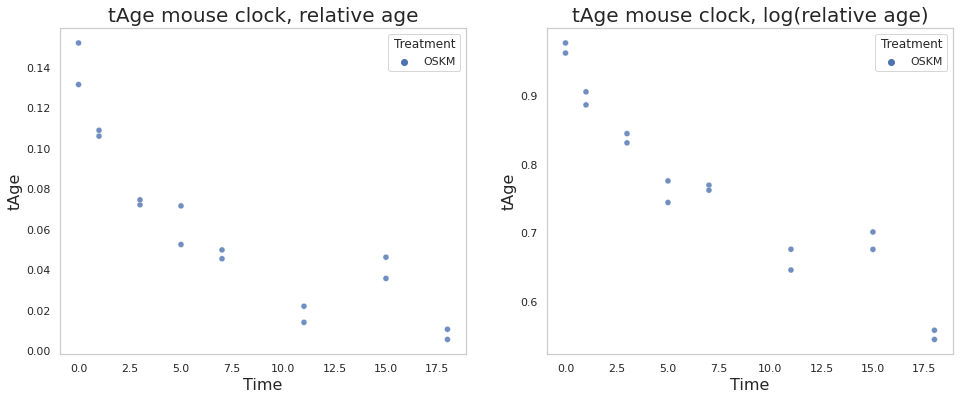

In [16]:
temp_indeces = np.where((ipsc_mouse_annotation['GEO'] == "GSE67462") & (ipsc_mouse_annotation['Treatment'] == "OSKM"))
Visualize_tAge_predictions(tAge1=tAge_mouse_ipsc_norm_mouseclock[temp_indeces[0]],
                           tAge2=tAge_mouse_ipsc_norm_mouseclock_log[temp_indeces[0]],
                           annotation=ipsc_mouse_annotation.iloc[temp_indeces[0],:],
                          x_column="Time",color_column="Treatment",
                           title1="tAge mouse clock, relative age",
                          title2 = "tAge mouse clock, log(relative age)",
                          filename="GSE67462 tAge mouse clock norm.pdf")

Mouse scaled

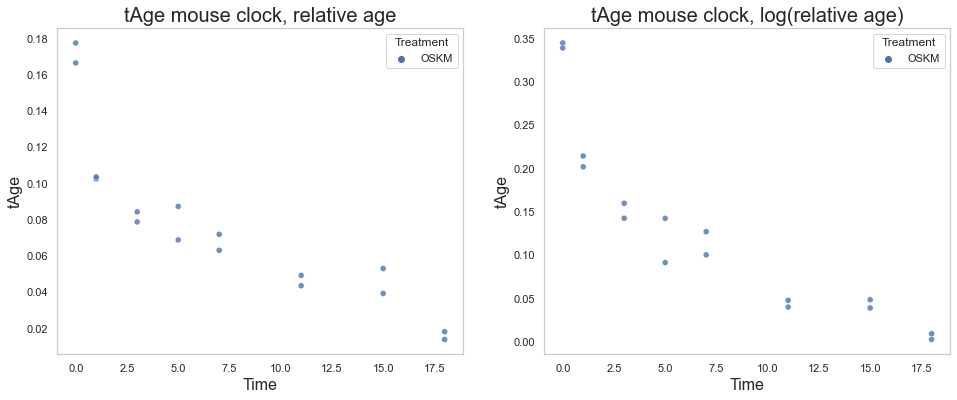

In [525]:
temp_indeces = np.where((ipsc_mouse_annotation['GEO'] == "GSE67462") & (ipsc_mouse_annotation['Treatment'] == "OSKM"))
Visualize_tAge_predictions(tAge1=tAge_mouse_ipsc_scaled_mouseclock[temp_indeces[0]],
                           tAge2=tAge_mouse_ipsc_scaled_mouseclock_log[temp_indeces[0]],
                           annotation=ipsc_mouse_annotation.iloc[temp_indeces[0],:],
                          x_column="Time",color_column="Treatment",
                           title1="tAge mouse clock, relative age",
                          title2 = "tAge mouse clock, log(relative age)",
                          filename="GSE67462 tAge mouse clock scaled.pdf")

Global norm

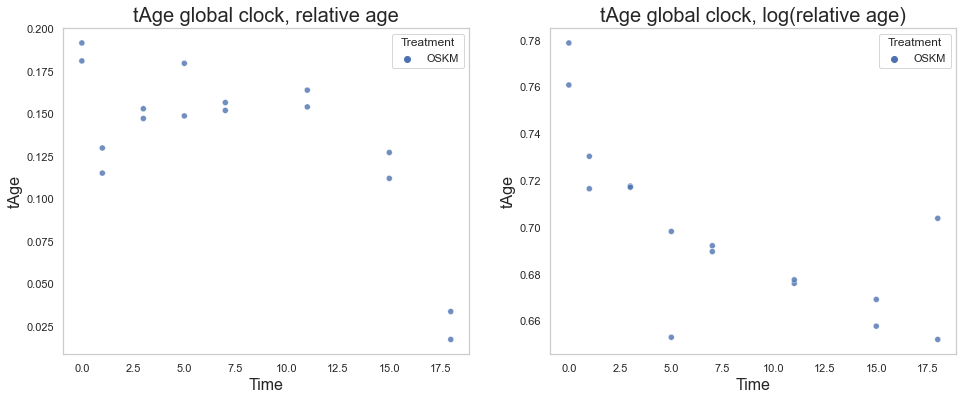

In [528]:
temp_indeces = np.where((ipsc_mouse_annotation['GEO'] == "GSE67462") & (ipsc_mouse_annotation['Treatment'] == "OSKM"))
Visualize_tAge_predictions(tAge1=tAge_mouse_ipsc_norm_globalclock[temp_indeces[0]],
                           tAge2=tAge_mouse_ipsc_norm_globalclock_log[temp_indeces[0]],
                           annotation=ipsc_mouse_annotation.iloc[temp_indeces[0],:],
                          x_column="Time",color_column="Treatment",
                           title1="tAge global clock, relative age",
                          title2 = "tAge global clock, log(relative age)",
                          filename="GSE67462 tAge global clock norm.pdf")

Global scaled

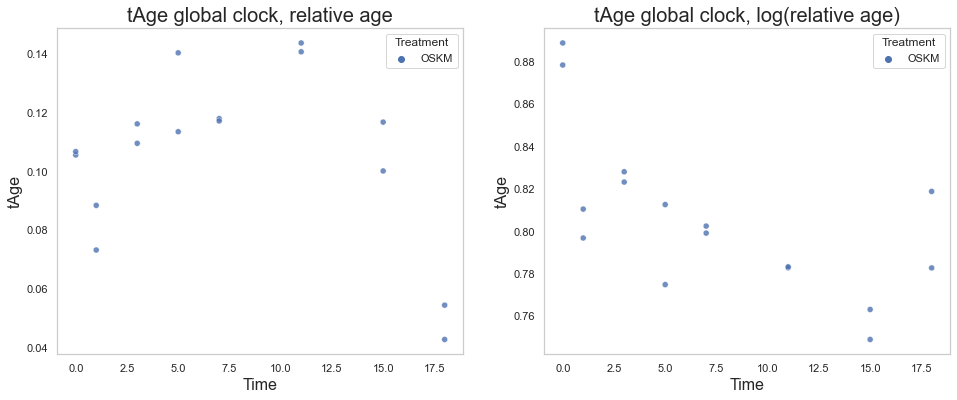

In [529]:
temp_indeces = np.where((ipsc_mouse_annotation['GEO'] == "GSE67462"))
Visualize_tAge_predictions(tAge1=tAge_mouse_ipsc_scaled_globalclock[temp_indeces[0]],
                           tAge2=tAge_mouse_ipsc_scaled_globalclock_log[temp_indeces[0]],
                           annotation=ipsc_mouse_annotation.iloc[temp_indeces[0],:],
                          x_column="Time",color_column="Treatment",
                           title1="tAge global clock, relative age",
                          title2 = "tAge global clock, log(relative age)",
                          filename="GSE67462 tAge global clock scaled.pdf")

#### GSE38509, OSKM and OSK treatment

Mouse norm

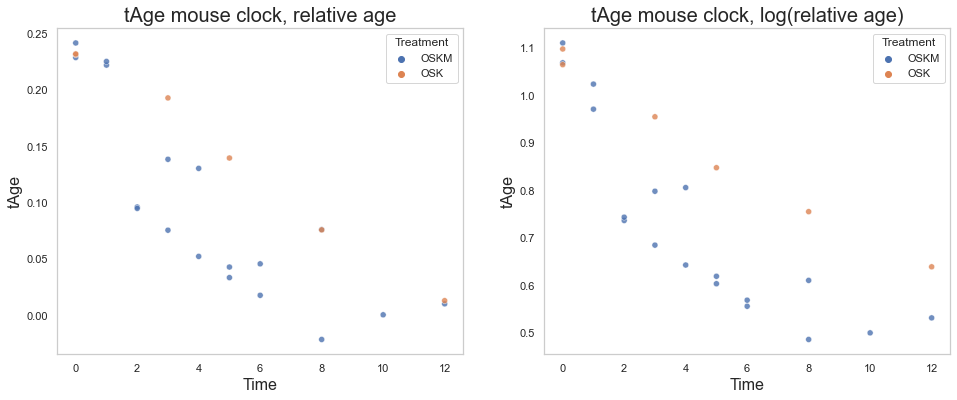

In [530]:
temp_indeces = np.where((ipsc_mouse_annotation['GEO'] == "GSE38509"))
Visualize_tAge_predictions(tAge1=tAge_mouse_ipsc_norm_mouseclock[temp_indeces[0]],
                           tAge2=tAge_mouse_ipsc_norm_mouseclock_log[temp_indeces[0]],
                           annotation=ipsc_mouse_annotation.iloc[temp_indeces[0],:],
                          x_column="Time",color_column="Treatment",
                           title1="tAge mouse clock, relative age",
                          title2 = "tAge mouse clock, log(relative age)",
                          filename="GSE38509 tAge mouse clock norm.pdf")

Mouse scaled

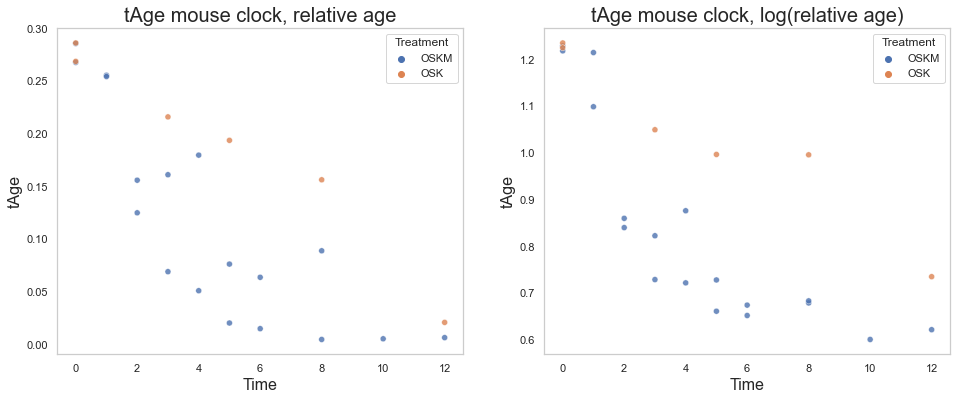

In [531]:
temp_indeces = np.where((ipsc_mouse_annotation['GEO'] == "GSE38509"))
Visualize_tAge_predictions(tAge1=tAge_mouse_ipsc_scaled_mouseclock[temp_indeces[0]],
                           tAge2=tAge_mouse_ipsc_scaled_mouseclock_log[temp_indeces[0]],
                           annotation=ipsc_mouse_annotation.iloc[temp_indeces[0],:],
                          x_column="Time",color_column="Treatment",
                           title1="tAge mouse clock, relative age",
                          title2 = "tAge mouse clock, log(relative age)",
                          filename="GSE38509 tAge mouse clock scaled.pdf")

Global norm

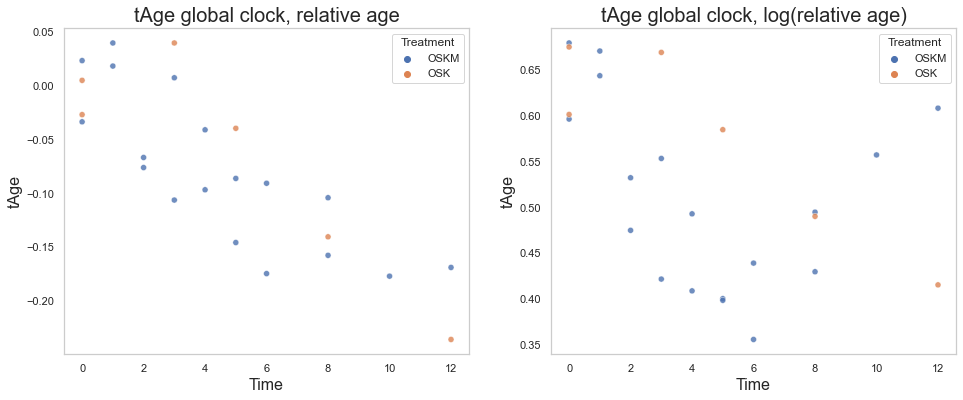

In [534]:
temp_indeces = np.where((ipsc_mouse_annotation['GEO'] == "GSE38509"))
Visualize_tAge_predictions(tAge1=tAge_mouse_ipsc_norm_globalclock[temp_indeces[0]],
                           tAge2=tAge_mouse_ipsc_norm_globalclock_log[temp_indeces[0]],
                           annotation=ipsc_mouse_annotation.iloc[temp_indeces[0],:],
                          x_column="Time",color_column="Treatment",
                           title1="tAge global clock, relative age",
                          title2 = "tAge global clock, log(relative age)",
                          filename="GSE38509 tAge global clock norm.pdf")

Global scaled

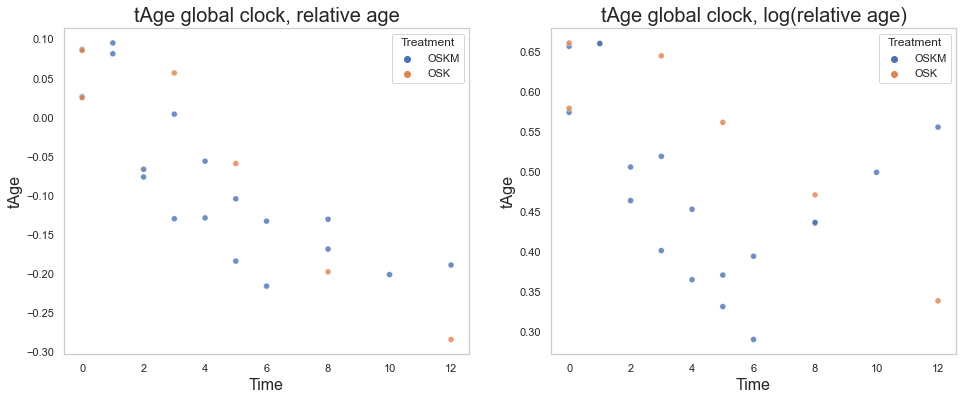

In [535]:
temp_indeces = np.where((ipsc_mouse_annotation['GEO'] == "GSE38509"))
Visualize_tAge_predictions(tAge1=tAge_mouse_ipsc_scaled_globalclock[temp_indeces[0]],
                           tAge2=tAge_mouse_ipsc_scaled_globalclock_log[temp_indeces[0]],
                           annotation=ipsc_mouse_annotation.iloc[temp_indeces[0],:],
                          x_column="Time",color_column="Treatment",
                           title1="tAge global clock, relative age",
                          title2 = "tAge global clock, log(relative age)",
                          filename="GSE38509 tAge global clock scaled.pdf")

#### GSE127927, 7F

Mouse norm

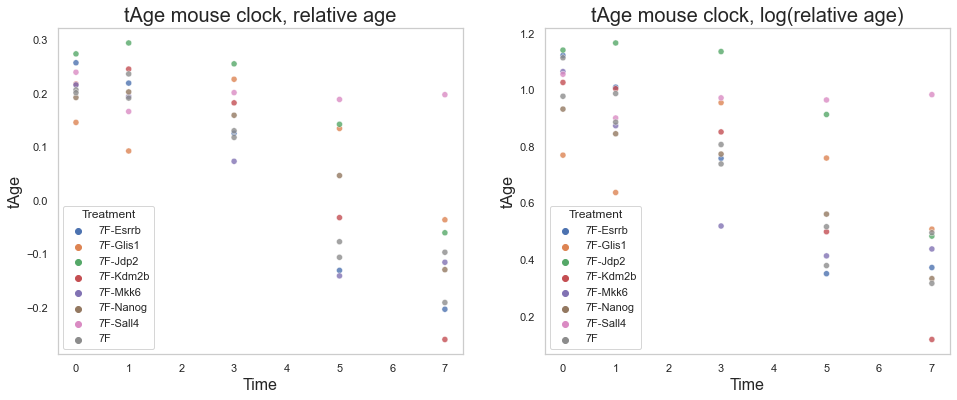

In [536]:
temp_indeces = np.where((ipsc_mouse_annotation['GEO'] == "GSE127927"))
Visualize_tAge_predictions(tAge1=tAge_mouse_ipsc_norm_mouseclock[temp_indeces[0]],
                           tAge2=tAge_mouse_ipsc_norm_mouseclock_log[temp_indeces[0]],
                           annotation=ipsc_mouse_annotation.iloc[temp_indeces[0],:],
                          x_column="Time",color_column="Treatment",
                           title1="tAge mouse clock, relative age",
                          title2 = "tAge mouse clock, log(relative age)",
                          filename="GSE127927 tAge mouse clock norm.pdf")

Mouse scaled

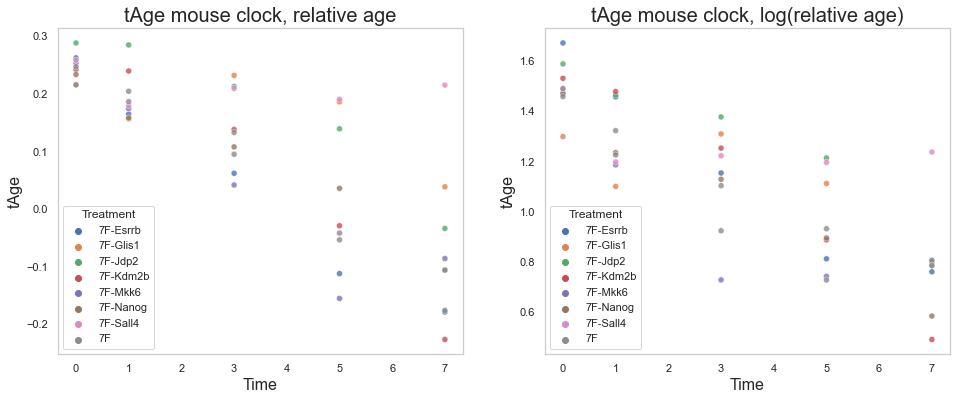

In [537]:
temp_indeces = np.where((ipsc_mouse_annotation['GEO'] == "GSE127927"))
Visualize_tAge_predictions(tAge1=tAge_mouse_ipsc_scaled_mouseclock[temp_indeces[0]],
                           tAge2=tAge_mouse_ipsc_scaled_mouseclock_log[temp_indeces[0]],
                           annotation=ipsc_mouse_annotation.iloc[temp_indeces[0],:],
                          x_column="Time",color_column="Treatment",
                           title1="tAge mouse clock, relative age",
                          title2 = "tAge mouse clock, log(relative age)",
                          filename="GSE127927 tAge mouse clock scaled.pdf")

Global norm

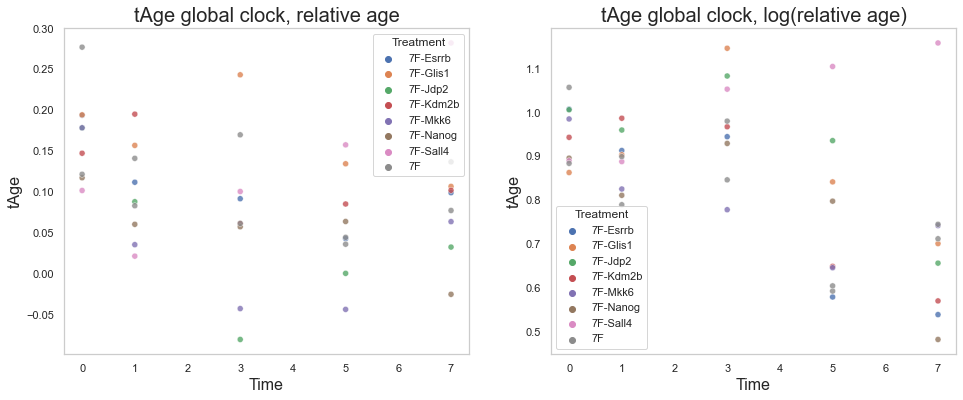

In [540]:
temp_indeces = np.where((ipsc_mouse_annotation['GEO'] == "GSE127927"))
Visualize_tAge_predictions(tAge1=tAge_mouse_ipsc_norm_globalclock[temp_indeces[0]],
                           tAge2=tAge_mouse_ipsc_norm_globalclock_log[temp_indeces[0]],
                           annotation=ipsc_mouse_annotation.iloc[temp_indeces[0],:],
                          x_column="Time",color_column="Treatment",
                           title1="tAge global clock, relative age",
                          title2 = "tAge global clock, log(relative age)",
                          filename="GSE127927 tAge global clock norm.pdf")

Global scaled

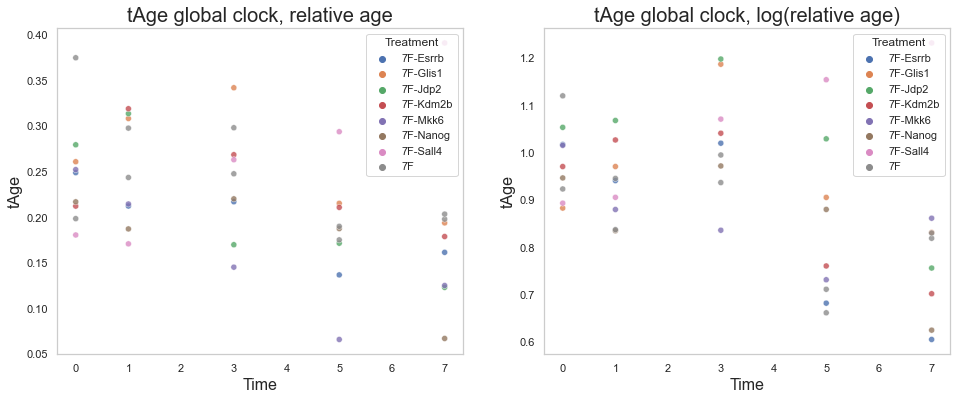

In [541]:
temp_indeces = np.where((ipsc_mouse_annotation['GEO'] == "GSE127927"))
Visualize_tAge_predictions(tAge1=tAge_mouse_ipsc_scaled_globalclock[temp_indeces[0]],
                           tAge2=tAge_mouse_ipsc_scaled_globalclock_log[temp_indeces[0]],
                           annotation=ipsc_mouse_annotation.iloc[temp_indeces[0],:],
                          x_column="Time",color_column="Treatment",
                           title1="tAge global clock, relative age",
                          title2 = "tAge global clock, log(relative age)",
                          filename="GSE127927 tAge global clock scaled.pdf")